In [2]:
# Connecting Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
import math
import numpy as np
import collections
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.backend import clear_session
import xgboost as xgb
from sklearn.utils import resample
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

import random
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)                      # NumPy random seed
tf.random.set_seed(SEED)                  # TensorFlow random seed
random.seed(SEED)                         # Python random seed

# TensorFlow session configuration for reproducibility, without setting the session explicitly
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session_conf.gpu_options.allow_growth = True

# MODELS

## =========================1. BLE based dataset=========================

#### XGBoost

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from keras.optimizers import AdamW
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import seaborn as sns

data_directory = "/content/drive/MyDrive/DATASETS/1. RSSI using BLE/Indoor Environment Dataset Based on RSSI Collected with Bluetooth Devices"

dataframes = []
for file in os.listdir(data_directory):
    if file.endswith(".csv"):  # Only process CSV files
        file_path = os.path.join(data_directory, file)
        df = pd.read_csv(file_path)
        dataframes.append(df)

data = pd.concat(dataframes, ignore_index=True)

# === Preprocess RSSI Columns ===
rssi_columns = [col for col in data.columns if "WAP" in col]
rssi_columns = rssi_columns
RSSI = data[rssi_columns].copy()
RSSI[RSSI <= -100] = np.nan
RSSI = RSSI.fillna(-100)
 min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * RSSI.shape[0])
valid_columns = RSSI.columns[(RSSI > -100).sum() > min_required_count]
RSSI = RSSI[valid_columns]
print(f"Remaining APs after filtering: {len(valid_columns)}\n")
xy = data[['X', 'Y']]
scaler_X = MinMaxScaler()
RSSI_scaled = scaler_X.fit_transform(RSSI)
scaler_y = MinMaxScaler()
xy_scaled = scaler_y.fit_transform(xy)
X_train, X_d, y_train, y_d = train_test_split(RSSI, xy_scaled, test_size=0.1, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_d, y_d, test_size=0.5, random_state=42, shuffle=True)

print(f"New size of training set: {X_train.shape[0]}")
print(f"New size of validation set: {X_val.shape[0]}")
print(f"New size of test set: {X_test.shape[0]}")

Remaining APs after filtering: 15

New size of training set: 14292
New size of validation set: 795
New size of test set: 794


In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest= xgb.DMatrix(X_test)



xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 8,
    'min_child_weight': 5,
    'subsample': 0.64,
    'colsample_bytree': 0.5,
    'n_estimators': 621,
    'seed': SEED
}

eval_results = {}

model_combined = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=9000,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=10,
    evals_result=eval_results,
    verbose_eval=50
)

[0]	train-rmse:0.27637	validation-rmse:0.28072
[50]	train-rmse:0.18747	validation-rmse:0.19124
[100]	train-rmse:0.13316	validation-rmse:0.13643
[150]	train-rmse:0.10090	validation-rmse:0.10419
[200]	train-rmse:0.08249	validation-rmse:0.08589
[250]	train-rmse:0.07279	validation-rmse:0.07635
[300]	train-rmse:0.06733	validation-rmse:0.07117
[350]	train-rmse:0.06417	validation-rmse:0.06834
[400]	train-rmse:0.06223	validation-rmse:0.06673
[450]	train-rmse:0.06077	validation-rmse:0.06565
[500]	train-rmse:0.05966	validation-rmse:0.06488
[550]	train-rmse:0.05876	validation-rmse:0.06435
[600]	train-rmse:0.05804	validation-rmse:0.06395
[650]	train-rmse:0.05748	validation-rmse:0.06370
[700]	train-rmse:0.05693	validation-rmse:0.06347
[750]	train-rmse:0.05647	validation-rmse:0.06327
[800]	train-rmse:0.05601	validation-rmse:0.06315
[850]	train-rmse:0.05557	validation-rmse:0.06303
[900]	train-rmse:0.05514	validation-rmse:0.06286
[950]	train-rmse:0.05477	validation-rmse:0.06280
[1000]	train-rmse:0.054

In [ ]:
dtest = xgb.DMatrix(X_test)
predicted_coords = model_combined.predict(dtest)
y_test_original = scaler_y.inverse_transform(y_test)
predicted_coords_original = scaler_y.inverse_transform(predicted_coords)

mse = mean_squared_error(y_test_original, predicted_coords_original)
mae = mean_absolute_error(y_test_original, predicted_coords_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, predicted_coords_original)
distances_ble = np.sqrt(np.sum((y_test_original - predicted_coords_original) ** 2, axis=1))
success_rate = np.mean(distances_ble <= 2) * 100
localization_error = np.mean(distances_ble)
print(f"\nXGBoost Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"Localization Success Rate (within 2m): {success_rate:.2f}%")
print(f"Average Localization Error: {localization_error:.4f} meters")


XGBoost Performance Metrics:
Mean Squared Error (MSE): 2.7524
Mean Absolute Error (MAE): 1.2679
Root Mean Squared Error (RMSE): 1.6590
R2 Score: 0.9369
Localization Success Rate (within 2m): 58.56%
Average Localization Error: 1.9828 meters


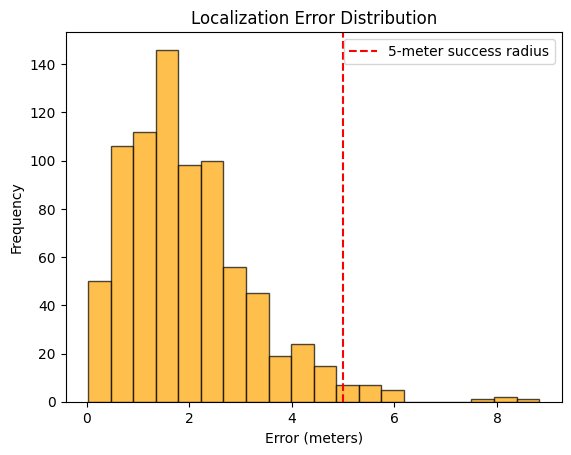

In [ ]:
plt.figure()
plt.hist(distances_ble, bins=20, color='orange', edgecolor='black', alpha=0.7)
plt.axvline(5, color='red', linestyle='--', label='5-meter success radius')
plt.legend()
plt.title('Localization Error Distribution')
plt.xlabel('Error (meters)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Save the model using XGBoost's native method (JSON format)
model_combined.save_model("/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_ble.json")

In [ ]:
import xgboost as xgb
# Load the saved model
xgb_model = xgb.Booster()
xgb_model.load_model("/content/drive/MyDrive/THESIS CODE/journal papers/models/xgb_ble.json")


#### Indoor Localization XGBoost 10 Run Stability Analysis

Final Results Across Runs:\
MAE: 1.2711 ± 0.0271\
MSE: 2.7920 ± 0.1367\
RMSE: 1.6704 ± 0.0408\
R²: 0.9401 ± 0.0019\
Success Rate (%): 97.6071 ± 0.3736\
Avg. Localization Error (m): 1.9864 ± 0.0410

In [47]:

data_directory = "/content/drive/MyDrive/DATASETS/1. RSSI using BLE/Indoor Environment Dataset Based on RSSI Collected with Bluetooth Devices"

dataframes = []
for file in os.listdir(data_directory):
    if file.endswith(".csv"):  # Only process CSV files
        file_path = os.path.join(data_directory, file)
        df = pd.read_csv(file_path)
        dataframes.append(df)

data = pd.concat(dataframes, ignore_index=True)

rssi_columns = [col for col in data.columns if "WAP" in col]


rssi_columns = rssi_columns
RSSI = data[rssi_columns].copy()
RSSI[RSSI <= -100] = np.nan

RSSI = RSSI.fillna(-100)

min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * RSSI.shape[0])
valid_columns = RSSI.columns[(RSSI > -100).sum() > min_required_count]
RSSI = RSSI[valid_columns]

print(f"Remaining APs after filtering: {len(valid_columns)}\n")


xy = data[['X', 'Y']]  # Target coordinates

# Normalize RSSI values and coordinates
scaler_X = MinMaxScaler()
RSSI_scaled = scaler_X.fit_transform(RSSI)

# scaler_y = StandardScaler()
scaler_y = MinMaxScaler()
xy_scaled = scaler_y.fit_transform(xy)

print(f"New size of training set: {X_train.shape[0]}")
print(f"New size of validation set: {X_val.shape[0]}")
print(f"New size of test set: {X_test.shape[0]}")

Remaining APs after filtering: 15

New size of training set: 14292
New size of validation set: 795
New size of test set: 794


In [48]:
import random

NUM_RUNS = 10

mae_list = []
mse_list = []
rmse_list = []
r2_list = []
success_rate_list = []
avg_loc_error_list = []

for run in range(NUM_RUNS):
    print(f"\nRun {run + 1}/{NUM_RUNS}")

    seed = random.randint(0, 10000)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    X_train, X_d, y_train, y_d = train_test_split(RSSI, xy_scaled, test_size=0.1, random_state=seed, shuffle=True)
    X_test, X_val, y_test, y_val = train_test_split(X_d, y_d, test_size=0.5, random_state=seed, shuffle=True)


    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)

    xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 10,
    'min_child_weight': 5,
    'subsample': 0.6020,
    'colsample_bytree': 0.8237,
    'n_estimators': 621,
    'seed': seed
    }


    model_combined = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=9000,
        evals=[(dtrain, 'train'), (dval, 'validation')],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    predicted_coords = model_combined.predict(dtest)
    y_test_original = scaler_y.inverse_transform(y_test)
    predicted_coords_original = scaler_y.inverse_transform(predicted_coords)

    mse = mean_squared_error(y_test_original, predicted_coords_original)
    mae = mean_absolute_error(y_test_original, predicted_coords_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_original, predicted_coords_original)
    distances = np.sqrt(np.sum((y_test_original - predicted_coords_original) ** 2, axis=1))
    success_rate = np.mean(distances <= 5) * 100
    loc_error = np.mean(distances)

    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    r2_list.append(r2)
    success_rate_list.append(success_rate)
    avg_loc_error_list.append(loc_error)

def summarize(name, values):
    print(f"{name}: {np.mean(values):.4f} ± {np.std(values):.4f}")

print("\nFinal Results Across Runs:")
summarize("MAE", mae_list)
summarize("MSE", mse_list)
summarize("RMSE", rmse_list)
summarize("R²", r2_list)
summarize("Success Rate (%)", success_rate_list)
summarize("Avg. Localization Error (m)", avg_loc_error_list)



Run 1/10

Run 2/10

Run 3/10

Run 4/10

Run 5/10

Run 6/10

Run 7/10

Run 8/10

Run 9/10

Run 10/10

Final Results Across Runs:
MAE: 1.2711 ± 0.0271
MSE: 2.7920 ± 0.1367
RMSE: 1.6704 ± 0.0408
R²: 0.9401 ± 0.0019
Success Rate (%): 97.6071 ± 0.3736
Avg. Localization Error (m): 1.9864 ± 0.0410


##  =========================2. SODIndoorLoc=========================

### CETC331 BUILDING

#### XGBoost

In [ ]:
# # Path to the directory containing CSV files
# data_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/CETC331/Training_CETC331.csv"
# tets_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/CETC331/Testing_CETC331.csv"
# data = pd.read_csv(data_directory)
# t_data = pd.read_csv(tets_directory)

# rssi_columns = [col for col in data.columns if "MAC" in col]
# threshold = 0.05 * len(data)  # Keep columns with more than 10% valid RSSI values
# valid_rssi_columns = [col for col in rssi_columns if (data[col] != 100).sum() > threshold]

# data = data.drop(columns=["BuildingID",		"UserID",	"PhoneID",	"SampleTimes"])
# t_data = t_data.drop(columns=["BuildingID",		"UserID",	"PhoneID",	"SampleTimes"])
# data = data.replace(100, -105)
# t_data = t_data.replace(100, -105)

# # Extract features and labels
# RSSI = data[rssi_columns].values
# xy = data[["ECoord", "NCoord"]].values
# x_test = t_data[rssi_columns].values
# y_test = t_data[["ECoord", "NCoord"]].values

# # Normalize RSSI values and coordinates
# scaler_X = MinMaxScaler()
# RSSI_scaled = scaler_X.fit_transform(RSSI)
# X_test = scaler_X.transform(x_test)

# # scaler_y = StandardScaler()
# scaler_y = MinMaxScaler()
# xy_scaled = scaler_y.fit_transform(xy)

# # Split the data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(
#     RSSI_scaled, xy_scaled, test_size=0.2, random_state=SEED
# )

# # Display the shape of each split to verify
# print("Shapes of the datasets after splitting:")
# print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
# print(f"Validation set: X_val: {X_val.shape}, y_val: {y_val.shape}")
# print(f"Test set: X_test: {X_test.shape}, y_test: {y_test.shape}")

Shapes of the datasets after splitting:
Training set: X_train: (764, 52), y_train: (764, 2)
Validation set: X_val: (191, 52), y_val: (191, 2)
Test set: X_test: (840, 52), y_test: (840, 2)


In [ ]:
# Path to the directory containing CSV files
data_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/CETC331/Training_CETC331.csv"
tets_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/CETC331/Testing_CETC331.csv"
data = pd.read_csv(data_directory)
t_data = pd.read_csv(tets_directory)

# === Preprocess RSSI Columns ===
rssi_columns = [col for col in data.columns if "MAC" in col]
data = data.drop(columns=["BuildingID",		"UserID",	"PhoneID",	"SampleTimes"])
t_data = t_data.drop(columns=["BuildingID",		"UserID",	"PhoneID",	"SampleTimes"])

data = data.replace(100, -105)
t_data = t_data.replace(100, -105)

# Extract features and labels
rssi_columns = rssi_columns
label_columns = ["ECoord", "NCoord"]
rssi_df = data[rssi_columns].copy()

rssi_df[rssi_df <= -100] = np.nan

min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * len(rssi_df))
valid_columns = rssi_df.columns[(rssi_df > -100).sum() > min_required_count]

rssi_df = rssi_df[valid_columns]
print(f"Remaining APs after filtering: {len(valid_columns)}")
rssi_df = rssi_df.fillna(-105)
RSSI = rssi_df.values
xy = data[label_columns].values
x_test = t_data[rssi_columns].values
y_test = t_data[label_columns].values
x_test_df = t_data[valid_columns].copy()
x_test_df = x_test_df.replace(100, -105)
x_test_df[x_test_df <= -100] = -105
x_test = x_test_df.values
scaler_X = MinMaxScaler()
RSSI_scaled = scaler_X.fit_transform(RSSI)
X_test = scaler_X.transform(x_test)
scaler_y = StandardScaler()
xy_scaled = scaler_y.fit_transform(xy)

X_train, X_val, y_train, y_val = train_test_split(
    RSSI_scaled, xy_scaled, test_size=0.2, random_state=SEED
)

# Display the shape of each split to verify
print("Shapes of the datasets after splitting:")
print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test set: X_test: {X_test.shape}, y_test: {y_test.shape}")

Remaining APs after filtering: 50
Shapes of the datasets after splitting:
Training set: X_train: (764, 50), y_train: (764, 2)
Validation set: X_val: (191, 50), y_val: (191, 2)
Test set: X_test: (840, 50), y_test: (840, 2)


In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest= xgb.DMatrix(X_test)


xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 8,
    'min_child_weight': 5,
    'subsample': 0.64,
    'colsample_bytree': 0.5,
    'n_estimators': 621,
    'seed': SEED
    }

eval_results = {}

model_combined = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=9000,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=10,
    evals_result=eval_results,
    verbose_eval=50
)

[0]	train-rmse:1.00367	validation-rmse:0.93801
[50]	train-rmse:0.64394	validation-rmse:0.60806
[100]	train-rmse:0.42206	validation-rmse:0.41091
[150]	train-rmse:0.28507	validation-rmse:0.29770
[200]	train-rmse:0.20082	validation-rmse:0.23450
[250]	train-rmse:0.14876	validation-rmse:0.20136
[300]	train-rmse:0.11651	validation-rmse:0.18497
[350]	train-rmse:0.09586	validation-rmse:0.17642
[400]	train-rmse:0.08259	validation-rmse:0.17206
[450]	train-rmse:0.07346	validation-rmse:0.16970
[500]	train-rmse:0.06670	validation-rmse:0.16799
[550]	train-rmse:0.06130	validation-rmse:0.16695
[600]	train-rmse:0.05687	validation-rmse:0.16621
[650]	train-rmse:0.05333	validation-rmse:0.16564
[700]	train-rmse:0.05021	validation-rmse:0.16518
[741]	train-rmse:0.04797	validation-rmse:0.16489


In [ ]:
y_pred_scaled_combined = model_combined.predict(dtest)
y_pred_combined = scaler_y.inverse_transform(y_pred_scaled_combined)

y_test_combined = y_test
mae_xy = mean_absolute_error(y_test_combined, y_pred_combined)
mse_xy = mean_squared_error(y_test_combined, y_pred_combined)
rmse_xy = np.sqrt(mse_xy)
r2_xy = r2_score(y_test_combined, y_pred_combined)
success_radius = 5
distances_c = np.sqrt(np.sum((y_test_combined - y_pred_combined) ** 2, axis=1))
success_rate_combined = np.mean(distances_c <= success_radius) * 100
localization_error_combined = np.mean(distances_c)

print(f"Metrics for Localization (ECoord and NCoord):")
print(f"Mean Absolute Error (MAE): {mae_xy:.3f}")
print(f"Mean Squared Error (MSE): {mse_xy:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xy:.3f}")
print(f"R2 Score: {r2_xy:.3f}")
print(f"Localization Success Rate (within {success_radius} meters): {success_rate_combined:.3f}%")
print(f"Average Localization Error: {localization_error_combined:.3f} meters")



Metrics for Localization (ECoord and NCoord):
Mean Absolute Error (MAE): 2.028
Mean Squared Error (MSE): 14.491
Root Mean Squared Error (RMSE): 3.807
R2 Score: 0.897
Localization Success Rate (within 5 meters): 82.024%
Average Localization Error: 3.543 meters


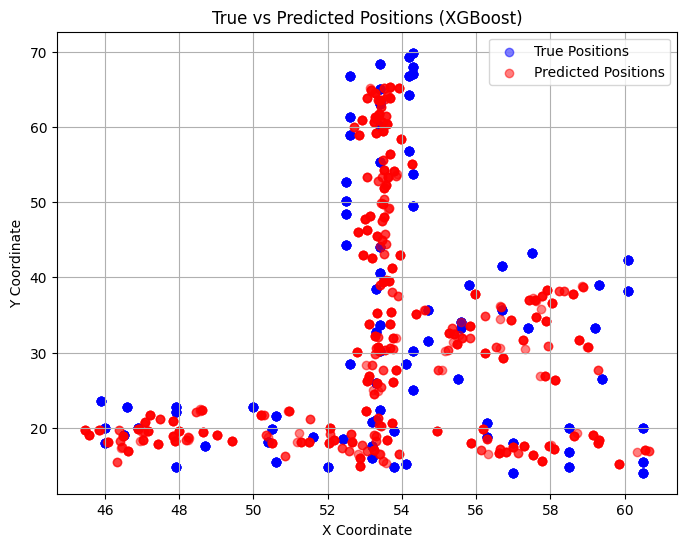

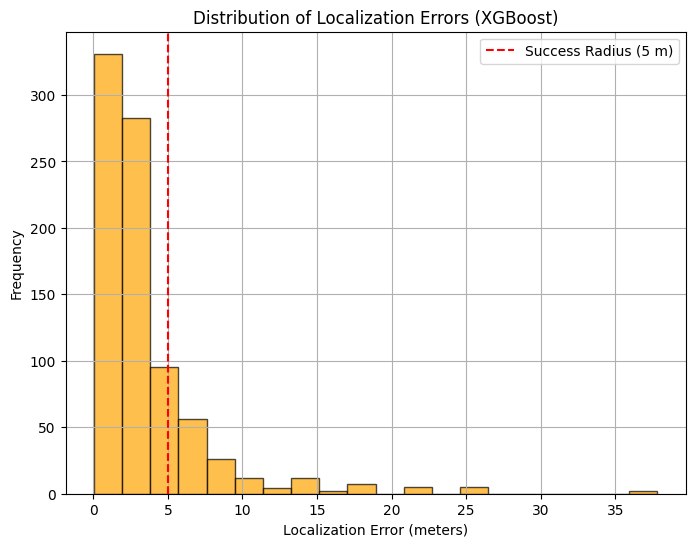

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test[:, 0], y_test[:, 1], c='blue', label='True Positions', alpha=0.5)
plt.scatter(y_pred_combined[:, 0], y_pred_combined[:, 1], c='red', label='Predicted Positions', alpha=0.5)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('True vs Predicted Positions (XGBoost)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(distances_c, bins=20, color='orange', edgecolor='black', alpha=0.7)
plt.axvline(success_radius, color='red', linestyle='--', label=f'Success Radius ({success_radius} m)')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Frequency')
plt.title('Distribution of Localization Errors (XGBoost)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
model_combined.save_model("/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_cetc311.json")

#### Indoor Localization XGBoost 10 Run Stability Analysis

 Final Metrics Across Runs:\
MAE (m): 2.017 ± 0.013\
MSE (m): 14.253 ± 0.414\
RMSE (m): 3.775 ± 0.055\
R²: 0.899 ± 0.001\
Success Rate (%): 81.905 ± 0.402\
Avg. Localization Error (m): 3.523 ± 0.024

In [4]:

# Path to the directory containing CSV files
data_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/CETC331/Training_CETC331.csv"
tets_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/CETC331/Testing_CETC331.csv"
data = pd.read_csv(data_directory)
t_data = pd.read_csv(tets_directory)

# === Preprocess RSSI Columns ===
rssi_columns = [col for col in data.columns if "MAC" in col]
data = data.drop(columns=["BuildingID",		"UserID",	"PhoneID",	"SampleTimes"])
t_data = t_data.drop(columns=["BuildingID",		"UserID",	"PhoneID",	"SampleTimes"])

data = data.replace(100, -105)
t_data = t_data.replace(100, -105)

# Extract features and labels
rssi_columns = rssi_columns
label_columns = ["ECoord", "NCoord"]
rssi_df = data[rssi_columns].copy()

rssi_df[rssi_df <= -100] = np.nan

min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * len(rssi_df))
valid_columns = rssi_df.columns[(rssi_df > -100).sum() > min_required_count]

rssi_df = rssi_df[valid_columns]
print(f"Remaining APs after filtering: {len(valid_columns)}")
rssi_df = rssi_df.fillna(-105)
RSSI = rssi_df.values
xy = data[label_columns].values
x_test = t_data[rssi_columns].values
y_test = t_data[label_columns].values
x_test_df = t_data[valid_columns].copy()
x_test_df = x_test_df.replace(100, -105)
x_test_df[x_test_df <= -100] = -105
x_test = x_test_df.values
scaler_X = MinMaxScaler()
RSSI_scaled = scaler_X.fit_transform(RSSI)
X_test = scaler_X.transform(x_test)
scaler_y = StandardScaler()
xy_scaled = scaler_y.fit_transform(xy)

X_train, X_val, y_train, y_val = train_test_split(
    RSSI_scaled, xy_scaled, test_size=0.2, random_state=SEED
)

# Display the shape of each split to verify
print("Shapes of the datasets after splitting:")
print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test set: X_test: {X_test.shape}, y_test: {y_test.shape}")

Remaining APs after filtering: 50
Shapes of the datasets after splitting:
Training set: X_train: (764, 50), y_train: (764, 2)
Validation set: X_val: (191, 50), y_val: (191, 2)
Test set: X_test: (840, 50), y_test: (840, 2)


In [5]:
import random

NUM_RUNS = 10

# Store metrics
mae_list = []
mse_list = []
rmse_list = []
r2_list = []
success_rate_list = []
avg_loc_error_list = []

for run in range(NUM_RUNS):
    print(f"\n Run {run + 1}/{NUM_RUNS}")

    seed = random.randint(0, 10000)
    np.random.seed(seed)

     # Train
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 8,
    'min_child_weight': 5,
    'subsample': 0.64,
    'colsample_bytree': 0.5,
    'n_estimators': 621,
    'seed': seed
    }


    model_combined = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=9000,
        evals=[(dtrain, 'train'), (dval, 'validation')],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    # Predict and inverse transform
    y_pred_scaled = model_combined.predict(dtest)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = y_test


    # 2D localization metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Success rate within 5m
    distances = np.linalg.norm(y_true - y_pred, axis=1)
    success_rate = np.mean(distances <= 5) * 100
    avg_loc_error = np.mean(distances)

    # Append to lists
    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    r2_list.append(r2)
    success_rate_list.append(success_rate)
    avg_loc_error_list.append(avg_loc_error)

# === Print Summary ===
def summarize(name, values):
    print(f"{name}: {np.mean(values):.3f} ± {np.std(values):.3f}")

print("\n Final Metrics Across Runs:")
summarize("MAE (m)", mae_list)
summarize("MSE (m)", mse_list)
summarize("RMSE (m)", rmse_list)
summarize("R²", r2_list)
summarize("Success Rate (%)", success_rate_list)
summarize("Avg. Localization Error (m)", avg_loc_error_list)


 Run 1/10

 Run 2/10

 Run 3/10

 Run 4/10

 Run 5/10

 Run 6/10

 Run 7/10

 Run 8/10

 Run 9/10

 Run 10/10

 Final Metrics Across Runs:
MAE (m): 2.017 ± 0.013
MSE (m): 14.253 ± 0.414
RMSE (m): 3.775 ± 0.055
R²: 0.899 ± 0.001
Success Rate (%): 81.905 ± 0.402
Avg. Localization Error (m): 3.523 ± 0.024


#### Classification

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler

path_train = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/CETC331/Training_CETC331.csv"
path_test = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/CETC331/Testing_CETC331.csv"


data = pd.read_csv(path_train)
data.replace(100, -105, inplace=True)

t_data = pd.read_csv(path_test)
t_data.replace(100, -105, inplace=True)

data.head()

,MAC1,MAC2,MAC3,MAC4,MAC5,MAC6,MAC7,MAC8,MAC9,MAC10,...,MAC51,MAC52,ECoord,NCoord,FloorID,BuildingID,SceneID,UserID,PhoneID,SampleTimes
0,-44,-48,-71,-85,-92,-105,-105,-105,-88,-105,...,-105,-105,45.0,17.5,1,1,1,4,3,1
1,-37,-50,-72,-85,-93,-105,-93,-105,-86,-105,...,-105,-105,45.5,17.5,1,1,1,4,3,1
2,-41,-51,-68,-84,-88,-105,-93,-105,-84,-105,...,-105,-105,46.0,17.5,1,1,1,4,3,1
3,-38,-50,-67,-89,-83,-90,-92,-105,-83,-105,...,-105,-105,46.5,17.5,1,1,1,4,3,1
4,-35,-57,-63,-87,-86,-87,-105,-105,-81,-105,...,-105,-105,46.9,17.5,1,1,1,4,3,1


In [ ]:
# Balancing the dataset by resampling
def balance_data(df):
    max_samples = df['BuildingID'].value_counts().max()
    df_balanced = pd.DataFrame()
    for building_id in df['BuildingID'].unique():
        building_data = df[df['BuildingID'] == building_id]
        balanced_building_data = resample(building_data, replace=True, n_samples=max_samples, random_state=SEED)
        df_balanced = pd.concat([df_balanced, balanced_building_data])

        max_samples_f = df['FloorID'].value_counts().max()
    df_balanced = pd.DataFrame()
    for floor_id in df['FloorID'].unique():
        floor_data = df[df['FloorID'] == floor_id]
        balanced_floor_data = resample(floor_data, replace=True, n_samples=max_samples_f, random_state=SEED)
        df_balanced = pd.concat([df_balanced, balanced_floor_data])
    return df_balanced


In [ ]:
# Extract the necessary columns
rssi_columns = [col for col in data.columns if "MAC" in col]  # Assume columns with 'WAP' are the RSSI columns

data["FloorID"] = data["FloorID"] - 1
t_data["FloorID"] = t_data["FloorID"] - 1

rssi = data[rssi_columns]
X_test = t_data[rssi_columns]
y = data["FloorID"]  # Target variable: the floor label
y_test = t_data["FloorID"]
# Normalize RSSI values using MinMaxScaler
scaler_X = MinMaxScaler()
RSSI = scaler_X.fit_transform(rssi)
X_test_scaled = scaler_X.transform(X_test)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(RSSI, y, test_size=0.2, random_state=42)


In [ ]:
data["FloorID"].unique()

array([0, 1, 2])

In [ ]:
data["FloorID_zero"].unique()

array([0, 1, 2])

In [ ]:
# Initialize XGBoost model for classification
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,  # 3 floors (0, 1, 2, )
    max_depth=6,
    learning_rate=0.1,
    n_estimators=1000,  # Large number of trees to allow early stopping
    eval_metric='mlogloss',
    use_label_encoder=False
)

# Create the evaluation set for early stopping
eval_set = [(X_train, y_train), (X_val, y_val)]

xgb_model.fit(
    X_train, y_train,
    eval_set=eval_set,
    # early_stopping_rounds=50,   # Stop training if validation metric doesn't improve for 50 rounds
    verbose=50  # Print out evaluation results
)



[0]	validation_0-mlogloss:0.95562	validation_1-mlogloss:0.95689
[50]	validation_0-mlogloss:0.00696	validation_1-mlogloss:0.01294
[100]	validation_0-mlogloss:0.00189	validation_1-mlogloss:0.00760
[150]	validation_0-mlogloss:0.00189	validation_1-mlogloss:0.00760
[200]	validation_0-mlogloss:0.00189	validation_1-mlogloss:0.00760
[250]	validation_0-mlogloss:0.00189	validation_1-mlogloss:0.00760
[300]	validation_0-mlogloss:0.00189	validation_1-mlogloss:0.00760
[350]	validation_0-mlogloss:0.00189	validation_1-mlogloss:0.00760
[400]	validation_0-mlogloss:0.00189	validation_1-mlogloss:0.00760
[450]	validation_0-mlogloss:0.00189	validation_1-mlogloss:0.00760
[500]	validation_0-mlogloss:0.00189	validation_1-mlogloss:0.00760
[550]	validation_0-mlogloss:0.00189	validation_1-mlogloss:0.00760
[600]	validation_0-mlogloss:0.00189	validation_1-mlogloss:0.00760
[650]	validation_0-mlogloss:0.00189	validation_1-mlogloss:0.00760
[700]	validation_0-mlogloss:0.00189	validation_1-mlogloss:0.00760
[750]	validat

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [ ]:
# Make predictions on validation set
y_val_pred = xgb_model.predict(X_val)
y_test_pred = xgb_model.predict(X_test_scaled)

# Evaluate model performance on the validation set
# print("Validation Set Performance:")
# print("Accuracy:", accuracy_score(y_val, y_val_pred))
# print("Classification Report:\n", classification_report(y_val, y_val_pred))

# Evaluate model performance on the test set
print("Test Set Performance:")
print("Accuracy:", accuracy_score(y_test, y_test_pred)*100)
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Test Set Performance:
Accuracy: 98.92857142857143
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       280
           1       1.00      0.99      0.99       320
           2       0.98      0.98      0.98       240

    accuracy                           0.99       840
   macro avg       0.99      0.99      0.99       840
weighted avg       0.99      0.99      0.99       840



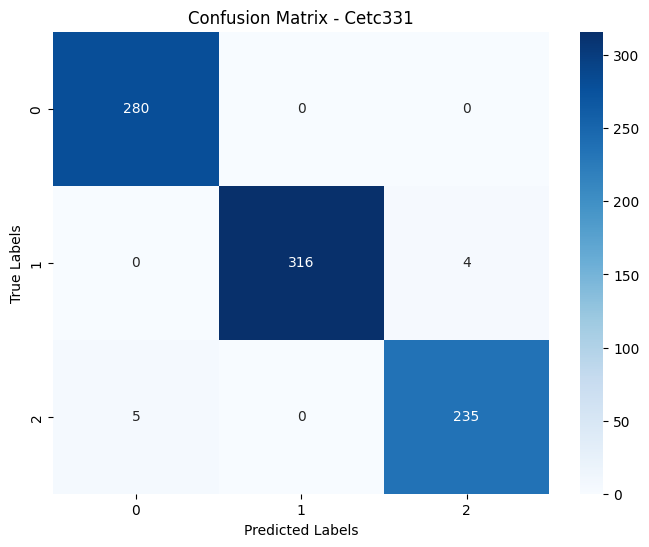

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title("Confusion Matrix - Cetc331")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig('cm_cetc.png', dpi=3000, bbox_inches='tight')
plt.show()

In [ ]:
xgb_model.save_model("/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_floor_classifier.json")

#
# from xgboost import XGBClassifier
# loaded_model = XGBClassifier()
# loaded_model.load_model("xgb_floor_classifier.json")


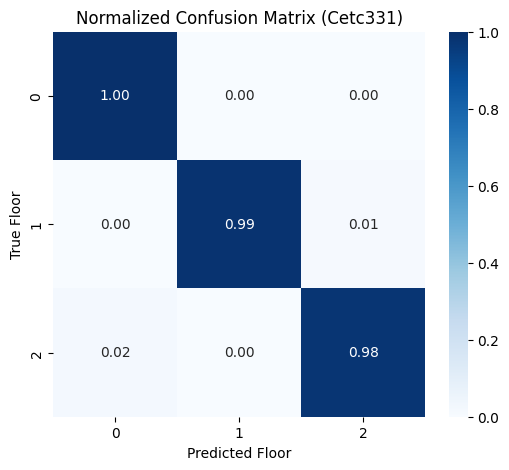

Mean absolute floor error: 0.02 ± 0.17 floors
– Adjacent‑floor confusions (|Δ|=1): 0.5%
– Non‑adjacent‑floor confusions (|Δ|>1): 0.6%


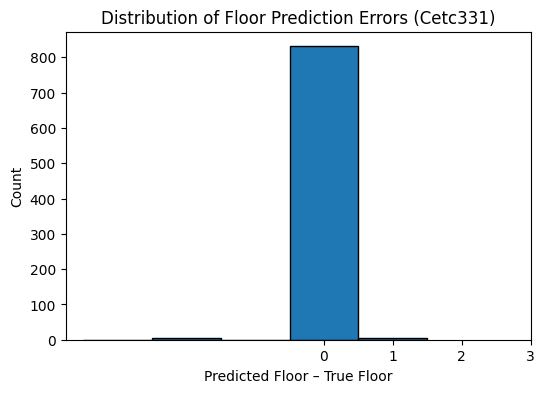


Classification Report:
              precision    recall  f1-score   support

     Floor 0       0.98      1.00      0.99       280
     Floor 1       1.00      0.99      0.99       320
     Floor 2       0.98      0.98      0.98       240

    accuracy                           0.99       840
   macro avg       0.99      0.99      0.99       840
weighted avg       0.99      0.99      0.99       840



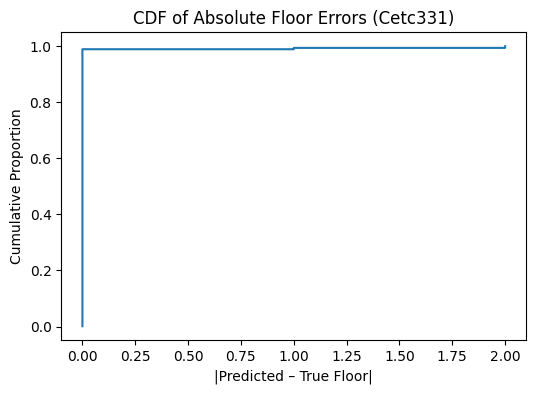

– <= 0 floor error: 98.9%
– <= 1 floor error: 99.4%
– <= 2 floor error: 100.0%

Top 10 most important WAPs for floor classification:
  MAC48: 0.3482
  MAC8: 0.2326
  MAC42: 0.2224
  MAC18: 0.1056
  MAC1: 0.0288
  MAC24: 0.0254
  MAC20: 0.0161
  MAC21: 0.0043
  MAC4: 0.0042
  MAC30: 0.0036


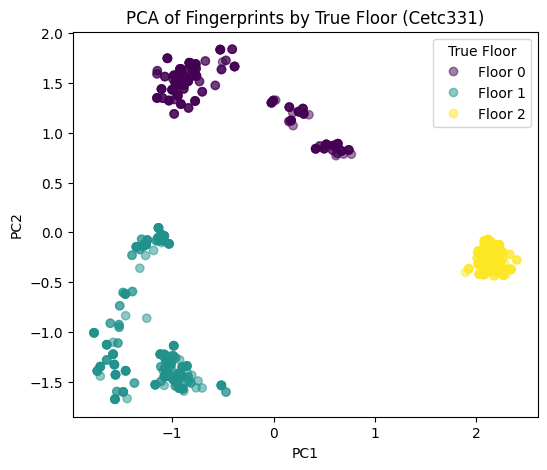

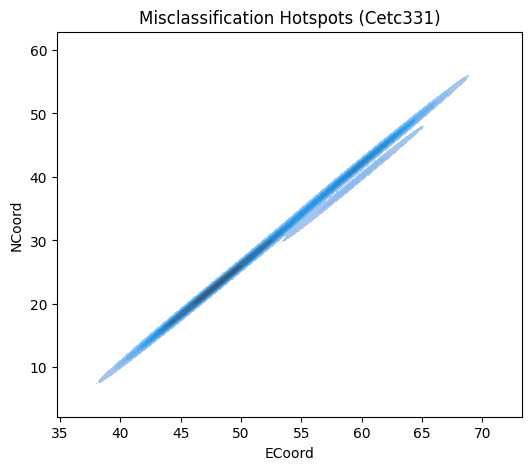

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_floor_classification(y_true, y_pred, floors, X_test_scaled=None,
                                 rssi_columns=None, model=None, df_coords=None,
                                 title=""):
    # 1. Confusion matrix (absolute and normalized)
    cm = confusion_matrix(y_true, y_pred, labels=floors)
    cm_norm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_norm, annot=True, fmt=".2f",
                xticklabels=floors, yticklabels=floors, cmap="Blues")
    plt.title(f"Normalized Confusion Matrix {title}")
    plt.xlabel("Predicted Floor"); plt.ylabel("True Floor")
    plt.show()

    # 2. Floor‐error statistics
    floor_err = y_pred - y_true
    abs_err   = np.abs(floor_err)
    mean_err  = abs_err.mean(); std_err = abs_err.std()
    adj_pct   = 100 * np.sum(abs_err == 1) / len(abs_err)
    nonadj_pct= 100 * np.sum(abs_err > 1) / len(abs_err)
    print(f"Mean absolute floor error: {mean_err:.2f} ± {std_err:.2f} floors")
    print(f"– Adjacent‑floor confusions (|Δ|=1): {adj_pct:.1f}%")
    print(f"– Non‑adjacent‑floor confusions (|Δ|>1): {nonadj_pct:.1f}%")

    # 3. Histogram of raw floor errors
    plt.figure(figsize=(6,4))
    bins = np.arange(floor_err.min()-1, floor_err.max()+2) - 0.5
    plt.hist(floor_err, bins=bins, edgecolor='k')
    plt.xticks(list(floors) + [floors[-1]+1])
    plt.title(f"Distribution of Floor Prediction Errors {title}")
    plt.xlabel("Predicted Floor – True Floor"); plt.ylabel("Count")
    plt.savefig('DIST_Cetc331.png', dpi=3000, bbox_inches='tight')
    plt.show()

    # 4. Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred,
                                target_names=[f"Floor {f}" for f in floors]))

    # 5. CDF of absolute errors
    sorted_err = np.sort(abs_err)
    cdf = np.arange(1, len(sorted_err)+1) / len(sorted_err)
    plt.figure(figsize=(6,4))
    plt.step(sorted_err, cdf, where='post')
    plt.xlabel('|Predicted – True Floor|')
    plt.ylabel('Cumulative Proportion')
    plt.title(f'CDF of Absolute Floor Errors {title}')
    plt.savefig('CDF_Cetc331.png', dpi=3000, bbox_inches='tight')
    plt.show()
    # Print a few key CDF points
    for d in [0,1,2]:
        pct = cdf[ np.searchsorted(sorted_err, d, 'right') - 1 ] * 100
        print(f"– <= {d} floor error: {pct:.1f}%")

    # 6. Feature importances (requires model & feature names)
    if model is not None and rssi_columns is not None:
        importances = model.feature_importances_
        idx = np.argsort(importances)[::-1][:10]  # top 10
        print("\nTop 10 most important WAPs for floor classification:")
        for i in idx:
            print(f"  {rssi_columns[i]}: {importances[i]:.4f}")

    # 7. PCA visualization (requires X_test_scaled)
    if X_test_scaled is not None:
        pca = PCA(n_components=2)
        proj = pca.fit_transform(X_test_scaled)
        plt.figure(figsize=(6,5))
        scatter = plt.scatter(proj[:,0], proj[:,1], c=y_true, alpha=0.5)
        plt.legend(handles=scatter.legend_elements()[0],
                   labels=[f"Floor {f}" for f in floors],
                   title="True Floor")
        plt.title(f"PCA of Fingerprints by True Floor {title}")
        plt.xlabel('PC1'); plt.ylabel('PC2')
        plt.savefig('PCA_Cetc331.png', dpi=3000, bbox_inches='tight')
        plt.show()

    # 8. Spatial heatmap of misclassifications (requires df_coords with LONGITUDE, LATITUDE)
    if df_coords is not None:
        df = df_coords.copy()
        df['err'] = floor_err
        mis = df[df.err != 0]
        if not mis.empty:
            plt.figure(figsize=(6,5))
            sns.kdeplot(x='ECoord', y='NCoord', data=mis,
                        shade=True, thresh=0.1)
            plt.title(f"Misclassification Hotspots {title}")
            plt.xlabel("ECoord"); plt.ylabel("NCoord")
            plt.savefig('Misclassification_Cetc331.png', dpi=3000, bbox_inches='tight')
            plt.show()

# Usage for Building 0:
floors = [0,1,2]
analyze_floor_classification(
    y_true=y_test,
    y_pred=y_test_pred,
    floors=floors,
    X_test_scaled=X_test_scaled,
    rssi_columns=rssi_columns,
    model=xgb_model,
    df_coords=t_data,
    title="(Cetc331)"
)


### HCXY BUILDING

#### XGBoost

In [14]:

# data_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/HCXY/pre installed AP only/Training_HCXY_AP_Avg.csv"
data_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/HCXY/pre installed AP only/Training_HCXY_AP_30.csv"
tets_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/HCXY/pre installed AP only/Testing_HCXY_AP.csv"
data = pd.read_csv(data_directory)
t_data = pd.read_csv(tets_directory)

# === Preprocess RSSI Columns ===
rssi_columns = [col for col in data.columns if "MAC" in col]
data = data.drop(columns=["BuildingID",		"UserID",	"PhoneID",	"SampleTimes"])
t_data = t_data.drop(columns=["BuildingID",		"UserID",	"PhoneID",	"SampleTimes"])
data = data.replace(100, -98)
t_data = t_data.replace(100, -98)

# Extract features and labels
rssi_columns = rssi_columns
label_columns = ["ECoord", "NCoord"]

rssi_df = data[rssi_columns].copy()

rssi_df[rssi_df <= -100] = np.nan
min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * len(rssi_df))
valid_columns = rssi_df.columns[(rssi_df > -100).sum() > min_required_count]
rssi_df = rssi_df[valid_columns]
print(f"Remaining APs after filtering: {len(valid_columns)}")
rssi_df = rssi_df.fillna(-98)
RSSI = rssi_df.values

xy = data[label_columns].values
x_test_df = t_data[valid_columns].copy()
x_test_df = x_test_df.replace(100, -98)
x_test_df[x_test_df <= -100] = -98
x_test = x_test_df.values

y_test = t_data[label_columns].values
scaler_X = MinMaxScaler()
RSSI_scaled = scaler_X.fit_transform(RSSI)
X_test = scaler_X.transform(x_test)

scaler_y = StandardScaler()
xy_scaled = scaler_y.fit_transform(xy)

X_train, X_val, y_train, y_val = train_test_split(
    RSSI_scaled, xy_scaled, test_size=0.2, random_state=SEED
)

# Display the shape of each split to verify
print("Shapes of the datasets after splitting:")
print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test set: X_test: {X_test.shape}, y_test: {y_test.shape}")

Remaining APs after filtering: 56
Shapes of the datasets after splitting:
Training set: X_train: (9096, 56), y_train: (9096, 2)
Validation set: X_val: (2274, 56), y_val: (2274, 2)
Test set: X_test: (860, 56), y_test: (860, 2)


In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest= xgb.DMatrix(X_test)

xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 8,
    'min_child_weight': 5,
    'subsample': 0.64,
    'colsample_bytree': 0.5,
    'n_estimators': 621,
    'seed': SEED
}

eval_results = {}

model_combined = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=9000,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=10,
    evals_result=eval_results,
    verbose_eval=50
)

[0]	train-rmse:0.98965	validation-rmse:0.99198
[50]	train-rmse:0.60338	validation-rmse:0.60537
[100]	train-rmse:0.36866	validation-rmse:0.37030
[150]	train-rmse:0.22625	validation-rmse:0.22784
[200]	train-rmse:0.13991	validation-rmse:0.14169
[250]	train-rmse:0.08795	validation-rmse:0.09003
[300]	train-rmse:0.05689	validation-rmse:0.05953
[350]	train-rmse:0.03866	validation-rmse:0.04190
[400]	train-rmse:0.02820	validation-rmse:0.03201
[450]	train-rmse:0.02224	validation-rmse:0.02651
[500]	train-rmse:0.01887	validation-rmse:0.02346
[550]	train-rmse:0.01678	validation-rmse:0.02156
[600]	train-rmse:0.01544	validation-rmse:0.02035
[650]	train-rmse:0.01448	validation-rmse:0.01948
[700]	train-rmse:0.01376	validation-rmse:0.01887
[750]	train-rmse:0.01312	validation-rmse:0.01828
[800]	train-rmse:0.01257	validation-rmse:0.01778
[850]	train-rmse:0.01211	validation-rmse:0.01735
[900]	train-rmse:0.01166	validation-rmse:0.01694
[950]	train-rmse:0.01126	validation-rmse:0.01659
[1000]	train-rmse:0.010

In [15]:
y_pred_scaled_combined = model_combined.predict(dtest)
y_pred_combined = scaler_y.inverse_transform(y_pred_scaled_combined)
y_test_combined = y_test

mae_xy = mean_absolute_error(y_test_combined, y_pred_combined)
mse_xy = mean_squared_error(y_test_combined, y_pred_combined)
rmse_xy = np.sqrt(mse_xy)
r2_xy = r2_score(y_test_combined, y_pred_combined)

success_radius = 5
distances_h = np.sqrt(np.sum((y_test_combined - y_pred_combined) ** 2, axis=1))
success_rate_combined = np.mean(distances_h <= success_radius) * 100
localization_error_combined = np.mean(distances_h)
print(f"Metrics for Localization (ECoord and NCoord):")
print(f"Mean Absolute Error (MAE): {mae_xy:.3f}")
print(f"Mean Squared Error (MSE): {mse_xy:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xy:.3f}")
print(f"R2 Score: {r2_xy:.3f}")
print(f"Localization Success Rate (within {success_radius} meters): {success_rate_combined:.3f}%")
print(f"Average Localization Error: {localization_error_combined:.3f} meters")


ValueError: Found input variables with inconsistent numbers of samples: [860, 840]

In [ ]:
model_combined.save_model("/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_hcky.json")

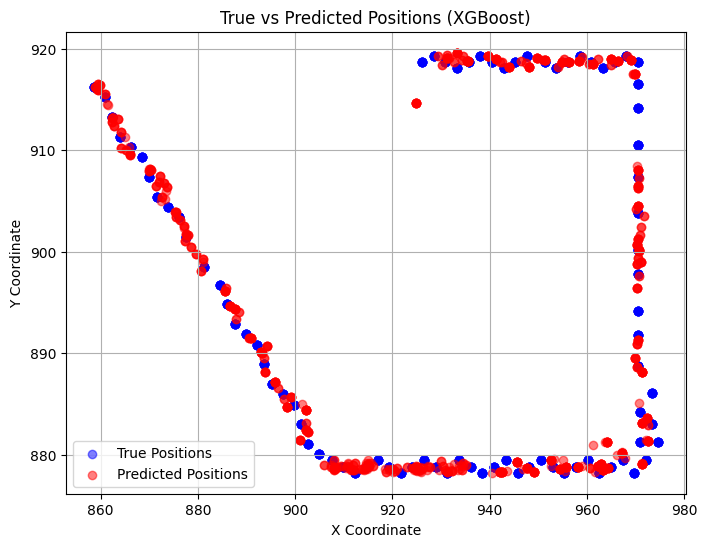

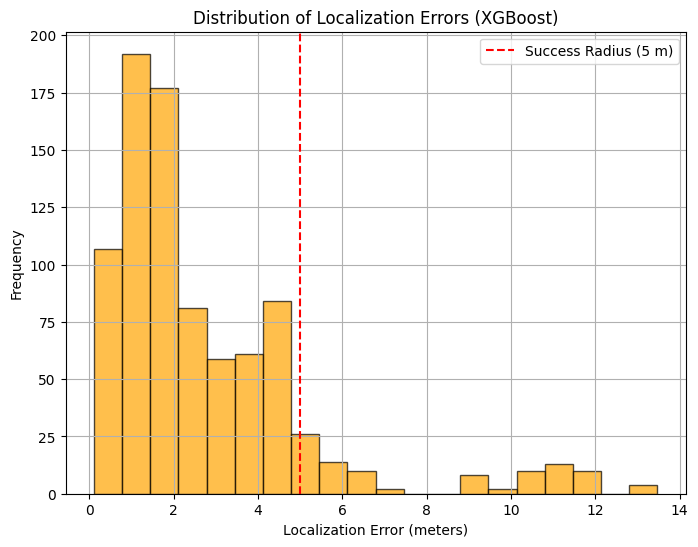

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test[:, 0], y_test[:, 1], c='blue', label='True Positions', alpha=0.5)
plt.scatter(y_pred_combined[:, 0], y_pred_combined[:, 1], c='red', label='Predicted Positions', alpha=0.5)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('True vs Predicted Positions (XGBoost)')
plt.legend()
plt.grid()
plt.show()

# Histogram of localization errors
plt.figure(figsize=(8, 6))
plt.hist(distances_h, bins=20, color='orange', edgecolor='black', alpha=0.7)
plt.axvline(success_radius, color='red', linestyle='--', label=f'Success Radius ({success_radius} m)')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Frequency')
plt.title('Distribution of Localization Errors (XGBoost)')
plt.legend()
plt.grid()
plt.show()

#### Indoor Localization XGBoost 10 Run Stability Analysis

Final Metrics Across Runs:\
MAE (m): 1.598 ± 0.024\
RMSE (m): 2.631 ± 0.050\
R²: 0.985 ± 0.001\
Success Rate (%): 88.628 ± 0.778\
Avg. Localization Error (m): 2.768 ± 0.045\
MSE (m): 6.927 ± 0.264

In [6]:

# data_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/HCXY/pre installed AP only/Training_HCXY_AP_Avg.csv"
data_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/HCXY/pre installed AP only/Training_HCXY_AP_30.csv"
tets_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/HCXY/pre installed AP only/Testing_HCXY_AP.csv"
data = pd.read_csv(data_directory)
t_data = pd.read_csv(tets_directory)

# === Preprocess RSSI Columns ===
rssi_columns = [col for col in data.columns if "MAC" in col]
data = data.drop(columns=["BuildingID",		"UserID",	"PhoneID",	"SampleTimes"])
t_data = t_data.drop(columns=["BuildingID",		"UserID",	"PhoneID",	"SampleTimes"])
data = data.replace(100, -98)
t_data = t_data.replace(100, -98)

# Extract features and labels
rssi_columns = rssi_columns
label_columns = ["ECoord", "NCoord"]

rssi_df = data[rssi_columns].copy()

rssi_df[rssi_df <= -100] = np.nan
min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * len(rssi_df))
valid_columns = rssi_df.columns[(rssi_df > -100).sum() > min_required_count]
rssi_df = rssi_df[valid_columns]
print(f"Remaining APs after filtering: {len(valid_columns)}")
rssi_df = rssi_df.fillna(-98)
RSSI = rssi_df.values

xy = data[label_columns].values
x_test_df = t_data[valid_columns].copy()
x_test_df = x_test_df.replace(100, -98)
x_test_df[x_test_df <= -100] = -98
x_test = x_test_df.values

y_test = t_data[label_columns].values
scaler_X = MinMaxScaler()
RSSI_scaled = scaler_X.fit_transform(RSSI)
X_test = scaler_X.transform(x_test)

scaler_y = StandardScaler()
xy_scaled = scaler_y.fit_transform(xy)

X_train, X_val, y_train, y_val = train_test_split(
    RSSI_scaled, xy_scaled, test_size=0.2, random_state=SEED
)

Remaining APs after filtering: 56


In [7]:
import random

NUM_RUNS = 10

mae_list = []
rmse_list = []
r2_list = []
mse_list = []
success_rate_list = []
avg_loc_error_list = []

for run in range(NUM_RUNS):
    print(f"\n Run {run + 1}/{NUM_RUNS}")

    seed = random.randint(0, 10000)
    np.random.seed(seed)

    X_train, X_val, y_train, y_val = train_test_split(
        RSSI_scaled, xy_scaled, test_size=0.2, random_state=seed
    )

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 8,
    'min_child_weight': 5,
    'subsample': 0.64,
    'colsample_bytree': 0.5,
    'n_estimators': 621,
    'seed': seed
    }


    model_combined = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=9000,
        evals=[(dtrain, 'train'), (dval, 'validation')],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    y_pred_scaled = model_combined.predict(dtest)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = y_test

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    distances = np.linalg.norm(y_true - y_pred, axis=1)
    success_rate = np.mean(distances <= 5) * 100
    avg_loc_error = np.mean(distances)

    mae_list.append(mae)
    rmse_list.append(rmse)
    mse_list.append(mse)
    r2_list.append(r2)
    success_rate_list.append(success_rate)
    avg_loc_error_list.append(avg_loc_error)

def summarize(name, values):
    print(f"{name}: {np.mean(values):.3f} ± {np.std(values):.3f}")

print("\nFinal Metrics Across Runs:")
summarize("MAE (m)", mae_list)
summarize("RMSE (m)", rmse_list)
summarize("R²", r2_list)
summarize("Success Rate (%)", success_rate_list)
summarize("Avg. Localization Error (m)", avg_loc_error_list)
summarize("MSE (m)", mse_list)


 Run 1/10

 Run 2/10

 Run 3/10

 Run 4/10

 Run 5/10

 Run 6/10

 Run 7/10

 Run 8/10

 Run 9/10

 Run 10/10

Final Metrics Across Runs:
MAE (m): 1.598 ± 0.024
RMSE (m): 2.631 ± 0.050
R²: 0.985 ± 0.001
Success Rate (%): 88.628 ± 0.778
Avg. Localization Error (m): 2.768 ± 0.045
MSE (m): 6.927 ± 0.264


### SYL BUILDING

#### XGBoost

In [ ]:
# Path to the directory containing CSV files
# data_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/SYL/Only pre installed AP/Training_SYL_AP_Avg.csv"
data_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/SYL/Only pre installed AP/Training_SYL_AP_30.csv"
tets_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/SYL/Only pre installed AP/Testing_SYL_AP.csv"
data = pd.read_csv(data_directory)
t_data = pd.read_csv(tets_directory)

data.replace(100, -93, inplace=True)
t_data.replace(100, -93, inplace=True)

# === Preprocess RSSI Columns ===
rssi_columns = [col for col in data.columns if "MAC" in col]

data = data.drop(columns=[	"SceneID", "BuildingID",		"UserID",	"PhoneID",	"SampleTimes"])
t_data = t_data.drop(columns=[	"SceneID", "BuildingID",		"UserID",	"PhoneID",	"SampleTimes"])

rssi_columns = rssi_columns
label_columns = ["ECoord", "NCoord"]

rssi_df = data[rssi_columns].copy()
rssi_df[rssi_df <= -100] = np.nan
min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * len(rssi_df))
valid_columns = rssi_df.columns[(rssi_df > -100).sum() > min_required_count]

rssi_df = rssi_df[valid_columns]
print(f"Remaining APs after filtering: {len(valid_columns)}")

rssi_df = rssi_df.fillna(-93)

RSSI = rssi_df.values

xy = data[["ECoord", "NCoord"]].values
x_test = t_data[rssi_columns].values

x_test_df = t_data[valid_columns].copy()
x_test_df = x_test_df.replace(100, -93)
x_test_df[x_test_df <= -100] = -93
x_test = x_test_df.values
y_test = t_data[label_columns].values


scaler_X = MinMaxScaler()
RSSI_scaled = scaler_X.fit_transform(RSSI)
X_test = scaler_X.transform(x_test)

scaler_y = StandardScaler()
xy_scaled = scaler_y.fit_transform(xy)


X_train, X_val, y_train, y_val = train_test_split(
    RSSI_scaled, xy_scaled, test_size=0.2, random_state=SEED
)
print("Shapes of the datasets after splitting:")
print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test set: X_test: {X_test.shape}, y_test: {y_test.shape}")
xy = data[["ECoord", "NCoord"]].values
x_test = t_data[rssi_columns].values
y_test = t_data[["ECoord", "NCoord"]].values



Remaining APs after filtering: 46
Shapes of the datasets after splitting:
Training set: X_train: (7104, 46), y_train: (7104, 2)
Validation set: X_val: (1776, 46), y_val: (1776, 2)
Test set: X_test: (1020, 46), y_test: (1020, 2)


In [ ]:
# Create DMatrix for combined X and YZ
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest= xgb.DMatrix(X_test)


xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 8,
    'min_child_weight': 5,
    'subsample': 0.64,
    'colsample_bytree': 0.5,
    'n_estimators': 621,
    'seed': SEED
}

eval_results = {}

model_combined = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=9000,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=10,
    evals_result=eval_results,
    verbose_eval=50
)

[0]	train-rmse:0.99034	validation-rmse:0.99084
[50]	train-rmse:0.61058	validation-rmse:0.61177
[100]	train-rmse:0.37924	validation-rmse:0.38055
[150]	train-rmse:0.23805	validation-rmse:0.23946
[200]	train-rmse:0.15302	validation-rmse:0.15436
[250]	train-rmse:0.10252	validation-rmse:0.10384
[300]	train-rmse:0.07361	validation-rmse:0.07483
[350]	train-rmse:0.05782	validation-rmse:0.05895
[400]	train-rmse:0.04960	validation-rmse:0.05059
[450]	train-rmse:0.04525	validation-rmse:0.04617
[500]	train-rmse:0.04277	validation-rmse:0.04366
[550]	train-rmse:0.04132	validation-rmse:0.04221
[600]	train-rmse:0.04032	validation-rmse:0.04130
[650]	train-rmse:0.03962	validation-rmse:0.04063
[700]	train-rmse:0.03911	validation-rmse:0.04017
[750]	train-rmse:0.03872	validation-rmse:0.03986
[800]	train-rmse:0.03845	validation-rmse:0.03960
[850]	train-rmse:0.03821	validation-rmse:0.03938
[900]	train-rmse:0.03802	validation-rmse:0.03919
[950]	train-rmse:0.03785	validation-rmse:0.03904
[965]	train-rmse:0.0378

In [ ]:
y_pred_scaled_combined = model_combined.predict(dtest)
y_pred_combined = scaler_y.inverse_transform(y_pred_scaled_combined)
y_test_combined = y_test
mae_xy = mean_absolute_error(y_test_combined, y_pred_combined)
mse_xy = mean_squared_error(y_test_combined, y_pred_combined)
rmse_xy = np.sqrt(mse_xy)
r2_xy = r2_score(y_test_combined, y_pred_combined)
success_radius = 5
distances_s = np.sqrt(np.sum((y_test_combined - y_pred_combined) ** 2, axis=1))
success_rate_combined = np.mean(distances_s <= success_radius) * 100
localization_error_combined = np.mean(distances_s)

# Print Results
print(f"Metrics for Localization (ECoord and NCoord):")
print(f"Mean Absolute Error (MAE): {mae_xy:.3f}")
print(f"Mean Squared Error (MSE): {mse_xy:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xy:.3f}")
print(f"R2 Score: {r2_xy:.3f}")
print(f"Localization Success Rate (within {success_radius} meters): {success_rate_combined:.3f}%")
print(f"Average Localization Error: {localization_error_combined:.3f} meters")

Metrics for Localization (ECoord and NCoord):
Mean Absolute Error (MAE): 2.147
Mean Squared Error (MSE): 18.923
Root Mean Squared Error (RMSE): 4.350
R2 Score: 0.918
Localization Success Rate (within 5 meters): 83.431%
Average Localization Error: 3.588 meters


In [ ]:
# Save the model using XGBoost's native method (JSON format)
model_combined.save_model("/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_syl.json")

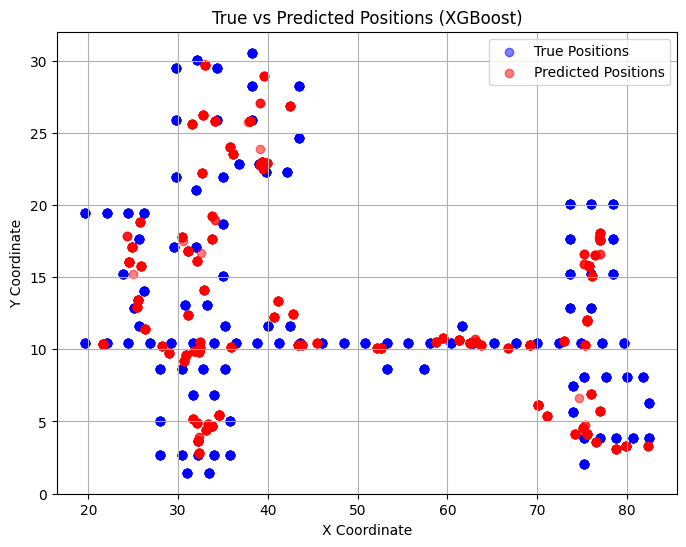

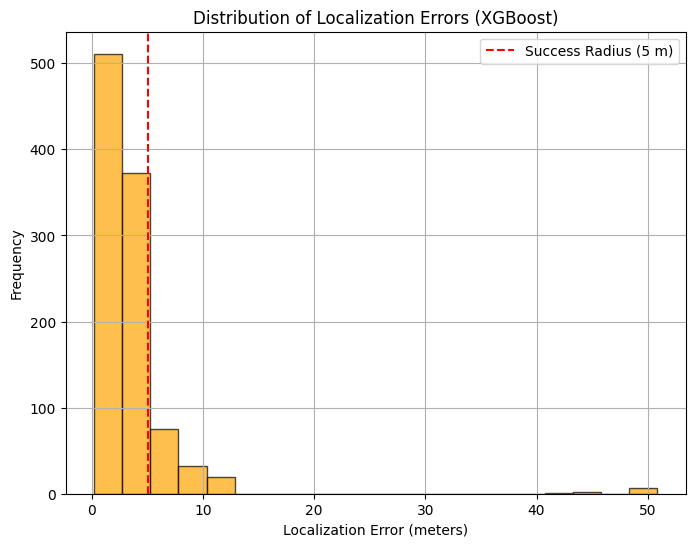

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test[:, 0], y_test[:, 1], c='blue', label='True Positions', alpha=0.5)
plt.scatter(y_pred_combined[:, 0], y_pred_combined[:, 1], c='red', label='Predicted Positions', alpha=0.5)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('True vs Predicted Positions (XGBoost)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(distances_s, bins=20, color='orange', edgecolor='black', alpha=0.7)
plt.axvline(success_radius, color='red', linestyle='--', label=f'Success Radius ({success_radius} m)')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Frequency')
plt.title('Distribution of Localization Errors (XGBoost)')
plt.legend()
plt.grid()
plt.show()

#### Indoor Localization XGBoost 10 Run Stability Analysis

Final Metrics Across Runs:\
MAE (m): 2.204 ± 0.020\
RMSE (m): 4.396 ± 0.032\
R²: 0.916 ± 0.001\
Success Rate (%): 83.461 ± 0.812\
Avg. Localization Error (m): 3.680 ± 0.038\
MSE (m): 19.326 ± 0.280

In [56]:
# data_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/SYL/Only pre installed AP/Training_SYL_AP_Avg.csv"
data_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/SYL/Only pre installed AP/Training_SYL_AP_30.csv"
tets_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/SYL/Only pre installed AP/Testing_SYL_AP.csv"
data = pd.read_csv(data_directory)
t_data = pd.read_csv(tets_directory)
data.replace(100, -93, inplace=True)
t_data.replace(100, -93, inplace=True)

# === Preprocess RSSI Columns ===
rssi_columns = [col for col in data.columns if "MAC" in col]
data = data.drop(columns=[	"SceneID", "BuildingID",		"UserID",	"PhoneID",	"SampleTimes"])
t_data = t_data.drop(columns=[	"SceneID", "BuildingID",		"UserID",	"PhoneID",	"SampleTimes"])
rssi_columns = rssi_columns
label_columns = ["ECoord", "NCoord"]
rssi_df = data[rssi_columns].copy()
rssi_df[rssi_df <= -100] = np.nan
min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * len(rssi_df))
valid_columns = rssi_df.columns[(rssi_df > -100).sum() > min_required_count]
rssi_df = rssi_df[valid_columns]
print(f"Remaining APs after filtering: {len(valid_columns)}")
rssi_df = rssi_df.fillna(-93)
RSSI = rssi_df.values
xy = data[label_columns].values
x_test = t_data[rssi_columns].values
x_test_df = t_data[valid_columns].copy()
x_test_df = x_test_df.replace(100, -93)
x_test_df[x_test_df <= -100] = -93
x_test = x_test_df.values
y_test = t_data[label_columns].values
scaler_X = MinMaxScaler()
RSSI_scaled = scaler_X.fit_transform(RSSI)
X_test = scaler_X.transform(x_test)
scaler_y = StandardScaler()
xy_scaled = scaler_y.fit_transform(xy)


X_train, X_val, y_train, y_val = train_test_split(
    RSSI_scaled, xy_scaled, test_size=0.2, random_state=SEED
)


Remaining APs after filtering: 46


In [58]:
import random

NUM_RUNS = 10  # Or 5 for faster runs

# Store metrics
mae_list = []
rmse_list = []
mse_list = []
r2_list = []
success_rate_list = []
avg_loc_error_list = []

for run in range(NUM_RUNS):
    print(f"\n Run {run + 1}/{NUM_RUNS}")

    seed = random.randint(0, 10000)
    np.random.seed(seed)

    # Split training/validation with different seed each time
    X_train, X_val, y_train, y_val = train_test_split(
        RSSI_scaled, xy_scaled, test_size=0.2, random_state=seed
    )

    # Train
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    xgb_params = {
    'objective': 'reg:squarederror',  #  squarederror => MSE
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 8,
    'min_child_weight': 5,
    'subsample': 0.64,
    'colsample_bytree': 0.5,
    'n_estimators': 621,
    'seed': seed
    }

    model_combined = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=9000,
        evals=[(dtrain, 'train'), (dval, 'validation')],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    # Predict and inverse transform
    y_pred_scaled = model_combined.predict(dtest)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = y_test

    # 2D localization metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Success rate within 5m
    distances = np.linalg.norm(y_true - y_pred, axis=1)
    success_rate = np.mean(distances <= 5) * 100
    avg_loc_error = np.mean(distances)

    # Append to lists
    mae_list.append(mae)
    rmse_list.append(rmse)
    mse_list.append(mse)
    r2_list.append(r2)
    success_rate_list.append(success_rate)
    avg_loc_error_list.append(avg_loc_error)

# === Print Summary ===
def summarize(name, values):
    print(f"{name}: {np.mean(values):.3f} ± {np.std(values):.3f}")

print("\n Final Metrics Across Runs:")
summarize("MAE (m)", mae_list)
summarize("RMSE (m)", rmse_list)
summarize("R²", r2_list)
summarize("Success Rate (%)", success_rate_list)
summarize("Avg. Localization Error (m)", avg_loc_error_list)
summarize("MSE (m)", mse_list)


 Run 1/10

 Run 2/10

 Run 3/10

 Run 4/10

 Run 5/10

 Run 6/10

 Run 7/10

 Run 8/10

 Run 9/10

 Run 10/10

 Final Metrics Across Runs:
MAE (m): 2.204 ± 0.020
RMSE (m): 4.396 ± 0.032
R²: 0.916 ± 0.001
Success Rate (%): 83.461 ± 0.812
Avg. Localization Error (m): 3.680 ± 0.038
MSE (m): 19.326 ± 0.280


## =========================3. UJIndoorLoc=========================

### building 0

#### XGBoost



In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from keras.optimizers import AdamW
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import seaborn as sns

path_train = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building0/UjiindoorLoc_building_0/train_building_0.csv"
path_test = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building0/UjiindoorLoc_building_0/val_building_0.csv"

data = pd.read_csv(path_train)            # min rssi = -101
data.replace(100, -102, inplace=True)

t_data = pd.read_csv(path_test)
t_data.replace(100, -102, inplace=True)

data.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,-102,-102,-102,-102,-102,-102,-102,-102,-102,-102,...,-102,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710
1,-102,-102,-102,-102,-102,-102,-102,-102,-102,-102,...,-102,-7637.2570,4.864950e+06,0,0,102,2,11,13,1369908951
2,-102,-102,-102,-102,-102,-102,-102,-102,-102,-102,...,-102,-7628.1345,4.864977e+06,0,0,110,2,11,13,1369909107
3,-102,-102,-102,-102,-102,-102,-102,-102,-102,-102,...,-102,-7622.0546,4.864976e+06,0,0,111,2,11,13,1369909166
4,-102,-102,-102,-102,-102,-102,-102,-102,-102,-102,...,-102,-7636.2057,4.864967e+06,0,0,107,2,11,13,1369909011


In [ ]:

rssi_columns = [col for col in data.columns if "WAP" in col]

rssi = data[rssi_columns].copy()
XYZ_Pos = data[["LONGITUDE",	"LATITUDE" ]]

x_test =  t_data[rssi_columns]
y_test =  t_data[["LONGITUDE",	"LATITUDE"]]

rssi[rssi <= -100] = np.nan
x_test[x_test <= -100] = np.nan

min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * rssi.shape[0])
valid_columns = rssi.columns[(rssi > -100).sum() > min_required_count]

rssi = rssi[valid_columns].fillna(-103)
x_test = x_test[valid_columns].fillna(-103)

print(f"Remaining APs after filtering: {len(valid_columns)}\n")

scaler_X = MinMaxScaler()
RSSI = scaler_X.fit_transform(rssi)
X_test = scaler_X.fit_transform(x_test)

scaler_y = MinMaxScaler()
xyz_Pos = scaler_y.fit_transform(XYZ_Pos)

X_train, X_val, y_train, y_val = train_test_split(RSSI, xyz_Pos, test_size=0.2, random_state=42)

# Display the shape of each split to verify
print("Shapes of the datasets after splitting:")
print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test set: X_test: {X_test.shape}, y_test: {y_test.shape}")



Remaining APs after filtering: 77

Shapes of the datasets after splitting:
Training set: X_train: (4199, 77), y_train: (4199, 2)
Validation set: X_val: (1050, 77), y_val: (1050, 2)
Test set: X_test: (536, 77), y_test: (536, 2)


In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest= xgb.DMatrix(X_test)

xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 8,
    'min_child_weight': 5,
    'subsample': 0.64,
    'colsample_bytree': 0.5,
    'n_estimators': 621,
    'seed': SEED
}

eval_results = {}

model_combined = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=9000,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=10,
    evals_result=eval_results,
    verbose_eval=50
)

[0]	train-rmse:0.25403	validation-rmse:0.25863
[50]	train-rmse:0.16057	validation-rmse:0.16462
[100]	train-rmse:0.10336	validation-rmse:0.10724
[150]	train-rmse:0.06840	validation-rmse:0.07267
[200]	train-rmse:0.04733	validation-rmse:0.05237
[250]	train-rmse:0.03483	validation-rmse:0.04082
[300]	train-rmse:0.02745	validation-rmse:0.03440
[350]	train-rmse:0.02299	validation-rmse:0.03080
[400]	train-rmse:0.02019	validation-rmse:0.02874
[450]	train-rmse:0.01840	validation-rmse:0.02754
[500]	train-rmse:0.01710	validation-rmse:0.02673
[550]	train-rmse:0.01611	validation-rmse:0.02619
[600]	train-rmse:0.01537	validation-rmse:0.02582
[650]	train-rmse:0.01478	validation-rmse:0.02553
[700]	train-rmse:0.01427	validation-rmse:0.02529
[750]	train-rmse:0.01384	validation-rmse:0.02512
[800]	train-rmse:0.01341	validation-rmse:0.02493
[850]	train-rmse:0.01308	validation-rmse:0.02479
[900]	train-rmse:0.01274	validation-rmse:0.02465
[950]	train-rmse:0.01240	validation-rmse:0.02452
[1000]	train-rmse:0.012

In [ ]:
predictions = model_combined.predict(dtest)
predicted_coords_xgb_original = scaler_y.inverse_transform(predictions)
y_test_original =  t_data[["LONGITUDE",	"LATITUDE"]].values
mse_xgb = mean_squared_error(y_test_original, predicted_coords_xgb_original)
mae_xgb = mean_absolute_error(y_test_original, predicted_coords_xgb_original)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test_original, predicted_coords_xgb_original)
success_radius = 5
distances_1 = np.sqrt(np.sum((y_test_original - predicted_coords_xgb_original) ** 2, axis=1))
success_rate_xgb = np.mean(distances_1 <= success_radius) * 100
localization_error_xgb = np.mean(distances_1)
print(f"Mean Squared Error (MSE): {mse_xgb:.3f}")
print(f"Mean Absolute Error (MAE): {mae_xgb:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.3f}")
print(f"R2 Score: {r2_xgb:.3f}")
print(f"Localization Success Rate (within {success_radius} meters): {success_rate_xgb:.3f}%")
print(f"Average Localization Error: {localization_error_xgb:.3f} meters")

Mean Squared Error (MSE): 42.748
Mean Absolute Error (MAE): 4.582
Root Mean Squared Error (RMSE): 6.538
R2 Score: 0.947
Localization Success Rate (within 5 meters): 43.284%
Average Localization Error: 7.253 meters


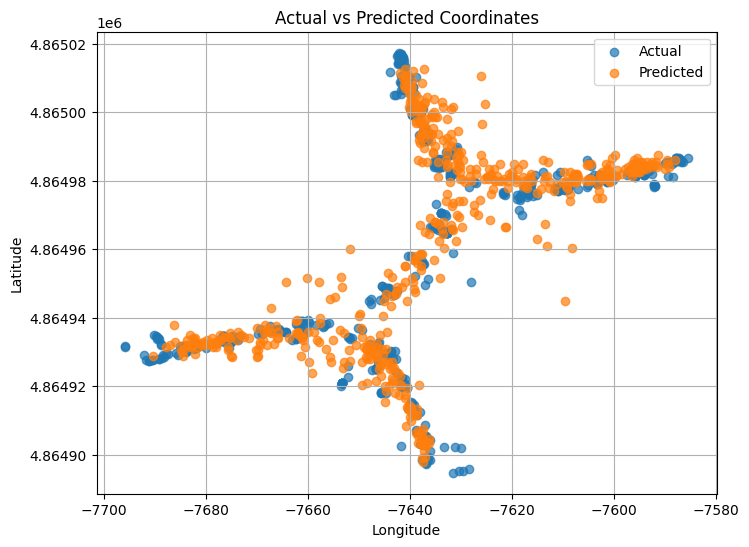

In [ ]:
# Extract actual and predicted longitude and latitude
actual_long = y_test["LONGITUDE"].values
actual_lat = y_test["LATITUDE"].values
predicted_long = predicted_coords_xgb_original[:, 0]
predicted_lat = predicted_coords_xgb_original[:, 1]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_long, actual_lat, label='Actual', alpha=0.7)
plt.scatter(predicted_long, predicted_lat, label='Predicted', alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Actual vs Predicted Coordinates')
plt.legend()
plt.grid(True)
plt.show()

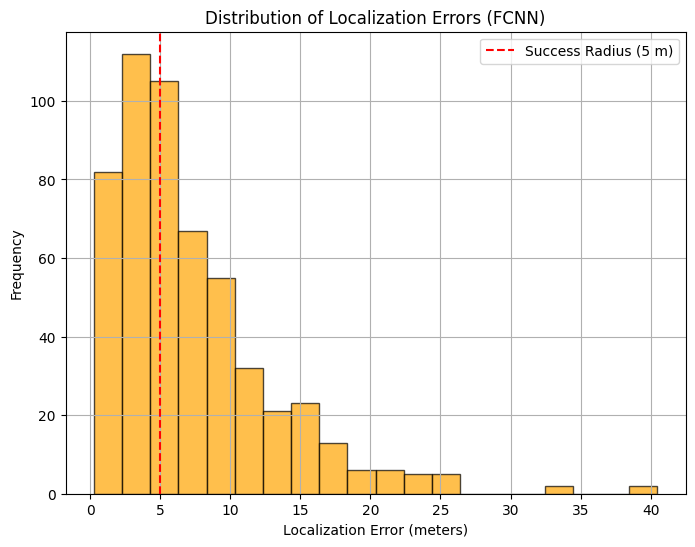

In [ ]:
# Histogram of localization errors
plt.figure(figsize=(8, 6))
plt.hist(distances_1, bins=20, color='orange', edgecolor='black', alpha=0.7)
plt.axvline(success_radius, color='red', linestyle='--', label=f'Success Radius ({success_radius} m)')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Localization Errors (FCNN)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
model_combined.save_model("/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_bo.json")

#### Indoor Localization XGBoost 10 Run Stability Analysis

Final Metrics for UJIIndoorLoc Building 0 (across runs):\
MAE (m): 4.539 ± 0.039\
RMSE (m): 6.464 ± 0.054\
R²: 0.948 ± 0.001\
Success Rate (%): 43.713 ± 0.708\
Avg. Localization Error (m): 7.184 ± 0.063\
MSE (m): 41.787 ± 0.699

In [8]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from keras.optimizers import AdamW
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import seaborn as sns

# Load your training and validation datasets
path_train = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building0/UjiindoorLoc_building_0/train_building_0.csv"
path_test = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building0/UjiindoorLoc_building_0/val_building_0.csv"

data = pd.read_csv(path_train)
data.replace(100, -103, inplace=True)

t_data = pd.read_csv(path_test)
t_data.replace(100, -103, inplace=True)
rssi_columns = [col for col in data.columns if "WAP" in col]

rssi = data[rssi_columns].copy()
XYZ_Pos = data[["LONGITUDE",	"LATITUDE" ]]

x_test =  t_data[rssi_columns]
y_test =  t_data[["LONGITUDE",	"LATITUDE"]]
rssi[rssi <= -100] = np.nan
x_test[x_test <= -100] = np.nan
min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * rssi.shape[0])
valid_columns = rssi.columns[(rssi > -100).sum() > min_required_count]
rssi = rssi[valid_columns].fillna(-103)
x_test = x_test[valid_columns].fillna(-103)

print(f"Remaining APs after filtering: {len(valid_columns)}\n")

scaler_X = MinMaxScaler()
RSSI = scaler_X.fit_transform(rssi)
X_test = scaler_X.fit_transform(x_test)

scaler_y = MinMaxScaler()
xyz_Pos = scaler_y.fit_transform(XYZ_Pos)

Remaining APs after filtering: 77



In [9]:
import random

NUM_RUNS = 10  # Or 5 for quicker testing

# Storage for metrics
mae_list = []
rmse_list = []
r2_list = []
mse_list = []
success_rate_list = []
avg_loc_error_list = []

for run in range(NUM_RUNS):
    print(f"\n Run {run + 1}/{NUM_RUNS}")

    seed = random.randint(0, 10000)
    np.random.seed(seed)

    # Re-split training/validation data with a different random seed each time
    X_train, X_val, y_train, y_val = train_test_split(RSSI, xyz_Pos, test_size=0.2, random_state=seed)

    # Prepare DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    xgb_params = {
    'objective': 'reg:squarederror',  #  squarederror => MSE
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 8,
    'min_child_weight': 5,
    'subsample': 0.64,
    'colsample_bytree': 0.5,
    'n_estimators': 621,
    'lambda':0.0,  # Default value, you can tune this λ∈[0.1,1,5,10].
    'alpha':0,  # Default value, you can tune this α∈[0.1,1,5,10].
    'gamma': 0,  # Default value; consider tuning this γ∈[0,0.1,0.5,1,5]
    'seed': seed
    }
    # xgb_params['seed'] = seed

    model_combined = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=9000,
        evals=[(dtrain, 'train'), (dval, 'validation')],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    # Predictions and inverse transform
    y_pred_scaled = model_combined.predict(dtest)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = y_test  # not scaled in this version

    # Calculate 2D localization metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # 5m success rate
    distances = np.linalg.norm(y_true - y_pred, axis=1)
    success_rate = np.mean(distances <= 5) * 100
    avg_loc_error = np.mean(distances)

    # Store metrics
    mae_list.append(mae)
    rmse_list.append(rmse)
    mse_list.append(mse)
    r2_list.append(r2)
    success_rate_list.append(success_rate)
    avg_loc_error_list.append(avg_loc_error)

# === Summary ===
def summarize(name, values):
    print(f"{name}: {np.mean(values):.3f} ± {np.std(values):.3f}")

print("\n Final Metrics for UJIIndoorLoc Building 0 (across runs):")
summarize("MAE (m)", mae_list)
summarize("RMSE (m)", rmse_list)
summarize("R²", r2_list)
summarize("Success Rate (%)", success_rate_list)
summarize("Avg. Localization Error (m)", avg_loc_error_list)
summarize("MSE (m)", mse_list)


 Run 1/10

 Run 2/10

 Run 3/10

 Run 4/10

 Run 5/10

 Run 6/10

 Run 7/10

 Run 8/10

 Run 9/10

 Run 10/10

 Final Metrics for UJIIndoorLoc Building 0 (across runs):
MAE (m): 4.539 ± 0.039
RMSE (m): 6.464 ± 0.054
R²: 0.948 ± 0.001
Success Rate (%): 43.713 ± 0.708
Avg. Localization Error (m): 7.184 ± 0.063
MSE (m): 41.787 ± 0.699


#### CLASSIFICATION

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler

# Load your training and validation datasets
path_train = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building0/UjiindoorLoc_building_0/train_building_0.csv"
path_test = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building0/UjiindoorLoc_building_0/val_building_0.csv"

data = pd.read_csv(path_train)
data.replace(100, -102, inplace=True)

t_data = pd.read_csv(path_test)
t_data.replace(100, -102, inplace=True)

data.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,-102,-102,-102,-102,-102,-102,-102,-102,-102,-102,...,-102,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710
1,-102,-102,-102,-102,-102,-102,-102,-102,-102,-102,...,-102,-7637.2570,4.864950e+06,0,0,102,2,11,13,1369908951
2,-102,-102,-102,-102,-102,-102,-102,-102,-102,-102,...,-102,-7628.1345,4.864977e+06,0,0,110,2,11,13,1369909107
3,-102,-102,-102,-102,-102,-102,-102,-102,-102,-102,...,-102,-7622.0546,4.864976e+06,0,0,111,2,11,13,1369909166
4,-102,-102,-102,-102,-102,-102,-102,-102,-102,-102,...,-102,-7636.2057,4.864967e+06,0,0,107,2,11,13,1369909011


In [ ]:
# Balancing the dataset by resampling
def balance_data(df):
    max_samples = df['BUILDINGID'].value_counts().max()
    df_balanced = pd.DataFrame()
    for building_id in df['BUILDINGID'].unique():
        building_data = df[df['BUILDINGID'] == building_id]
        balanced_building_data = resample(building_data, replace=True, n_samples=max_samples, random_state=SEED)
        df_balanced = pd.concat([df_balanced, balanced_building_data])

        max_samples_f = df['FLOOR'].value_counts().max()
    df_balanced = pd.DataFrame()
    for floor_id in df['FLOOR'].unique():
        floor_data = df[df['FLOOR'] == floor_id]
        balanced_floor_data = resample(floor_data, replace=True, n_samples=max_samples_f, random_state=SEED)
        df_balanced = pd.concat([df_balanced, balanced_floor_data])
    return df_balanced


In [ ]:
data["FLOOR"].unique()

array([0, 2, 1, 3])

In [ ]:
# Extract the necessary columns
rssi_columns = [col for col in data.columns if "WAP" in col]
rssi = data[rssi_columns]
X_test = t_data[rssi_columns]
y = data["FLOOR"]
y_test = t_data["FLOOR"]
scaler_X = MinMaxScaler()
RSSI = scaler_X.fit_transform(rssi)
X_test_scaled = scaler_X.transform(X_test)
X_train, X_val, y_train, y_val = train_test_split(RSSI, y, test_size=0.2, random_state=42)

In [ ]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,  # 4 floors (0, 1, 2, 3)
    max_depth=6,
    learning_rate=0.1,
    n_estimators=1000,
    eval_metric='mlogloss',
    use_label_encoder=False
)

eval_set = [(X_train, y_train), (X_val, y_val)]

 xgb_model.fit(
    X_train, y_train,
    eval_set=eval_set,
    # early_stopping_rounds=50,
    verbose=50
)

[0]	validation_0-mlogloss:1.22698	validation_1-mlogloss:1.23007
[50]	validation_0-mlogloss:0.03831	validation_1-mlogloss:0.05303
[100]	validation_0-mlogloss:0.00612	validation_1-mlogloss:0.01552
[150]	validation_0-mlogloss:0.00258	validation_1-mlogloss:0.01069
[200]	validation_0-mlogloss:0.00180	validation_1-mlogloss:0.00940
[250]	validation_0-mlogloss:0.00147	validation_1-mlogloss:0.00902
[300]	validation_0-mlogloss:0.00130	validation_1-mlogloss:0.00864
[350]	validation_0-mlogloss:0.00120	validation_1-mlogloss:0.00836
[400]	validation_0-mlogloss:0.00114	validation_1-mlogloss:0.00819
[450]	validation_0-mlogloss:0.00109	validation_1-mlogloss:0.00807
[500]	validation_0-mlogloss:0.00105	validation_1-mlogloss:0.00789
[550]	validation_0-mlogloss:0.00102	validation_1-mlogloss:0.00773
[600]	validation_0-mlogloss:0.00099	validation_1-mlogloss:0.00765
[650]	validation_0-mlogloss:0.00097	validation_1-mlogloss:0.00753
[700]	validation_0-mlogloss:0.00095	validation_1-mlogloss:0.00747
[750]	validat

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

In [ ]:
# Make predictions on validation set
y_val_pred = xgb_model.predict(X_val)
y_test_pred = xgb_model.predict(X_test_scaled)

# Evaluate model performance on the validation set
# print("Validation Set Performance:")
# print("Accuracy:", accuracy_score(y_val, y_val_pred))
# print("Classification Report:\n", classification_report(y_val, y_val_pred))

# Evaluate model performance on the test set
print("Test Set Performance:")
print("Accuracy:", accuracy_score(y_test, y_test_pred)*100)
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Test Set Performance:
Accuracy: 96.82835820895522
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95        78
           1       0.98      0.97      0.97       208
           2       0.96      0.97      0.97       165
           3       0.98      0.98      0.98        85

    accuracy                           0.97       536
   macro avg       0.96      0.97      0.97       536
weighted avg       0.97      0.97      0.97       536



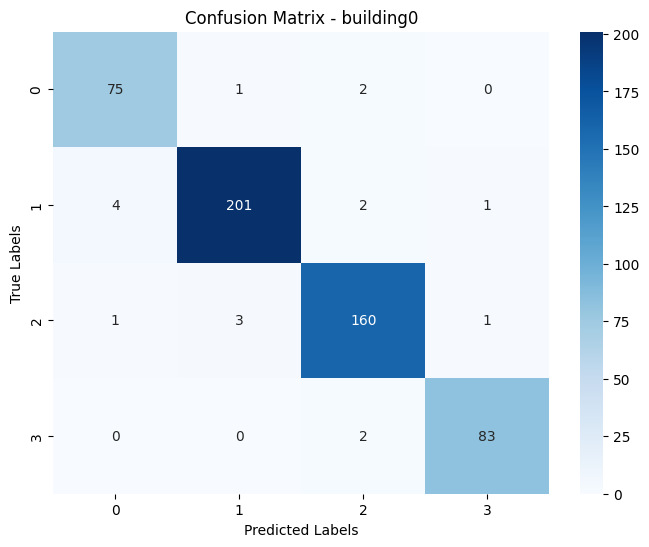

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title("Confusion Matrix - building0")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig('cm_b0.png', dpi=3000, bbox_inches='tight')
plt.show()

In [ ]:
xgb_model.save_model("/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_floor_classifier_B0.json")

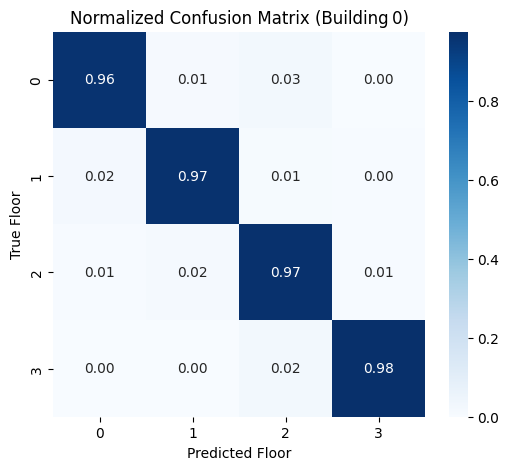

Mean absolute floor error: 0.04 ± 0.23 floors
– Adjacent‑floor confusions (|Δ|=1): 2.4%
– Non‑adjacent‑floor confusions (|Δ|>1): 0.7%


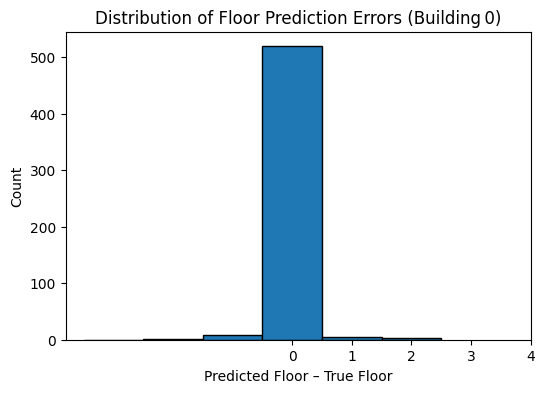


Classification Report:
              precision    recall  f1-score   support

     Floor 0       0.94      0.96      0.95        78
     Floor 1       0.98      0.97      0.97       208
     Floor 2       0.96      0.97      0.97       165
     Floor 3       0.98      0.98      0.98        85

    accuracy                           0.97       536
   macro avg       0.96      0.97      0.97       536
weighted avg       0.97      0.97      0.97       536



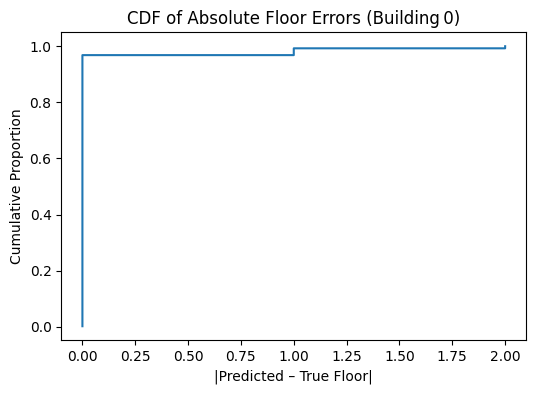

– <= 0 floor error: 96.8%
– <= 1 floor error: 99.3%
– <= 2 floor error: 100.0%

Top 10 most important WAPs for floor classification:
  WAP500: 0.1072
  WAP008: 0.0898
  WAP046: 0.0606
  WAP047: 0.0477
  WAP173: 0.0424
  WAP049: 0.0356
  WAP043: 0.0353
  WAP031: 0.0284
  WAP080: 0.0268
  WAP447: 0.0232


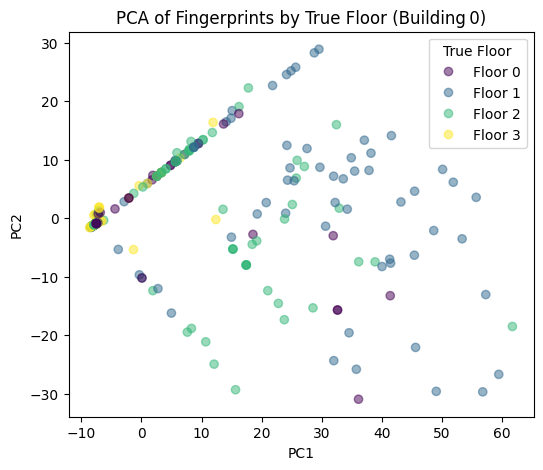

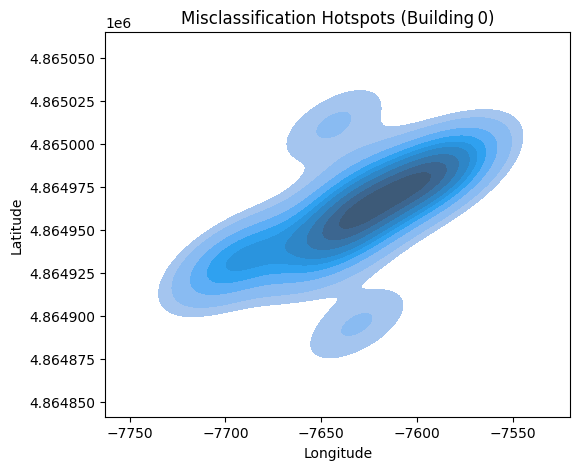

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_floor_classification(y_true, y_pred, floors, X_test_scaled=None,
                                 rssi_columns=None, model=None, df_coords=None,
                                 title=""):
    # 1. Confusion matrix (absolute and normalized)
    cm = confusion_matrix(y_true, y_pred, labels=floors)
    cm_norm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_norm, annot=True, fmt=".2f",
                xticklabels=floors, yticklabels=floors, cmap="Blues")
    plt.title(f"Normalized Confusion Matrix {title}")
    plt.xlabel("Predicted Floor"); plt.ylabel("True Floor")
    plt.show()

    # 2. Floor‐error statistics
    floor_err = y_pred - y_true
    abs_err   = np.abs(floor_err)
    mean_err  = abs_err.mean(); std_err = abs_err.std()
    adj_pct   = 100 * np.sum(abs_err == 1) / len(abs_err)
    nonadj_pct= 100 * np.sum(abs_err > 1) / len(abs_err)
    print(f"Mean absolute floor error: {mean_err:.2f} ± {std_err:.2f} floors")
    print(f"– Adjacent‑floor confusions (|Δ|=1): {adj_pct:.1f}%")
    print(f"– Non‑adjacent‑floor confusions (|Δ|>1): {nonadj_pct:.1f}%")

    # 3. Histogram of raw floor errors
    plt.figure(figsize=(6,4))
    bins = np.arange(floor_err.min()-1, floor_err.max()+2) - 0.5
    plt.hist(floor_err, bins=bins, edgecolor='k')
    plt.xticks(list(floors) + [floors[-1]+1])
    plt.title(f"Distribution of Floor Prediction Errors {title}")
    plt.xlabel("Predicted Floor – True Floor"); plt.ylabel("Count")
    plt.savefig('DIST_b0.png', dpi=3000, bbox_inches='tight')
    plt.show()

    # 4. Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred,
                                target_names=[f"Floor {f}" for f in floors]))

    # 5. CDF of absolute errors
    sorted_err = np.sort(abs_err)
    cdf = np.arange(1, len(sorted_err)+1) / len(sorted_err)
    plt.figure(figsize=(6,4))
    plt.step(sorted_err, cdf, where='post')
    plt.xlabel('|Predicted – True Floor|')
    plt.ylabel('Cumulative Proportion')
    plt.title(f'CDF of Absolute Floor Errors {title}')
    plt.savefig('CDF_b0.png', dpi=3000, bbox_inches='tight')
    plt.show()
    # Print a few key CDF points
    for d in [0,1,2]:
        pct = cdf[ np.searchsorted(sorted_err, d, 'right') - 1 ] * 100
        print(f"– <= {d} floor error: {pct:.1f}%")

    # 6. Feature importances (requires model & feature names)
    if model is not None and rssi_columns is not None:
        importances = model.feature_importances_
        idx = np.argsort(importances)[::-1][:10]  # top 10
        print("\nTop 10 most important WAPs for floor classification:")
        for i in idx:
            print(f"  {rssi_columns[i]}: {importances[i]:.4f}")

    # 7. PCA visualization (requires X_test_scaled)
    if X_test_scaled is not None:
        pca = PCA(n_components=2)
        proj = pca.fit_transform(X_test_scaled)
        plt.figure(figsize=(6,5))
        scatter = plt.scatter(proj[:,0], proj[:,1], c=y_true, alpha=0.5)
        plt.legend(handles=scatter.legend_elements()[0],
                   labels=[f"Floor {f}" for f in floors],
                   title="True Floor")
        plt.title(f"PCA of Fingerprints by True Floor {title}")
        plt.xlabel('PC1'); plt.ylabel('PC2')
        plt.savefig('PCA_b0.png', dpi=3000, bbox_inches='tight')
        plt.show()

    # 8. Spatial heatmap of misclassifications (requires df_coords with LONGITUDE, LATITUDE)
    if df_coords is not None:
        df = df_coords.copy()
        df['err'] = floor_err
        mis = df[df.err != 0]
        if not mis.empty:
            plt.figure(figsize=(6,5))
            sns.kdeplot(x='LONGITUDE', y='LATITUDE', data=mis,
                        shade=True, thresh=0.1)
            plt.title(f"Misclassification Hotspots {title}")
            plt.xlabel("Longitude"); plt.ylabel("Latitude")
            plt.savefig('Misclassification_b0.png', dpi=3000, bbox_inches='tight')
            plt.show()

# Usage for Building 0:
floors = [0,1,2,3]
analyze_floor_classification(
    y_true=y_test,
    y_pred=y_test_pred,
    floors=floors,
    X_test_scaled=X_test_scaled,
    rssi_columns=rssi_columns,
    model=xgb_model,
    df_coords=t_data,
    title="(Building 0)"
)


### building 1

#### XGBoost

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from keras.optimizers import AdamW
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import seaborn as sns

path_train = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building1/UjiindoorLoc_building_1/train_building_1.csv"
path_test = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building1/UjiindoorLoc_building_1/val_building_1.csv"


data = pd.read_csv(path_train)
data.replace(100, -104, inplace=True)

t_data = pd.read_csv(path_test)
t_data.replace(100, -104, inplace=True)

data.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,-104,-104,-104,-104,-104,-104,-104,-104,-104,-104,...,-104,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,-104,-104,-104,-104,-104,-104,-104,-104,-104,-104,...,-104,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,-104,-104,-104,-104,-104,-104,-104,-97,-104,-104,...,-104,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,-104,-104,-104,-104,-104,-104,-104,-104,-104,-104,...,-104,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,-104,-104,-104,-104,-104,-104,-104,-104,-104,-104,...,-104,-7533.8962,4.864939e+06,2,1,105,2,2,23,1371713841


In [ ]:
data.iloc[:,0:520].min().min()

-104

In [ ]:

rssi_columns = [col for col in data.columns if "WAP" in col]
rssi = data[rssi_columns].copy()
XYZ_Pos = data[["LONGITUDE",	"LATITUDE" ]]

x_test =  t_data[rssi_columns]
y_test =  t_data[["LONGITUDE",	"LATITUDE"]]

rssi[rssi <= -100] = np.nan
x_test[x_test <= -100] = np.nan

min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * rssi.shape[0])
valid_columns = rssi.columns[(rssi > -100).sum() > min_required_count]

rssi = rssi[valid_columns].fillna(-104)
x_test = x_test[valid_columns].fillna(-102)

print(f"Remaining APs after filtering: {len(valid_columns)}\n")

scaler_X = MinMaxScaler()
RSSI = scaler_X.fit_transform(rssi)
X_test = scaler_X.fit_transform(x_test)

scaler_y = MinMaxScaler()
xyz_Pos = scaler_y.fit_transform(XYZ_Pos)

X_train, X_val, y_train, y_val = train_test_split(RSSI, xyz_Pos, test_size=0.2, random_state=42)
# Display the shape of each split to verify
print("Shapes of the datasets after splitting:")
print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test set: X_test: {X_test.shape}, y_test: {y_test.shape}")



Remaining APs after filtering: 124

Shapes of the datasets after splitting:
Training set: X_train: (4156, 124), y_train: (4156, 2)
Validation set: X_val: (1040, 124), y_val: (1040, 2)
Test set: X_test: (307, 124), y_test: (307, 2)


In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest= xgb.DMatrix(X_test)



xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 8,
    'min_child_weight': 5,
    'subsample': 0.64,
    'colsample_bytree': 0.5,
    'n_estimators': 621,
    'seed': SEED
}

eval_results = {}

model_combined = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=9000,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=10,
    evals_result=eval_results,
    verbose_eval=50
)

[0]	train-rmse:0.26183	validation-rmse:0.26550
[50]	train-rmse:0.16806	validation-rmse:0.17040
[100]	train-rmse:0.11179	validation-rmse:0.11331
[150]	train-rmse:0.07876	validation-rmse:0.08005
[200]	train-rmse:0.05970	validation-rmse:0.06108
[250]	train-rmse:0.04888	validation-rmse:0.05062
[300]	train-rmse:0.04256	validation-rmse:0.04474
[350]	train-rmse:0.03870	validation-rmse:0.04130
[400]	train-rmse:0.03609	validation-rmse:0.03910
[450]	train-rmse:0.03432	validation-rmse:0.03763
[500]	train-rmse:0.03312	validation-rmse:0.03665
[550]	train-rmse:0.03225	validation-rmse:0.03600
[600]	train-rmse:0.03151	validation-rmse:0.03545
[650]	train-rmse:0.03094	validation-rmse:0.03506
[700]	train-rmse:0.03042	validation-rmse:0.03470
[750]	train-rmse:0.02997	validation-rmse:0.03438
[800]	train-rmse:0.02951	validation-rmse:0.03408
[850]	train-rmse:0.02912	validation-rmse:0.03382
[900]	train-rmse:0.02877	validation-rmse:0.03360
[950]	train-rmse:0.02844	validation-rmse:0.03340
[1000]	train-rmse:0.028

In [ ]:
predictions = model_combined.predict(dtest)
predicted_coords_xgb_original = scaler_y.inverse_transform(predictions)
y_test_original =  t_data[["LONGITUDE",	"LATITUDE"]].values

mse_xgb = mean_squared_error(y_test_original, predicted_coords_xgb_original)
mae_xgb = mean_absolute_error(y_test_original, predicted_coords_xgb_original)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test_original, predicted_coords_xgb_original)
success_radius = 5
distances_2 = np.sqrt(np.sum((y_test_original - predicted_coords_xgb_original) ** 2, axis=1))
success_rate_xgb = np.mean(distances_2 <= success_radius) * 100
localization_error_xgb = np.mean(distances_2)

print(f"Mean Squared Error (MSE): {mse_xgb:.4f}")
print(f"Mean Absolute Error (MAE): {mae_xgb:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.4f}")
print(f"R2 Score: {r2_xgb:.4f}")
print(f"Localization Success Rate (within {success_radius} meters): {success_rate_xgb:.2f}%")
print(f"Average Localization Error: {localization_error_xgb:.4f} meters")

Mean Squared Error (MSE): 119.7784
Mean Absolute Error (MAE): 7.8504
Root Mean Squared Error (RMSE): 10.9443
R2 Score: 0.9203
Localization Success Rate (within 5 meters): 19.87%
Average Localization Error: 12.5466 meters


In [ ]:
model_combined.save_model("/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_b1.json")

#### Indoor Localization XGBoost 10 Run Stability Analysis

Final Metrics for UJIIndoorLoc Building 0 (across runs):\
MAE (m): 7.849 ± 0.082\
RMSE (m): 11.042 ± 0.102\
R²: 0.918 ± 0.002\
Success Rate (%): 20.130 ± 1.268\
Avg. Localization Error (m): 12.572 ± 0.136\
MSE (m): 121.947 ± 2.256

In [10]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from keras.optimizers import AdamW
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import seaborn as sns

path_train = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building1/UjiindoorLoc_building_1/train_building_1.csv"
path_test = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building1/UjiindoorLoc_building_1/val_building_1.csv"


data = pd.read_csv(path_train)
data.replace(100, -104, inplace=True)
t_data = pd.read_csv(path_test)
t_data.replace(100, -102, inplace=True)
rssi_columns = [col for col in data.columns if "WAP" in col]   #data.iloc[:,0:520].columns
rssi = data[rssi_columns].copy()
XYZ_Pos = data[["LONGITUDE",	"LATITUDE" ]]
x_test =  t_data[rssi_columns]
y_test =  t_data[["LONGITUDE",	"LATITUDE"]]
rssi[rssi <= -100] = np.nan
x_test[x_test <= -100] = np.nan
min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * rssi.shape[0])
valid_columns = rssi.columns[(rssi > -100).sum() > min_required_count]
rssi = rssi[valid_columns].fillna(-104)
x_test = x_test[valid_columns].fillna(-102)
print(f"Remaining APs after filtering: {len(valid_columns)}\n")
scaler_X = MinMaxScaler()
RSSI = scaler_X.fit_transform(rssi)
X_test = scaler_X.fit_transform(x_test)
scaler_y = MinMaxScaler()
xyz_Pos = scaler_y.fit_transform(XYZ_Pos)

Remaining APs after filtering: 124



In [11]:
import random

NUM_RUNS = 10  # Or 5 for quicker testing

# Storage for metrics
mae_list = []
rmse_list = []
r2_list = []
mse_list = []

success_rate_list = []
avg_loc_error_list = []

for run in range(NUM_RUNS):
    print(f"\nRun {run + 1}/{NUM_RUNS}")

    seed = random.randint(0, 10000)
    np.random.seed(seed)

    # Re-split training/validation data with a different random seed each time
    X_train, X_val, y_train, y_val = train_test_split(RSSI, xyz_Pos, test_size=0.2, random_state=seed)

    # Prepare DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    xgb_params = {
    'objective': 'reg:squarederror',  #  squarederror => MSE
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 8,
    'min_child_weight': 5,
    'subsample': 0.64,
    'colsample_bytree': 0.5,
    'n_estimators': 621,
    'lambda':0.0,  # Default value, you can tune this λ∈[0.1,1,5,10].
    'alpha':0,  # Default value, you can tune this α∈[0.1,1,5,10].
    'gamma': 0,  # Default value; consider tuning this γ∈[0,0.1,0.5,1,5]
    'seed': seed
    }
    # xgb_params['seed'] = seed

    model_combined = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=9000,
        evals=[(dtrain, 'train'), (dval, 'validation')],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    # Predictions and inverse transform
    y_pred_scaled = model_combined.predict(dtest)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = y_test  # not scaled in this version

    # Calculate 2D localization metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # 5m success rate
    distances = np.linalg.norm(y_true - y_pred, axis=1)
    success_rate = np.mean(distances <= 5) * 100
    avg_loc_error = np.mean(distances)

    # Store metrics
    mae_list.append(mae)
    rmse_list.append(rmse)
    r2_list.append(r2)
    mse_list.append(mse)
    success_rate_list.append(success_rate)
    avg_loc_error_list.append(avg_loc_error)

# === Summary ===
def summarize(name, values):
    print(f"{name}: {np.mean(values):.3f} ± {np.std(values):.3f}")

print("\n Final Metrics for UJIIndoorLoc Building 0 (across runs):")
summarize("MAE (m)", mae_list)
summarize("RMSE (m)", rmse_list)
summarize("R²", r2_list)
summarize("Success Rate (%)", success_rate_list)
summarize("Avg. Localization Error (m)", avg_loc_error_list)
summarize("MSE (m)", mse_list)


Run 1/10

Run 2/10

Run 3/10

Run 4/10

Run 5/10

Run 6/10

Run 7/10

Run 8/10

Run 9/10

Run 10/10

 Final Metrics for UJIIndoorLoc Building 0 (across runs):
MAE (m): 7.849 ± 0.082
RMSE (m): 11.042 ± 0.102
R²: 0.918 ± 0.002
Success Rate (%): 20.130 ± 1.268
Avg. Localization Error (m): 12.572 ± 0.136
MSE (m): 121.947 ± 2.256


#### CLASSIFICATION

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler

path_train = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building1/UjiindoorLoc_building_1/train_building_1.csv"
path_test = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building1/UjiindoorLoc_building_1/val_building_1.csv"


data = pd.read_csv(path_train)            # min rssi = -103
data.replace(100, -104, inplace=True)

t_data = pd.read_csv(path_test)
t_data.replace(100, -104, inplace=True)


data.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,-104,-104,-104,-104,-104,-104,-104,-104,-104,-104,...,-104,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,-104,-104,-104,-104,-104,-104,-104,-104,-104,-104,...,-104,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,-104,-104,-104,-104,-104,-104,-104,-97,-104,-104,...,-104,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,-104,-104,-104,-104,-104,-104,-104,-104,-104,-104,...,-104,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,-104,-104,-104,-104,-104,-104,-104,-104,-104,-104,...,-104,-7533.8962,4.864939e+06,2,1,105,2,2,23,1371713841


In [ ]:
data["FLOOR"].unique()

array([2, 0, 1, 3])

In [ ]:
rssi_columns = [col for col in data.columns if "WAP" in col]  # Assume columns with 'WAP' are the RSSI columns

rssi = data[rssi_columns]
X_test = t_data[rssi_columns]
y = data["FLOOR"]
y_test = t_data["FLOOR"]
scaler_X = MinMaxScaler()
RSSI = scaler_X.fit_transform(rssi)
X_test_scaled = scaler_X.transform(X_test)
X_train, X_val, y_train, y_val = train_test_split(RSSI, y, test_size=0.2, random_state=42)

In [ ]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,  # 4 floors (0, 1, 2, 3)
    max_depth=6,
    learning_rate=0.1,
    n_estimators=1000,
    eval_metric='mlogloss',
    use_label_encoder=False
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    # early_stopping_rounds=50,
    verbose=50
)

[0]	validation_0-mlogloss:1.23956
[50]	validation_0-mlogloss:0.04948
[100]	validation_0-mlogloss:0.01573
[150]	validation_0-mlogloss:0.01173
[200]	validation_0-mlogloss:0.01037
[250]	validation_0-mlogloss:0.00996
[300]	validation_0-mlogloss:0.00944
[350]	validation_0-mlogloss:0.00918
[400]	validation_0-mlogloss:0.00901
[450]	validation_0-mlogloss:0.00894
[500]	validation_0-mlogloss:0.00895
[550]	validation_0-mlogloss:0.00896
[600]	validation_0-mlogloss:0.00896
[650]	validation_0-mlogloss:0.00894
[700]	validation_0-mlogloss:0.00894
[750]	validation_0-mlogloss:0.00890
[800]	validation_0-mlogloss:0.00884
[850]	validation_0-mlogloss:0.00884
[900]	validation_0-mlogloss:0.00885
[950]	validation_0-mlogloss:0.00880
[999]	validation_0-mlogloss:0.00877


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

In [ ]:
# Make predictions on validation set
y_val_pred = xgb_model.predict(X_val)
y_test_pred = xgb_model.predict(X_test_scaled)

# Evaluate model performance on the validation set
# print("Validation Set Performance:")
# print("Accuracy:", accuracy_score(y_val, y_val_pred))
# print("Classification Report:\n", classification_report(y_val, y_val_pred))

# Evaluate model performance on the test set
print("Test Set Performance:")
print("Accuracy:", accuracy_score(y_test, y_test_pred)*100)
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Test Set Performance:
Accuracy: 74.9185667752443
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.70      0.74        30
           1       0.94      0.59      0.73       143
           2       0.63      0.93      0.75        87
           3       0.70      0.91      0.80        47

    accuracy                           0.75       307
   macro avg       0.76      0.79      0.75       307
weighted avg       0.80      0.75      0.75       307



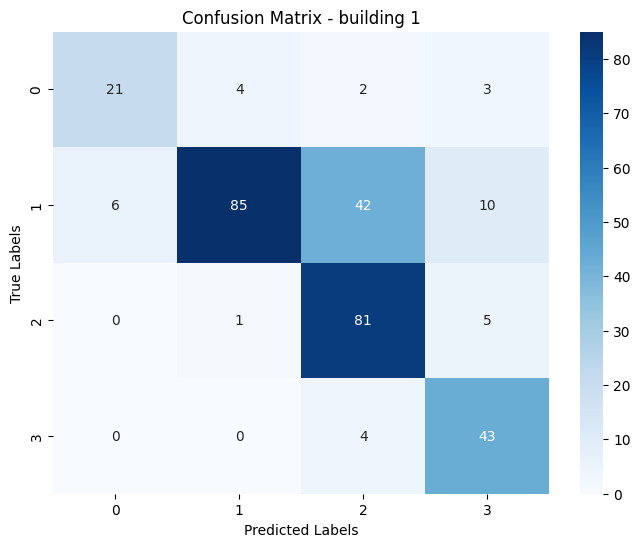

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title("Confusion Matrix - building 1")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig('cm_b1.png', dpi=3000, bbox_inches='tight')

plt.show()

In [ ]:
xgb_model.save_model("/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_floor_classifier_B1.json")

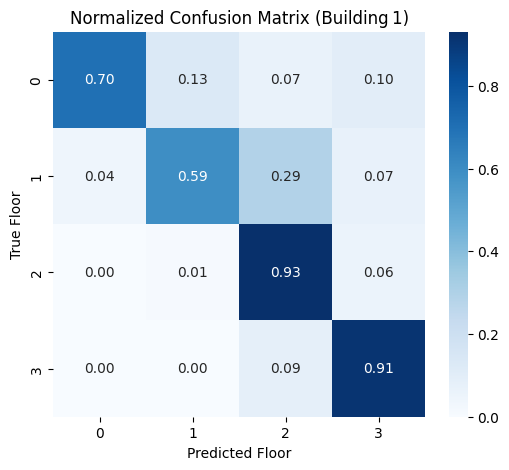

Mean absolute floor error: 0.31 ± 0.59 floors
– Adjacent‑floor confusions (|Δ|=1): 20.2%
– Non‑adjacent‑floor confusions (|Δ|>1): 4.9%


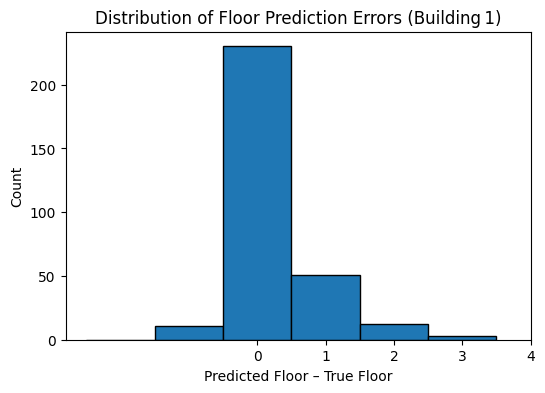


Classification Report:
              precision    recall  f1-score   support

     Floor 0       0.78      0.70      0.74        30
     Floor 1       0.94      0.59      0.73       143
     Floor 2       0.63      0.93      0.75        87
     Floor 3       0.70      0.91      0.80        47

    accuracy                           0.75       307
   macro avg       0.76      0.79      0.75       307
weighted avg       0.80      0.75      0.75       307



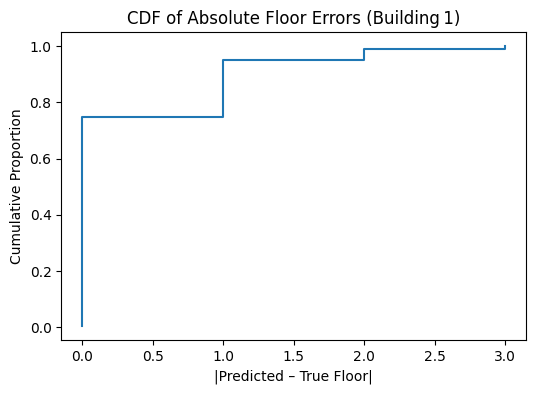

– <= 0 floor error: 74.9%
– <= 1 floor error: 95.1%
– <= 2 floor error: 99.0%

Top 10 most important WAPs for floor classification:
  WAP367: 0.0531
  WAP055: 0.0389
  WAP176: 0.0318
  WAP140: 0.0311
  WAP136: 0.0290
  WAP184: 0.0286
  WAP104: 0.0285
  WAP008: 0.0278
  WAP119: 0.0252
  WAP120: 0.0232


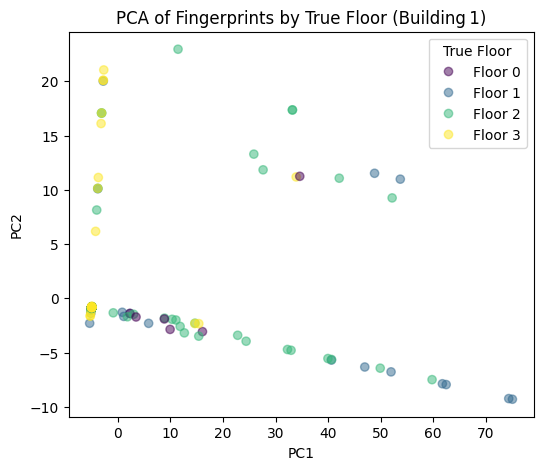

/tmp/ipython-input-12-421421948.py:90: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='LONGITUDE', y='LATITUDE', data=mis,


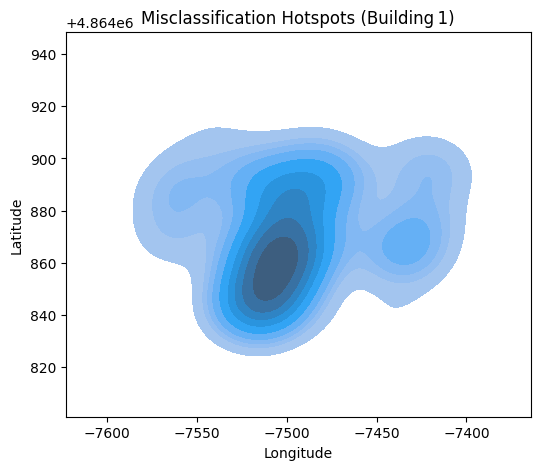

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_floor_classification(y_true, y_pred, floors, X_test_scaled=None,
                                 rssi_columns=None, model=None, df_coords=None,
                                 title=""):
    # 1. Confusion matrix (absolute and normalized)
    cm = confusion_matrix(y_true, y_pred, labels=floors)
    cm_norm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_norm, annot=True, fmt=".2f",
                xticklabels=floors, yticklabels=floors, cmap="Blues")
    plt.title(f"Normalized Confusion Matrix {title}")
    plt.xlabel("Predicted Floor"); plt.ylabel("True Floor")
    plt.show()

    # 2. Floor‐error statistics
    floor_err = y_pred - y_true
    abs_err   = np.abs(floor_err)
    mean_err  = abs_err.mean(); std_err = abs_err.std()
    adj_pct   = 100 * np.sum(abs_err == 1) / len(abs_err)
    nonadj_pct= 100 * np.sum(abs_err > 1) / len(abs_err)
    print(f"Mean absolute floor error: {mean_err:.2f} ± {std_err:.2f} floors")
    print(f"– Adjacent‑floor confusions (|Δ|=1): {adj_pct:.1f}%")
    print(f"– Non‑adjacent‑floor confusions (|Δ|>1): {nonadj_pct:.1f}%")

    # 3. Histogram of raw floor errors
    plt.figure(figsize=(6,4))
    bins = np.arange(floor_err.min()-1, floor_err.max()+2) - 0.5
    plt.hist(floor_err, bins=bins, edgecolor='k')
    plt.xticks(list(floors) + [floors[-1]+1])
    plt.title(f"Distribution of Floor Prediction Errors {title}")
    plt.xlabel("Predicted Floor – True Floor"); plt.ylabel("Count")
    plt.savefig('DIST_b1.png', dpi=3000, bbox_inches='tight')
    plt.show()

    # 4. Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred,
                                target_names=[f"Floor {f}" for f in floors]))

    # 5. CDF of absolute errors
    sorted_err = np.sort(abs_err)
    cdf = np.arange(1, len(sorted_err)+1) / len(sorted_err)
    plt.figure(figsize=(6,4))
    plt.step(sorted_err, cdf, where='post')
    plt.xlabel('|Predicted – True Floor|')
    plt.ylabel('Cumulative Proportion')
    plt.title(f'CDF of Absolute Floor Errors {title}')
    plt.savefig('CDF_b1.png', dpi=3000, bbox_inches='tight')
    plt.show()
    # Print a few key CDF points
    for d in [0,1,2]:
        pct = cdf[ np.searchsorted(sorted_err, d, 'right') - 1 ] * 100
        print(f"– <= {d} floor error: {pct:.1f}%")

    # 6. Feature importances (requires model & feature names)
    if model is not None and rssi_columns is not None:
        importances = model.feature_importances_
        idx = np.argsort(importances)[::-1][:10]  # top 10
        print("\nTop 10 most important WAPs for floor classification:")
        for i in idx:
            print(f"  {rssi_columns[i]}: {importances[i]:.4f}")

    # 7. PCA visualization (requires X_test_scaled)
    if X_test_scaled is not None:
        pca = PCA(n_components=2)
        proj = pca.fit_transform(X_test_scaled)
        plt.figure(figsize=(6,5))
        scatter = plt.scatter(proj[:,0], proj[:,1], c=y_true, alpha=0.5)
        plt.legend(handles=scatter.legend_elements()[0],
                   labels=[f"Floor {f}" for f in floors],
                   title="True Floor")
        plt.title(f"PCA of Fingerprints by True Floor {title}")
        plt.xlabel('PC1'); plt.ylabel('PC2')
        plt.savefig('PCA_b1.png', dpi=3000, bbox_inches='tight')
        plt.show()

    # 8. Spatial heatmap of misclassifications (requires df_coords with LONGITUDE, LATITUDE)
    if df_coords is not None:
        df = df_coords.copy()
        df['err'] = floor_err
        mis = df[df.err != 0]
        if not mis.empty:
            plt.figure(figsize=(6,5))
            sns.kdeplot(x='LONGITUDE', y='LATITUDE', data=mis,
                        shade=True, thresh=0.1)
            plt.title(f"Misclassification Hotspots {title}")
            plt.xlabel("Longitude"); plt.ylabel("Latitude")
            plt.savefig('Misclassification_b1.png', dpi=3000, bbox_inches='tight')
            plt.show()

# Usage for Building 1:
floors = [0,1,2,3]
analyze_floor_classification(
    y_true=y_test,
    y_pred=y_test_pred,
    floors=floors,
    X_test_scaled=X_test_scaled,
    rssi_columns=rssi_columns,
    model=xgb_model,
    df_coords=t_data,
    title="(Building 1)"
)


### building 2

#### XGBoost

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from keras.optimizers import AdamW
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import seaborn as sns

path_train = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building2/UjiindoorLoc_building_2/train_building_2.csv"
path_test = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building2/UjiindoorLoc_building_2/val_building_2.csv"


data = pd.read_csv(path_train)            # min rssi = -101
data.replace(100, -105, inplace=True)

t_data = pd.read_csv(path_test)
t_data.replace(100, -105, inplace=True)

data.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,-105,-105,-105,-105,-105,-105,-105,-105,-105,-105,...,-105,-7331.748000,4.864767e+06,3,2,247,2,2,23,1371716690
1,-105,-105,-105,-105,-105,-105,-105,-105,-105,-105,...,-105,-7331.400500,4.864768e+06,3,2,248,2,2,23,1371716637
2,-105,-105,-105,-105,-105,-105,-105,-105,-105,-105,...,-105,-7327.492165,4.864767e+06,3,2,247,1,2,23,1371716719
3,-105,-105,-105,-105,-105,-105,-105,-105,-105,-105,...,-105,-7336.700400,4.864764e+06,3,2,246,2,2,23,1371716762
4,-105,-105,-105,-105,-105,-105,-105,-105,-105,-105,...,-105,-7337.394800,4.864763e+06,3,2,245,2,2,23,1371716797


In [ ]:
data.iloc[:,0:520].min().min()

-105

In [ ]:

rssi_columns = [col for col in data.columns if "WAP" in col]

rssi = data[rssi_columns].copy()
XYZ_Pos = data[["LONGITUDE",	"LATITUDE" ]]

x_test =  t_data[rssi_columns]
y_test =  t_data[["LONGITUDE",	"LATITUDE"]]

rssi[rssi <= -100] = np.nan
x_test[x_test <= -100] = np.nan

min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * rssi.shape[0])
valid_columns = rssi.columns[(rssi > -100).sum() > min_required_count]

rssi = rssi[valid_columns].fillna(-105)
x_test = x_test[valid_columns].fillna(-102)

print(f"Remaining APs after filtering: {len(valid_columns)}\n")

scaler_X = MinMaxScaler()
RSSI = scaler_X.fit_transform(rssi)
X_test = scaler_X.fit_transform(x_test)

scaler_y = MinMaxScaler()
xyz_Pos = scaler_y.fit_transform(XYZ_Pos)
#################################################################################
# from sklearn.preprocessing import StandardScaler

# # Z-Score Normalization for RSSI
# scaler_X = StandardScaler()
# RSSI = scaler_X.fit_transform(rssi)  # Apply Z-Score to RSSI data
# X_test = scaler_X.transform(x_test)  # Apply Z-Score to test data

# # Z-Score Normalization for XYZ_Pos
# scaler_y = StandardScaler()
# xyz_Pos = scaler_y.fit_transform(XYZ_Pos)  # Apply Z-Score to position data

#####################################################################################
X_train, X_val, y_train, y_val = train_test_split(RSSI, xyz_Pos, test_size=0.2, random_state=42)

print("Shapes of the datasets after splitting:")
print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test set: X_test: {X_test.shape}, y_test: {y_test.shape}")



Remaining APs after filtering: 71

Shapes of the datasets after splitting:
Training set: X_train: (7593, 71), y_train: (7593, 2)
Validation set: X_val: (1899, 71), y_val: (1899, 2)
Test set: X_test: (268, 71), y_test: (268, 2)


In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest= xgb.DMatrix(X_test)



xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 8,
    'min_child_weight': 5,
    'subsample': 0.64,
    'colsample_bytree': 0.5,
    'n_estimators': 621,
    'seed': SEED
}

eval_results = {}

model_combined = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=9000,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=10,
    evals_result=eval_results,
    verbose_eval=50
)

[0]	train-rmse:0.25134	validation-rmse:0.25354
[50]	train-rmse:0.16820	validation-rmse:0.17114
[100]	train-rmse:0.11776	validation-rmse:0.12158
[150]	train-rmse:0.08711	validation-rmse:0.09174
[200]	train-rmse:0.06866	validation-rmse:0.07410
[250]	train-rmse:0.05771	validation-rmse:0.06369
[300]	train-rmse:0.05114	validation-rmse:0.05758
[350]	train-rmse:0.04678	validation-rmse:0.05367
[400]	train-rmse:0.04346	validation-rmse:0.05084
[450]	train-rmse:0.04111	validation-rmse:0.04895
[500]	train-rmse:0.03932	validation-rmse:0.04754
[550]	train-rmse:0.03791	validation-rmse:0.04645
[600]	train-rmse:0.03687	validation-rmse:0.04565
[650]	train-rmse:0.03600	validation-rmse:0.04503
[700]	train-rmse:0.03530	validation-rmse:0.04457
[750]	train-rmse:0.03463	validation-rmse:0.04415
[800]	train-rmse:0.03408	validation-rmse:0.04379
[850]	train-rmse:0.03358	validation-rmse:0.04348
[900]	train-rmse:0.03314	validation-rmse:0.04321
[950]	train-rmse:0.03269	validation-rmse:0.04294
[1000]	train-rmse:0.032

In [ ]:
# Get predictions
predictions =model_combined.predict(dtest)
predicted_coords_xgb_original = scaler_y.inverse_transform(predictions)
y_test_original =  t_data[["LONGITUDE",	"LATITUDE"]].values

mse_xgb = mean_squared_error(y_test_original, predicted_coords_xgb_original)
mae_xgb = mean_absolute_error(y_test_original, predicted_coords_xgb_original)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test_original, predicted_coords_xgb_original)
success_radius = 5
distances_3 = np.sqrt(np.sum((y_test_original - predicted_coords_xgb_original) ** 2, axis=1))
success_rate_xgb = np.mean(distances_3 <= success_radius) * 100
localization_error_xgb = np.mean(distances_3)

print(f"Mean Squared Error (MSE): {mse_xgb:.4f}")
print(f"Mean Absolute Error (MAE): {mae_xgb:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.4f}")
print(f"R2 Score: {r2_xgb:.4f}")
print(f"Localization Success Rate (within {success_radius} meters): {success_rate_xgb:.2f}%")
print(f"Average Localization Error: {localization_error_xgb:.4f} meters")


Mean Squared Error (MSE): 127.9687
Mean Absolute Error (MAE): 8.1742
Root Mean Squared Error (RMSE): 11.3123
R2 Score: 0.8586
Localization Success Rate (within 5 meters): 17.16%
Average Localization Error: 12.8823 meters


In [ ]:
model_combined.save_model("/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_b2.json")

#### Indoor Localization XGBoost 10 Run Stability Analysis

Final Metrics for UJIIndoorLoc Building 0 (across runs):\
MAE (m): 8.154 ± 0.072\
RMSE (m): 11.297 ± 0.102\
R²: 0.859 ± 0.002\
Success Rate (%): 17.985 ± 0.797\
Avg. Localization Error (m): 12.852 ± 0.122\
MSE (m): 127.631 ± 2.293

In [12]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from keras.optimizers import AdamW
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import seaborn as sns

path_train = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building2/UjiindoorLoc_building_2/train_building_2.csv"
path_test = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building2/UjiindoorLoc_building_2/val_building_2.csv"
data = pd.read_csv(path_train)
data.replace(100, -105, inplace=True)

t_data = pd.read_csv(path_test)
t_data.replace(100, -102, inplace=True)
rssi_columns = [col for col in data.columns if "WAP" in col]
rssi = data[rssi_columns].copy()
XYZ_Pos = data[["LONGITUDE",	"LATITUDE" ]]
x_test =  t_data[rssi_columns]
y_test =  t_data[["LONGITUDE",	"LATITUDE"]]
rssi[rssi <= -100] = np.nan
x_test[x_test <= -100] = np.nan
min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * rssi.shape[0])
valid_columns = rssi.columns[(rssi > -100).sum() > min_required_count]
rssi = rssi[valid_columns].fillna(-105)
x_test = x_test[valid_columns].fillna(-102)
print(f"Remaining APs after filtering: {len(valid_columns)}\n")
scaler_X = MinMaxScaler()
RSSI = scaler_X.fit_transform(rssi)
X_test = scaler_X.fit_transform(x_test)
scaler_y = MinMaxScaler()
xyz_Pos = scaler_y.fit_transform(XYZ_Pos)

Remaining APs after filtering: 71



In [13]:
import random

NUM_RUNS = 10  # Or 5 for quicker testing

# Storage for metrics
mae_list = []
rmse_list = []
r2_list = []
success_rate_list = []
avg_loc_error_list = []
mse_list = []

for run in range(NUM_RUNS):
    print(f"\nRun {run + 1}/{NUM_RUNS}")

    seed = random.randint(0, 10000)
    np.random.seed(seed)

    # Re-split training/validation data with a different random seed each time
    X_train, X_val, y_train, y_val = train_test_split(RSSI, xyz_Pos, test_size=0.2, random_state=seed)

    # Prepare DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    xgb_params = {
    'objective': 'reg:squarederror',  #  squarederror => MSE
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 8,
    'min_child_weight': 5,
    'subsample': 0.64,
    'colsample_bytree': 0.5,
    'n_estimators': 621,
    'lambda':0.0,  # Default value, you can tune this λ∈[0.1,1,5,10].
    'alpha':0,  # Default value, you can tune this α∈[0.1,1,5,10].
    'gamma': 0,  # Default value; consider tuning this γ∈[0,0.1,0.5,1,5]
    'seed': seed
    }
    # xgb_params['seed'] = seed

    model_combined = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=9000,
        evals=[(dtrain, 'train'), (dval, 'validation')],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    # Predictions and inverse transform
    y_pred_scaled = model_combined.predict(dtest)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = y_test  # not scaled in this version

    # Calculate 2D localization metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # 5m success rate
    distances = np.linalg.norm(y_true - y_pred, axis=1)
    success_rate = np.mean(distances <= 5) * 100
    avg_loc_error = np.mean(distances)

    # Store metrics
    mae_list.append(mae)
    rmse_list.append(rmse)
    mse_list.append(mse)
    r2_list.append(r2)
    success_rate_list.append(success_rate)
    avg_loc_error_list.append(avg_loc_error)

# === Summary ===
def summarize(name, values):
    print(f"{name}: {np.mean(values):.3f} ± {np.std(values):.3f}")

print("\nFinal Metrics for UJIIndoorLoc Building 0 (across runs):")
summarize("MAE (m)", mae_list)
summarize("RMSE (m)", rmse_list)
summarize("R²", r2_list)
summarize("Success Rate (%)", success_rate_list)
summarize("Avg. Localization Error (m)", avg_loc_error_list)
summarize("MSE (m)", mse_list)


Run 1/10

Run 2/10

Run 3/10

Run 4/10

Run 5/10

Run 6/10

Run 7/10

Run 8/10

Run 9/10

Run 10/10

Final Metrics for UJIIndoorLoc Building 0 (across runs):
MAE (m): 8.154 ± 0.072
RMSE (m): 11.297 ± 0.102
R²: 0.859 ± 0.002
Success Rate (%): 17.985 ± 0.797
Avg. Localization Error (m): 12.852 ± 0.122
MSE (m): 127.631 ± 2.293


#### Classification

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler

# Load your training and validation datasets
path_train = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building2/UjiindoorLoc_building_2/train_building_2.csv"
path_test = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building2/UjiindoorLoc_building_2/val_building_2.csv"


data = pd.read_csv(path_train)            # min rssi = -101
data.replace(100, -105, inplace=True)

t_data = pd.read_csv(path_test)
t_data.replace(100, -105, inplace=True)


data.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,-105,-105,-105,-105,-105,-105,-105,-105,-105,-105,...,-105,-7331.748000,4.864767e+06,3,2,247,2,2,23,1371716690
1,-105,-105,-105,-105,-105,-105,-105,-105,-105,-105,...,-105,-7331.400500,4.864768e+06,3,2,248,2,2,23,1371716637
2,-105,-105,-105,-105,-105,-105,-105,-105,-105,-105,...,-105,-7327.492165,4.864767e+06,3,2,247,1,2,23,1371716719
3,-105,-105,-105,-105,-105,-105,-105,-105,-105,-105,...,-105,-7336.700400,4.864764e+06,3,2,246,2,2,23,1371716762
4,-105,-105,-105,-105,-105,-105,-105,-105,-105,-105,...,-105,-7337.394800,4.864763e+06,3,2,245,2,2,23,1371716797


In [ ]:
# Extract the necessary columns
rssi_columns = [col for col in data.columns if "WAP" in col]  # Assume columns with 'WAP' are the RSSI columns

rssi = data[rssi_columns]
X_test = t_data[rssi_columns]
y = data["FLOOR"]  # Target variable: the floor label
y_test = t_data["FLOOR"]
# Normalize RSSI values using MinMaxScaler
scaler_X = MinMaxScaler()
RSSI = scaler_X.fit_transform(rssi)
X_test_scaled = scaler_X.transform(X_test)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(RSSI, y, test_size=0.2, random_state=42)


In [ ]:
data["FLOOR"].unique()

array([3, 2, 4, 1, 0])

In [ ]:
# Initialize XGBoost model for classification
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Multi-class classification
    num_class=5,  # 5 floors (0, 1, 2, 3,4)
    max_depth=6,
    learning_rate=0.1,
    n_estimators=1000,  # Large number of trees to allow early stopping
    eval_metric='mlogloss',
    use_label_encoder=False
)

# Training the model with validation set and early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  # Validation set for monitoring during training
    # early_stopping_rounds=50,   # Stop training if validation metric doesn't improve for 50 rounds
    verbose=50  # Print out evaluation results
)

[0]	validation_0-mlogloss:1.40445
[50]	validation_0-mlogloss:0.03853
[100]	validation_0-mlogloss:0.01571
[150]	validation_0-mlogloss:0.01387
[200]	validation_0-mlogloss:0.01335
[250]	validation_0-mlogloss:0.01302
[300]	validation_0-mlogloss:0.01290
[350]	validation_0-mlogloss:0.01304
[400]	validation_0-mlogloss:0.01301
[450]	validation_0-mlogloss:0.01304
[500]	validation_0-mlogloss:0.01308
[550]	validation_0-mlogloss:0.01307
[600]	validation_0-mlogloss:0.01317
[650]	validation_0-mlogloss:0.01328
[700]	validation_0-mlogloss:0.01333
[750]	validation_0-mlogloss:0.01340
[800]	validation_0-mlogloss:0.01347
[850]	validation_0-mlogloss:0.01353
[900]	validation_0-mlogloss:0.01356
[950]	validation_0-mlogloss:0.01362
[999]	validation_0-mlogloss:0.01363


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [ ]:
# Make predictions on validation set
y_val_pred = xgb_model.predict(X_val)
y_test_pred = xgb_model.predict(X_test_scaled)

# Evaluate model performance on the validation set
# print("Validation Set Performance:")
# print("Accuracy:", accuracy_score(y_val, y_val_pred))
# print("Classification Report:\n", classification_report(y_val, y_val_pred))

# Evaluate model performance on the test set
print("Test Set Performance:")
print("Accuracy:", accuracy_score(y_test, y_test_pred)*100)
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Test Set Performance:
Accuracy: 92.91044776119402
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88        24
           1       0.93      0.97      0.95       111
           2       0.98      0.91      0.94        54
           3       0.85      1.00      0.92        40
           4       1.00      0.79      0.89        39

    accuracy                           0.93       268
   macro avg       0.93      0.91      0.91       268
weighted avg       0.93      0.93      0.93       268



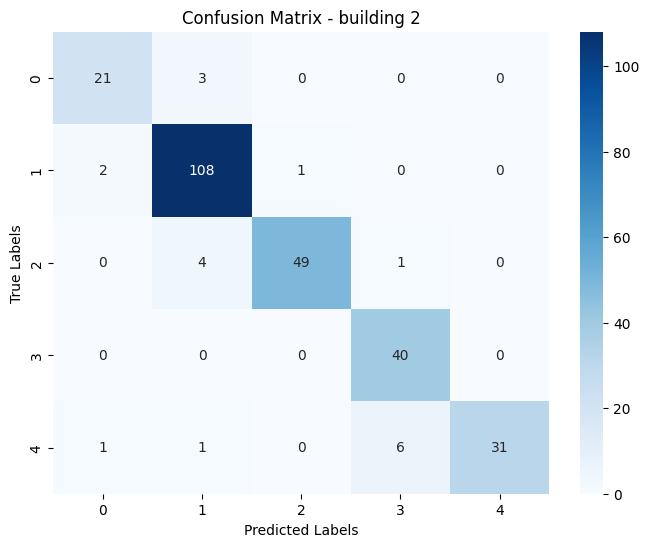

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3,4], yticklabels=[0, 1, 2, 3,4])
plt.title("Confusion Matrix - building 2")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig('cm_b2.png', dpi=3000, bbox_inches='tight')

plt.show()

In [ ]:
xgb_model.save_model("/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_floor_classifier_B2.json")

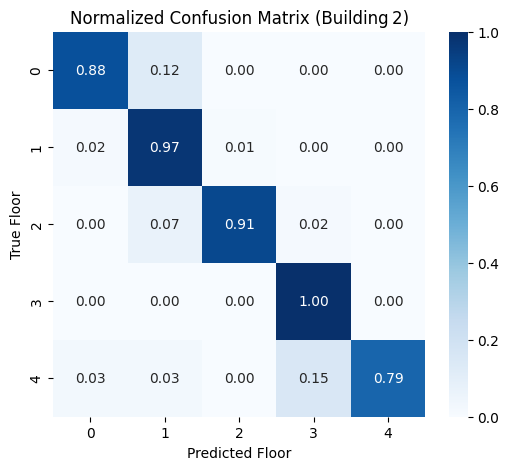

Mean absolute floor error: 0.09 ± 0.39 floors
– Adjacent‑floor confusions (|Δ|=1): 6.3%
– Non‑adjacent‑floor confusions (|Δ|>1): 0.7%


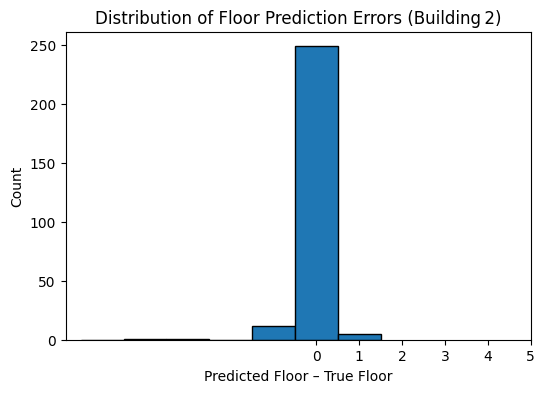


Classification Report:
              precision    recall  f1-score   support

     Floor 0       0.88      0.88      0.88        24
     Floor 1       0.93      0.97      0.95       111
     Floor 2       0.98      0.91      0.94        54
     Floor 3       0.85      1.00      0.92        40
     Floor 4       1.00      0.79      0.89        39

    accuracy                           0.93       268
   macro avg       0.93      0.91      0.91       268
weighted avg       0.93      0.93      0.93       268



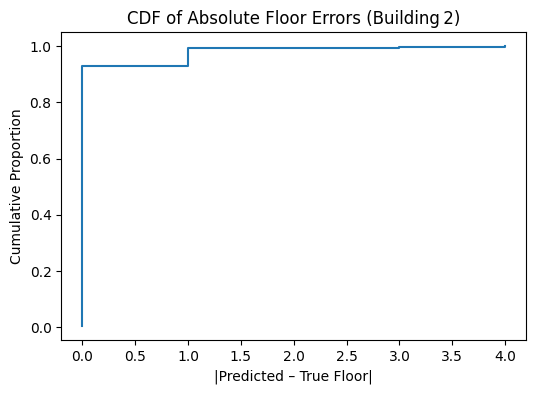

– <= 0 floor error: 92.9%
– <= 1 floor error: 99.3%
– <= 2 floor error: 99.3%

Top 10 most important WAPs for floor classification:
  WAP096: 0.1097
  WAP391: 0.0698
  WAP138: 0.0422
  WAP074: 0.0420
  WAP139: 0.0398
  WAP084: 0.0327
  WAP439: 0.0288
  WAP432: 0.0270
  WAP068: 0.0240
  WAP122: 0.0237


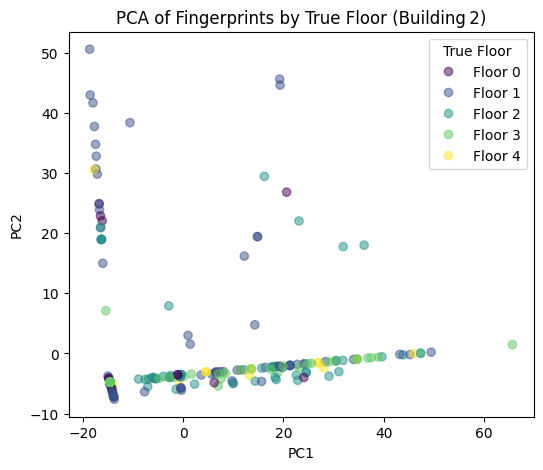

/tmp/ipython-input-21-3464544287.py:90: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='LONGITUDE', y='LATITUDE', data=mis,


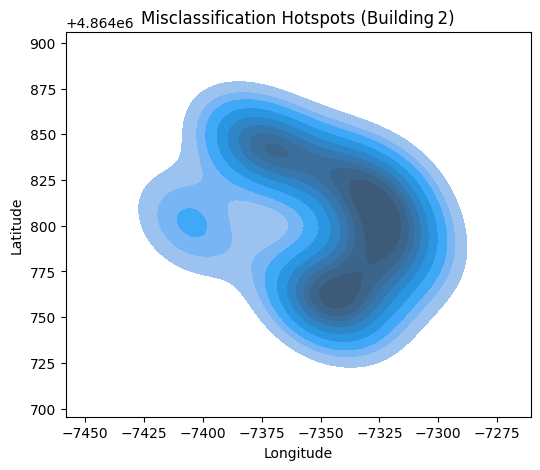

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_floor_classification(y_true, y_pred, floors, X_test_scaled=None,
                                 rssi_columns=None, model=None, df_coords=None,
                                 title=""):
    # 1. Confusion matrix (absolute and normalized)
    cm = confusion_matrix(y_true, y_pred, labels=floors)
    cm_norm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_norm, annot=True, fmt=".2f",
                xticklabels=floors, yticklabels=floors, cmap="Blues")
    plt.title(f"Normalized Confusion Matrix {title}")
    plt.xlabel("Predicted Floor"); plt.ylabel("True Floor")
    plt.show()

    # 2. Floor‐error statistics
    floor_err = y_pred - y_true
    abs_err   = np.abs(floor_err)
    mean_err  = abs_err.mean(); std_err = abs_err.std()
    adj_pct   = 100 * np.sum(abs_err == 1) / len(abs_err)
    nonadj_pct= 100 * np.sum(abs_err > 1) / len(abs_err)
    print(f"Mean absolute floor error: {mean_err:.2f} ± {std_err:.2f} floors")
    print(f"– Adjacent‑floor confusions (|Δ|=1): {adj_pct:.1f}%")
    print(f"– Non‑adjacent‑floor confusions (|Δ|>1): {nonadj_pct:.1f}%")

    # 3. Histogram of raw floor errors
    plt.figure(figsize=(6,4))
    bins = np.arange(floor_err.min()-1, floor_err.max()+2) - 0.5
    plt.hist(floor_err, bins=bins, edgecolor='k')
    plt.xticks(list(floors) + [floors[-1]+1])
    plt.title(f"Distribution of Floor Prediction Errors {title}")
    plt.xlabel("Predicted Floor – True Floor"); plt.ylabel("Count")
    plt.savefig('DIST_b2.png', dpi=3000, bbox_inches='tight')
    plt.show()

    # 4. Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred,
                                target_names=[f"Floor {f}" for f in floors]))

    # 5. CDF of absolute errors
    sorted_err = np.sort(abs_err)
    cdf = np.arange(1, len(sorted_err)+1) / len(sorted_err)
    plt.figure(figsize=(6,4))
    plt.step(sorted_err, cdf, where='post')
    plt.xlabel('|Predicted – True Floor|')
    plt.ylabel('Cumulative Proportion')
    plt.title(f'CDF of Absolute Floor Errors {title}')
    plt.savefig('CDF_b2.png', dpi=3000, bbox_inches='tight')
    plt.show()
    # Print a few key CDF points
    for d in [0,1,2]:
        pct = cdf[ np.searchsorted(sorted_err, d, 'right') - 1 ] * 100
        print(f"– <= {d} floor error: {pct:.1f}%")

    # 6. Feature importances (requires model & feature names)
    if model is not None and rssi_columns is not None:
        importances = model.feature_importances_
        idx = np.argsort(importances)[::-1][:10]  # top 10
        print("\nTop 10 most important WAPs for floor classification:")
        for i in idx:
            print(f"  {rssi_columns[i]}: {importances[i]:.4f}")

    # 7. PCA visualization (requires X_test_scaled)
    if X_test_scaled is not None:
        pca = PCA(n_components=2)
        proj = pca.fit_transform(X_test_scaled)
        plt.figure(figsize=(6,5))
        scatter = plt.scatter(proj[:,0], proj[:,1], c=y_true, alpha=0.5)
        plt.legend(handles=scatter.legend_elements()[0],
                   labels=[f"Floor {f}" for f in floors],
                   title="True Floor")
        plt.title(f"PCA of Fingerprints by True Floor {title}")
        plt.xlabel('PC1'); plt.ylabel('PC2')
        plt.savefig('PCA_b2.png', dpi=3000, bbox_inches='tight')
        plt.show()

    # 8. Spatial heatmap of misclassifications (requires df_coords with LONGITUDE, LATITUDE)
    if df_coords is not None:
        df = df_coords.copy()
        df['err'] = floor_err
        mis = df[df.err != 0]
        if not mis.empty:
            plt.figure(figsize=(6,5))
            sns.kdeplot(x='LONGITUDE', y='LATITUDE', data=mis,
                        shade=True, thresh=0.1)
            plt.title(f"Misclassification Hotspots {title}")
            plt.xlabel("Longitude"); plt.ylabel("Latitude")
            plt.savefig('Misclassification_b2.png', dpi=3000, bbox_inches='tight')
            plt.show()

# Usage for Building 2:
floors = [0,1,2,3,4]
analyze_floor_classification(
    y_true=y_test,
    y_pred=y_test_pred,
    floors=floors,
    X_test_scaled=X_test_scaled,
    rssi_columns=rssi_columns,
    model=xgb_model,
    df_coords=t_data,
    title="(Building 2)"
)


##  =========================4. TUJI1 Dataset=========================

#### XGBoost

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from keras.optimizers import AdamW
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import seaborn as sns

data_directory = "/content/drive/MyDrive/DATASETS/4. TUJI1 Dataset/Train.csv"
tets_directory = "/content/drive/MyDrive/DATASETS/4. TUJI1 Dataset/Test.csv"
data = pd.read_csv(data_directory)
t_data = pd.read_csv(tets_directory)

data.head()

,AP0,AP1,AP2,AP3,AP4,AP5,AP6,AP7,AP8,AP9,...,AP306,AP307,AP308,AP309,X,Y,Z,floor_id,building_id,device_id
0,-54,-57,-60,-60,-75,-75,-88,-88,-88,-88,...,100,100,100,100,22.640,14.903,0,0,0,1
1,-51,-57,-62,-62,-74,-74,-88,-88,100,-88,...,100,100,100,100,22.048,14.903,0,0,0,1
2,-59,-61,-64,-64,-74,-74,-85,-85,-88,-87,...,100,100,100,100,21.459,14.903,0,0,0,1
3,-59,-66,-64,-62,-70,-70,-85,-86,-89,-89,...,100,100,100,100,20.859,14.903,0,0,0,1
4,-58,-64,-65,-63,-68,-68,-87,-87,-82,-83,...,100,100,100,100,20.262,14.903,0,0,0,1


In [ ]:
data["floor_id"].unique()

array([0])

In [ ]:
rssi_columns = [col for col in data.columns if "AP" in col]

rssi = data[rssi_columns]
XYZ_Pos = data[["X",	"Y"]]
y_test =  t_data[["X",	"Y"]]
rssi_columns = [col for col in data.columns if "AP" in col]
rssi = data[rssi_columns].copy()
rssi[rssi <= -100] = np.nan
rssi = rssi.fillna(-102)
min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * rssi.shape[0])
valid_columns = rssi.columns[(rssi > -100).sum() > min_required_count]
rssi = rssi[valid_columns]
x_test = t_data[valid_columns].copy()
x_test[x_test <= -100] = np.nan
x_test = x_test.fillna(-102)
print(f"Remaining APs after filtering: {len(valid_columns)}\n")
scaler_X = MinMaxScaler()
RSSI = scaler_X.fit_transform(rssi)
X_test = scaler_X.transform(x_test)

scaler_y = MinMaxScaler()
xyz_Pos = scaler_y.fit_transform(XYZ_Pos)

X_train, X_val, y_train, y_val = train_test_split(RSSI, xyz_Pos, test_size=0.2, random_state=SEED)


print("Shapes of the datasets after splitting:")
print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test set: X_test: {X_test.shape}, y_test: {y_test.shape}")

Remaining APs after filtering: 310

Shapes of the datasets after splitting:
Training set: X_train: (5401, 310), y_train: (5401, 2)
Validation set: X_val: (1351, 310), y_val: (1351, 2)
Test set: X_test: (2147, 310), y_test: (2147, 2)


In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest= xgb.DMatrix(X_test)



xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 8,
    'min_child_weight': 5,
    'subsample': 0.64,
    'colsample_bytree': 0.5,
    'n_estimators': 621,
    'seed': SEED
}

eval_results = {}


model_combined = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=9000,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=10,
    evals_result=eval_results,
    verbose_eval=50
)

[0]	train-rmse:0.26390	validation-rmse:0.26371
[50]	train-rmse:0.17842	validation-rmse:0.18033
[100]	train-rmse:0.12682	validation-rmse:0.13144
[150]	train-rmse:0.09646	validation-rmse:0.10413
[200]	train-rmse:0.07879	validation-rmse:0.08942
[250]	train-rmse:0.06815	validation-rmse:0.08150
[300]	train-rmse:0.06148	validation-rmse:0.07702
[350]	train-rmse:0.05724	validation-rmse:0.07453
[400]	train-rmse:0.05429	validation-rmse:0.07298
[450]	train-rmse:0.05205	validation-rmse:0.07201
[500]	train-rmse:0.05034	validation-rmse:0.07128
[550]	train-rmse:0.04874	validation-rmse:0.07065
[600]	train-rmse:0.04748	validation-rmse:0.07020
[650]	train-rmse:0.04630	validation-rmse:0.06979
[700]	train-rmse:0.04519	validation-rmse:0.06948
[750]	train-rmse:0.04402	validation-rmse:0.06920
[800]	train-rmse:0.04298	validation-rmse:0.06896
[850]	train-rmse:0.04207	validation-rmse:0.06878
[900]	train-rmse:0.04105	validation-rmse:0.06859
[950]	train-rmse:0.04016	validation-rmse:0.06843
[1000]	train-rmse:0.039

In [ ]:
predictions = model_combined.predict(dtest)
predicted_coords_xgb_original = scaler_y.inverse_transform(predictions)

y_test_original =  t_data[["X",	"Y"]].values
mse_xgb = mean_squared_error(y_test_original, predicted_coords_xgb_original)
mae_xgb = mean_absolute_error(y_test_original, predicted_coords_xgb_original)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test_original, predicted_coords_xgb_original)
success_radius = 5
distances_T = np.sqrt(np.sum((y_test_original - predicted_coords_xgb_original) ** 2, axis=1))
success_rate_xgb = np.mean(distances_T <= success_radius) * 100
localization_error_xgb = np.mean(distances_T)
print(f"Mean Squared Error (MSE): {mse_xgb:.4f}")
print(f"Mean Absolute Error (MAE): {mae_xgb:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.4f}")
print(f"R2 Score: {r2_xgb:.4f}")
print(f"Localization Success Rate (within {success_radius} meters): {success_rate_xgb:.2f}%")
print(f"Average Localization Error: {localization_error_xgb:.4f} meters")


Mean Squared Error (MSE): 3.3813
Mean Absolute Error (MAE): 1.4095
Root Mean Squared Error (RMSE): 1.8388
R2 Score: 0.8991
Localization Success Rate (within 5 meters): 96.09%
Average Localization Error: 2.2175 meters


In [ ]:

import joblib

# Save the XGBoost model
model_combined.save_model('/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_model_tju.json')

In [ ]:

import joblib
xgb_model = joblib.load('/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_model_tju.json')


KeyError: 123

#### Indoor Localization XGBoost 10 Run Stability Analysis


Final Metrics for TUJI1 Dataset (across runs):\
MAE (m): 1.399 ± 0.008\
MSE (m): 3.354 ± 0.030\
RMSE (m): 1.831 ± 0.008
R²: 0.900 ± 0.001\
Success Rate (%): 96.139 ± 0.181\
Avg. Localization Error (m): 2.199 ± 0.012

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from keras.optimizers import AdamW
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import seaborn as sns

data_directory = "/content/drive/MyDrive/DATASETS/4. TUJI1 Dataset/Train.csv"
tets_directory = "/content/drive/MyDrive/DATASETS/4. TUJI1 Dataset/Test.csv"
data = pd.read_csv(data_directory)
t_data = pd.read_csv(tets_directory)
rssi_columns = [col for col in data.columns if "AP" in col]

rssi = data[rssi_columns]
XYZ_Pos = data[["X",	"Y"]]
y_test =  t_data[["X",	"Y"]]
rssi_columns = [col for col in data.columns if "AP" in col]
rssi = data[rssi_columns].copy()
rssi[rssi <= -100] = np.nan
rssi = rssi.fillna(-102)
min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * rssi.shape[0])
valid_columns = rssi.columns[(rssi > -100).sum() > min_required_count]
rssi = rssi[valid_columns]
x_test = t_data[valid_columns].copy()
x_test[x_test <= -100] = np.nan
x_test = x_test.fillna(-102)
print(f"Remaining APs after filtering: {len(valid_columns)}\n")
scaler_X = MinMaxScaler()
RSSI = scaler_X.fit_transform(rssi)
X_test = scaler_X.transform(x_test)

scaler_y = MinMaxScaler()
xyz_Pos = scaler_y.fit_transform(XYZ_Pos)

X_train, X_val, y_train, y_val = train_test_split(RSSI, xyz_Pos, test_size=0.2, random_state=SEED)


Remaining APs after filtering: 310



In [5]:
import random

NUM_RUNS = 10

# Lists to collect metrics
mae_list = []
rmse_list = []
mse_list = []
r2_list = []
success_rate_list = []
avg_loc_error_list = []

for run in range(NUM_RUNS):
    print(f"\nRun {run + 1}/{NUM_RUNS}")

    seed = random.randint(0, 10000)
    np.random.seed(seed)

    # Resplit train/val each time
    X_train, X_val, y_train, y_val = train_test_split(
        RSSI, xyz_Pos, test_size=0.2, random_state=seed
    )

    # Prepare DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 8,
    'min_child_weight': 5,
    'subsample': 0.64,
    'colsample_bytree': 0.5,
    'n_estimators': 621,
    'seed': seed
    }

    model_combined = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=9000,
        evals=[(dtrain, 'train'), (dval, 'validation')],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    # Predict and inverse transform
    y_pred_scaled = model_combined.predict(dtest)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = y_test.values
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    distances = np.linalg.norm(y_true - y_pred, axis=1)
    success_rate = np.mean(distances <= 5) * 100
    avg_loc_error = np.mean(distances)
    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    r2_list.append(r2)
    success_rate_list.append(success_rate)
    avg_loc_error_list.append(avg_loc_error)

# === Summary ===
def summarize(name, values):
    print(f"{name}: {np.mean(values):.3f} ± {np.std(values):.3f}")

print("\nFinal Metrics for TUJI1 Dataset (across runs):")
summarize("MAE (m)", mae_list)
summarize("MSE (m)", mse_list)
summarize("RMSE (m)", rmse_list)
summarize("R²", r2_list)
summarize("Success Rate (%)", success_rate_list)
summarize("Avg. Localization Error (m)", avg_loc_error_list)


Final Metrics for TUJI1 Dataset (across runs):
MAE (m): 1.399 ± 0.008
MSE (m): 3.354 ± 0.030
RMSE (m): 1.831 ± 0.008
R²: 0.900 ± 0.001
Success Rate (%): 96.139 ± 0.181
Avg. Localization Error (m): 2.199 ± 0.012


## ========================= CDFs =========================

###ble

In [3]:
# Load and preprocess the dataset
# Path to the directory containing CSV files
data_directory = "/content/drive/MyDrive/DATASETS/1. RSSI using BLE/Indoor Environment Dataset Based on RSSI Collected with Bluetooth Devices"

# Initialize an empty list to store DataFrames
dataframes = []
for file in os.listdir(data_directory):
    if file.endswith(".csv"):  # Only process CSV files
        file_path = os.path.join(data_directory, file)
        df = pd.read_csv(file_path)
        dataframes.append(df)

# Combine all DataFrames into one
data = pd.concat(dataframes, ignore_index=True)

# === Preprocess RSSI Columns ===
rssi_columns = [col for col in data.columns if "WAP" in col]


# Feature Selection: Extract RSSI columns and target coordinates
rssi_columns = rssi_columns   #[col for col in data.columns if "WAP" in col]
RSSI = data[rssi_columns].copy()  # Combine RSSI columns with additional features + ['ROOM_ID']

# --- Signal thresholding ---
# Set all RSSI values <= -100 dBm to NaN (or choose -105 based on your data)

RSSI[RSSI <= -100] = np.nan

# Optional: replace NaNs with a minimum signal value or drop them
RSSI = RSSI.fillna(-100)  # or use RSSI = RSSI.dropna(axis=1)

# --- AP filtering ---
# Remove WAP columns that appear (non-NaN) in less than 5% of the samples
min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * RSSI.shape[0])
valid_columns = RSSI.columns[(RSSI > -100).sum() > min_required_count]
RSSI = RSSI[valid_columns]

print(f"Remaining APs after filtering: {len(valid_columns)}\n")


xy = data[['X', 'Y']]  # Target coordinates

# Normalize RSSI values and coordinates
scaler_X = MinMaxScaler()
RSSI_scaled = scaler_X.fit_transform(RSSI)

# scaler_y = StandardScaler()
scaler_y = MinMaxScaler()
xy_scaled = scaler_y.fit_transform(xy)


# Re-split dataset with Kalman Filtered data
X_train, X_d, y_train, y_d = train_test_split(RSSI, xy_scaled, test_size=0.1, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_d, y_d, test_size=0.5, random_state=42, shuffle=True)

# Verify the new sizes
print(f"New size of training set: {X_train.shape[0]}")
print(f"New size of validation set: {X_val.shape[0]}")
print(f"New size of test set: {X_test.shape[0]}")

import xgboost as xgb
# Load the saved model
xgb_model = xgb.Booster()
xgb_model.load_model("/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_ble.json")

# === Evaluate ===
dtest= xgb.DMatrix(X_test)
predicted_coords = xgb_model.predict(dtest)
y_test_original = scaler_y.inverse_transform(y_test)
predicted_coords_original = scaler_y.inverse_transform(predicted_coords)

mse_ble = mean_squared_error(y_test_original, predicted_coords_original)
mae_ble = mean_absolute_error(y_test_original, predicted_coords_original)
rmse_ble = np.sqrt(mse_ble)
r2_ble = r2_score(y_test_original, predicted_coords_original)
distances_ble = np.sqrt(np.sum((y_test_original - predicted_coords_original) ** 2, axis=1))
success_rate_ble = np.mean(distances_ble <= 5) * 100
localization_error_ble = np.mean(distances_ble)

max_error = np.max(np.linalg.norm(y_test_original - predicted_coords_original, axis=1))
relative_accuracy_ble = (1 - (rmse_ble / max_error)) * 100

# === Output results ===
print(f"\nXGBoost Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse_ble:.4f}")
print(f"Mean Absolute Error (MAE): {mae_ble:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_ble:.4f}")
print(f"R2 Score: {r2_ble:.4f}")
print(f"Localization Success Rate (within 5m): {success_rate_ble:.2f}%")
print(f"Average Localization Error: {localization_error_ble:.4f} meters")
print(f"Relative Localization Accuracy  (RMSE vs. Max Euclidean Error:{max_error:.3f}) : {relative_accuracy_ble:.2f}%")

Remaining APs after filtering: 15

New size of training set: 14292
New size of validation set: 795
New size of test set: 794

XGBoost Performance Metrics:
Mean Squared Error (MSE): 2.7524
Mean Absolute Error (MAE): 1.2679
Root Mean Squared Error (RMSE): 1.6590
R2 Score: 0.9369
Localization Success Rate (within 5m): 97.48%
Average Localization Error: 1.9828 meters
Relative Localization Accuracy  (RMSE vs. Max Euclidean Error:8.820) : 81.19%


###SOD

CETC331

In [16]:

# Path to the directory containing CSV files
data_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/CETC331/Training_CETC331.csv"
tets_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/CETC331/Testing_CETC331.csv"
data = pd.read_csv(data_directory)
t_data = pd.read_csv(tets_directory)

# === Preprocess RSSI Columns ===
rssi_columns = [col for col in data.columns if "MAC" in col]
data = data.drop(columns=["BuildingID",		"UserID",	"PhoneID",	"SampleTimes"])
t_data = t_data.drop(columns=["BuildingID",		"UserID",	"PhoneID",	"SampleTimes"])

data = data.replace(100, -105)
t_data = t_data.replace(100, -105)

# Extract features and labels
rssi_columns = rssi_columns
label_columns = ["ECoord", "NCoord"]
rssi_df = data[rssi_columns].copy()

rssi_df[rssi_df <= -100] = np.nan

min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * len(rssi_df))
valid_columns = rssi_df.columns[(rssi_df > -100).sum() > min_required_count]

rssi_df = rssi_df[valid_columns]
print(f"Remaining APs after filtering: {len(valid_columns)}")
rssi_df = rssi_df.fillna(-105)
RSSI = rssi_df.values
xy = data[label_columns].values
x_test = t_data[rssi_columns].values
y_test = t_data[label_columns].values
x_test_df = t_data[valid_columns].copy()
x_test_df = x_test_df.replace(100, -105)
x_test_df[x_test_df <= -100] = -105
x_test = x_test_df.values
scaler_X = MinMaxScaler()
RSSI_scaled = scaler_X.fit_transform(RSSI)
X_test = scaler_X.transform(x_test)
scaler_y = StandardScaler()
xy_scaled = scaler_y.fit_transform(xy)

X_train, X_val, y_train, y_val = train_test_split(
    RSSI_scaled, xy_scaled, test_size=0.2, random_state=SEED
)



import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the saved model
model_combined = xgb.Booster()
model_combined.load_model("/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_cetc311.json")


# Predict on the test set (single prediction)
dtest= xgb.DMatrix(X_test)

y_pred_scaled_combined = model_combined.predict(dtest)

# Inverse transform predictions back to the original scale
y_pred_combined = scaler_y.inverse_transform(y_pred_scaled_combined)
y_test_combined = y_test     #scaler_y.inverse_transform(y_test_scaled)

# Calculate metrics for ECoord and NCoord
mae_c = mean_absolute_error(y_test_combined, y_pred_combined)
mse_c = mean_squared_error(y_test_combined, y_pred_combined)
rmse_c = np.sqrt(mse_c)
r2_c = r2_score(y_test_combined, y_pred_combined)

# Calculate Localization Success Rate
success_radius = 5 # Acceptable radius for successful localization
distances_c = np.sqrt(np.sum((y_test_combined - y_pred_combined) ** 2, axis=1))
success_rate_c = np.mean(distances_c <= success_radius) * 100  # Convert to percentage
localization_error_c = np.mean(distances_c)  # Average Localization Error
max_error = np.max(np.linalg.norm(y_test_combined - y_pred_combined, axis=1))
relative_accuracy_c = (1 - (rmse_c / max_error)) * 100
# Print Results
print(f"Metrics for Localization (ECoord and NCoord):")
print(f"Mean Absolute Error (MAE): {mae_c:.3f}")
print(f"Mean Squared Error (MSE): {mse_c:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse_c:.3f}")
print(f"R2 Score: {r2_c:.3f}")
print(f"Localization Success Rate (within {success_radius} meters): {success_rate_c:.3f}%")
print(f"Average Localization Error: {localization_error_c:.3f} meters")
print(f"Relative Localization Accuracy  (RMSE vs. Max Euclidean Error:{max_error:.3f}) : {relative_accuracy_c:.2f}%")


Remaining APs after filtering: 50
Metrics for Localization (ECoord and NCoord):
Mean Absolute Error (MAE): 2.028
Mean Squared Error (MSE): 14.491
Root Mean Squared Error (RMSE): 3.807
R2 Score: 0.897
Localization Success Rate (within 5 meters): 82.024%
Average Localization Error: 3.543 meters
Relative Localization Accuracy  (RMSE vs. Max Euclidean Error:37.832) : 89.94%


HEXY

In [18]:
# data_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/HCXY/pre installed AP only/Training_HCXY_AP_Avg.csv"
data_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/HCXY/pre installed AP only/Training_HCXY_AP_30.csv"
tets_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/HCXY/pre installed AP only/Testing_HCXY_AP.csv"
data = pd.read_csv(data_directory)
t_data = pd.read_csv(tets_directory)

# === Preprocess RSSI Columns ===
rssi_columns = [col for col in data.columns if "MAC" in col]
data = data.drop(columns=["BuildingID",		"UserID",	"PhoneID",	"SampleTimes"])
t_data = t_data.drop(columns=["BuildingID",		"UserID",	"PhoneID",	"SampleTimes"])
data = data.replace(100, -98)
t_data = t_data.replace(100, -98)

# Extract features and labels
rssi_columns = rssi_columns
label_columns = ["ECoord", "NCoord"]

rssi_df = data[rssi_columns].copy()

rssi_df[rssi_df <= -100] = np.nan
min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * len(rssi_df))
valid_columns = rssi_df.columns[(rssi_df > -100).sum() > min_required_count]
rssi_df = rssi_df[valid_columns]
print(f"Remaining APs after filtering: {len(valid_columns)}")
rssi_df = rssi_df.fillna(-98)
RSSI = rssi_df.values

xy = data[label_columns].values
x_test_df = t_data[valid_columns].copy()
x_test_df = x_test_df.replace(100, -98)
x_test_df[x_test_df <= -100] = -98
x_test = x_test_df.values

y_test = t_data[label_columns].values
scaler_X = MinMaxScaler()
RSSI_scaled = scaler_X.fit_transform(RSSI)
X_test = scaler_X.transform(x_test)

scaler_y = StandardScaler()
xy_scaled = scaler_y.fit_transform(xy)

X_train, X_val, y_train, y_val = train_test_split(
    RSSI_scaled, xy_scaled, test_size=0.2, random_state=SEED
)


import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the saved model
model_combined = xgb.Booster()
model_combined.load_model("/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_hcky.json")

# Predict on the test set (single prediction)
dtest= xgb.DMatrix(X_test)
y_pred_scaled_combined = model_combined.predict(dtest)

# Inverse transform predictions back to the original scale
y_pred_combined = scaler_y.inverse_transform(y_pred_scaled_combined)
y_test_combined = y_test
mae_h = mean_absolute_error(y_test_combined, y_pred_combined)
mse_h = mean_squared_error(y_test_combined, y_pred_combined)
rmse_h = np.sqrt(mse_h)
r2_h= r2_score(y_test_combined, y_pred_combined)

# Calculate Localization Success Rate
success_radius = 5  # Acceptable radius for successful localization
distances_h= np.sqrt(np.sum((y_test_combined - y_pred_combined) ** 2, axis=1))
success_rate_h = np.mean(distances_h <= success_radius) * 100  # Convert to percentage
localization_error_h = np.mean(distances_h)  # Average Localization Error

# Print Results
print(f"Metrics for Localization (ECoord and NCoord):")
print(f"Mean Absolute Error (MAE): {mae_h:.3f}")
print(f"Mean Squared Error (MSE): {mse_h:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse_h:.3f}")
print(f"R2 Score: {r2_h:.3f}")
print(f"Localization Success Rate (within {success_radius} meters): {success_rate_h:.3f}%")
print(f"Average Localization Error: {localization_error_h:.3f} meters")
max_error = np.max(np.linalg.norm(y_test_combined - y_pred_combined, axis=1))
relative_accuracy_h = (1 - (rmse_h / max_error)) * 100
print(f"Relative Localization Accuracy  (RMSE vs. Max Euclidean Error:{max_error:.3f}) : {relative_accuracy_h:.2f}%")

Remaining APs after filtering: 56
Metrics for Localization (ECoord and NCoord):
Mean Absolute Error (MAE): 1.579
Mean Squared Error (MSE): 6.892
Root Mean Squared Error (RMSE): 2.625
R2 Score: 0.986
Localization Success Rate (within 5 meters): 89.302%
Average Localization Error: 2.763 meters
Relative Localization Accuracy  (RMSE vs. Max Euclidean Error:13.472) : 80.51%


SYL

In [22]:
# data_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/SYL/Only pre installed AP/Training_SYL_AP_Avg.csv"
data_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/SYL/Only pre installed AP/Training_SYL_AP_30.csv"
tets_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/SYL/Only pre installed AP/Testing_SYL_AP.csv"
data = pd.read_csv(data_directory)
t_data = pd.read_csv(tets_directory)
data.replace(100, -93, inplace=True)
t_data.replace(100, -93, inplace=True)

# === Preprocess RSSI Columns ===
rssi_columns = [col for col in data.columns if "MAC" in col]
data = data.drop(columns=[	"SceneID", "BuildingID",		"UserID",	"PhoneID",	"SampleTimes"])
t_data = t_data.drop(columns=[	"SceneID", "BuildingID",		"UserID",	"PhoneID",	"SampleTimes"])
rssi_columns = rssi_columns
label_columns = ["ECoord", "NCoord"]
rssi_df = data[rssi_columns].copy()
rssi_df[rssi_df <= -100] = np.nan
min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * len(rssi_df))
valid_columns = rssi_df.columns[(rssi_df > -100).sum() > min_required_count]
rssi_df = rssi_df[valid_columns]
print(f"Remaining APs after filtering: {len(valid_columns)}")
rssi_df = rssi_df.fillna(-93)
RSSI = rssi_df.values
xy = data[label_columns].values
x_test = t_data[rssi_columns].values
x_test_df = t_data[valid_columns].copy()
x_test_df = x_test_df.replace(100, -93)
x_test_df[x_test_df <= -100] = -93
x_test = x_test_df.values
y_test = t_data[label_columns].values
scaler_X = MinMaxScaler()
RSSI_scaled = scaler_X.fit_transform(RSSI)
X_test = scaler_X.transform(x_test)
scaler_y = StandardScaler()
xy_scaled = scaler_y.fit_transform(xy)


X_train, X_val, y_train, y_val = train_test_split(
    RSSI_scaled, xy_scaled, test_size=0.2, random_state=SEED
)

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the saved model
model_combined = xgb.Booster()
model_combined.load_model("/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_syl.json")

# Predict on the test set (single prediction)
dtest= xgb.DMatrix(X_test)
y_pred_scaled_combined = model_combined.predict(dtest)

# Inverse transform predictions back to the original scale
y_pred_combined = scaler_y.inverse_transform(y_pred_scaled_combined)
y_test_combined = y_test     #scaler_y.inverse_transform(y_test_scaled)

# Ensure the floor values are integers and within the valid range [1, 3]
# Calculate metrics for ECoord and NCoord
mae_s = mean_absolute_error(y_test_combined, y_pred_combined)
mse_s = mean_squared_error(y_test_combined, y_pred_combined)
rmse_s = np.sqrt(mse_s)
r2_s = r2_score(y_test_combined, y_pred_combined)

# Calculate Localization Success Rate
success_radius = 5  # Acceptable radius for successful localization
distances_s = np.sqrt(np.sum((y_test_combined - y_pred_combined) ** 2, axis=1))
success_rate_s = np.mean(distances_s<= success_radius) * 100  # Convert to percentage
localization_error_s = np.mean(distances_s)  # Average Localization Error

# Print Results
print(f"Metrics for Localization (ECoord and NCoord):")
print(f"Mean Absolute Error (MAE): {mae_s:.3f}")
print(f"Mean Squared Error (MSE): {mse_s:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse_s:.3f}")
print(f"R2 Score: {r2_s:.3f}")
print(f"Localization Success Rate (within {success_radius} meters): {success_rate_s:.3f}%")
print(f"Average Localization Error: {localization_error_s:.3f} meters")
max_error = np.max(np.linalg.norm(y_test_combined - y_pred_combined, axis=1))
relative_accuracy_s = (1 - (rmse_s / max_error)) * 100
print(f"Relative Localization Accuracy  (RMSE vs. Max Euclidean Error:{max_error:.3f}) : {relative_accuracy_s:.2f}%")

# Metrics for Localization (ECoord and NCoord):
# Mean Absolute Error (MAE): 2.119
# Mean Squared Error (MSE): 18.571
# Root Mean Squared Error (RMSE): 4.309
# R2 Score: 0.919
# Localization Success Rate (within 5 meters): 85.588%
# Average Localization Error: 3.523 meters

Remaining APs after filtering: 46
Metrics for Localization (ECoord and NCoord):
Mean Absolute Error (MAE): 2.147
Mean Squared Error (MSE): 18.923
Root Mean Squared Error (RMSE): 4.350
R2 Score: 0.918
Localization Success Rate (within 5 meters): 83.431%
Average Localization Error: 3.588 meters
Relative Localization Accuracy  (RMSE vs. Max Euclidean Error:50.881) : 91.45%


###UJI

B0

In [23]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from keras.optimizers import AdamW
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import seaborn as sns

# Load your training and validation datasets
path_train = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building0/UjiindoorLoc_building_0/train_building_0.csv"
path_test = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building0/UjiindoorLoc_building_0/val_building_0.csv"

data = pd.read_csv(path_train)            # min rssi = -101
data.replace(100, -102, inplace=True)

t_data = pd.read_csv(path_test)
t_data.replace(100, -103, inplace=True)

rssi_columns = [col for col in data.columns if "WAP" in col]

rssi = data[rssi_columns].copy()
XYZ_Pos = data[["LONGITUDE",	"LATITUDE" ]]

x_test =  t_data[rssi_columns]
y_test =  t_data[["LONGITUDE",	"LATITUDE"]]

rssi[rssi <= -100] = np.nan
x_test[x_test <= -100] = np.nan

min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * rssi.shape[0])
valid_columns = rssi.columns[(rssi > -100).sum() > min_required_count]

rssi = rssi[valid_columns].fillna(-103)
x_test = x_test[valid_columns].fillna(-103)

print(f"Remaining APs after filtering: {len(valid_columns)}\n")

scaler_X = MinMaxScaler()
RSSI = scaler_X.fit_transform(rssi)
X_test = scaler_X.fit_transform(x_test)

scaler_y = MinMaxScaler()
xyz_Pos = scaler_y.fit_transform(XYZ_Pos)

X_train, X_val, y_train, y_val = train_test_split(RSSI, xyz_Pos, test_size=0.2, random_state=42)

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the saved model
model_combined = xgb.Booster()
model_combined.load_model("/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_bo.json")

dtest= xgb.DMatrix(X_test)
# Get predictions
predictions = model_combined.predict(dtest)
predicted_coords_xgb_original = scaler_y.inverse_transform(predictions)
y_test_original =  t_data[["LONGITUDE",	"LATITUDE"]].values

# Calculate MSE (Mean Squared Error)
mse_1 = mean_squared_error(y_test_original, predicted_coords_xgb_original)

# Calculate MAE (Mean Absolute Error)
mae_1 = mean_absolute_error(y_test_original, predicted_coords_xgb_original)

# Calculate RMSE (Root Mean Squared Error)
rmse_1 = np.sqrt(mse_1)

# Calculate R2 Score
r2_1 = r2_score(y_test_original, predicted_coords_xgb_original)

# Calculate Localization Success Rate (within 2 meters)
success_radius = 5
distances_1 = np.sqrt(np.sum((y_test_original - predicted_coords_xgb_original) ** 2, axis=1))
success_rate_1 = np.mean(distances_1 <= success_radius) * 100

# Average Localization Error
localization_error_1= np.mean(distances_1)

# Print Results
print(f"Mean Squared Error (MSE): {mse_1:.3f}")
print(f"Mean Absolute Error (MAE): {mae_1:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse_1:.3f}")
print(f"R2 Score: {r2_1:.3f}")
print(f"Localization Success Rate (within {success_radius} meters): {success_rate_1:.3f}%")
print(f"Average Localization Error: {localization_error_1:.3f} meters")
max_error = np.max(np.linalg.norm(y_test_original - predicted_coords_xgb_original, axis=1))
relative_accuracy_1 = (1 - (rmse_1 / max_error)) * 100
print(f"Relative Localization Accuracy  (RMSE vs. Max Euclidean Error:{max_error:.3f}) : {relative_accuracy_1:.2f}%")

# Using minmax:
# Mean Squared Error (MSE): 41.604
# Mean Absolute Error (MAE): 4.517
# Root Mean Squared Error (RMSE): 6.450
# R2 Score: 0.949
# Localization Success Rate (within 5 meters): 43.843%
# Average Localization Error: 7.147 meters

Remaining APs after filtering: 77

Mean Squared Error (MSE): 42.748
Mean Absolute Error (MAE): 4.582
Root Mean Squared Error (RMSE): 6.538
R2 Score: 0.947
Localization Success Rate (within 5 meters): 43.284%
Average Localization Error: 7.253 meters
Relative Localization Accuracy  (RMSE vs. Max Euclidean Error:40.479) : 83.85%


B1

In [24]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from keras.optimizers import AdamW
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import seaborn as sns

path_train = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building1/UjiindoorLoc_building_1/train_building_1.csv"
path_test = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building1/UjiindoorLoc_building_1/val_building_1.csv"


data = pd.read_csv(path_train)            # min rssi = -103
data.replace(100, -104, inplace=True)

t_data = pd.read_csv(path_test)
t_data.replace(100, -102, inplace=True)

rssi_columns = [col for col in data.columns if "WAP" in col]
rssi = data[rssi_columns].copy()
XYZ_Pos = data[["LONGITUDE",	"LATITUDE" ]]

x_test =  t_data[rssi_columns]
y_test =  t_data[["LONGITUDE",	"LATITUDE"]]

rssi[rssi <= -100] = np.nan
x_test[x_test <= -100] = np.nan

min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * rssi.shape[0])
valid_columns = rssi.columns[(rssi > -100).sum() > min_required_count]

rssi = rssi[valid_columns].fillna(-104)
x_test = x_test[valid_columns].fillna(-102)

print(f"Remaining APs after filtering: {len(valid_columns)}\n")

scaler_X = MinMaxScaler()
RSSI = scaler_X.fit_transform(rssi)
X_test = scaler_X.fit_transform(x_test)

scaler_y = MinMaxScaler()
xyz_Pos = scaler_y.fit_transform(XYZ_Pos)

X_train, X_val, y_train, y_val = train_test_split(RSSI, xyz_Pos, test_size=0.2, random_state=42)

# Load the saved model
model_combined = xgb.Booster()
model_combined.load_model("/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_b1.json")

dtest= xgb.DMatrix(X_test)
# Get predictions
predictions = model_combined.predict(dtest)
predicted_coords_xgb_original = scaler_y.inverse_transform(predictions)
y_test_original =  t_data[["LONGITUDE",	"LATITUDE"]].values

# Calculate MSE (Mean Squared Error)
mse_2 = mean_squared_error(y_test_original, predicted_coords_xgb_original)

# Calculate MAE (Mean Absolute Error)
mae_2 = mean_absolute_error(y_test_original, predicted_coords_xgb_original)

# Calculate RMSE (Root Mean Squared Error)
rmse_2 = np.sqrt(mse_2)

# Calculate R2 Score
r2_2 = r2_score(y_test_original, predicted_coords_xgb_original)

# Calculate Localization Success Rate (within 2 meters)
success_radius = 5
distances_2 = np.sqrt(np.sum((y_test_original - predicted_coords_xgb_original) ** 2, axis=1))
success_rate_2 = np.mean(distances_2 <= success_radius) * 100

# Average Localization Error
localization_error_2= np.mean(distances_2)

# Print Results
print(f"Mean Squared Error (MSE): {mse_2:.3f}")
print(f"Mean Absolute Error (MAE): {mae_2:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse_2:.3f}")
print(f"R2 Score: {r2_2:.3f}")
print(f"Localization Success Rate (within {success_radius} meters): {success_rate_2:.3f}%")
print(f"Average Localization Error: {localization_error_2:.3f} meters")
max_error = np.max(np.linalg.norm(y_test_original - predicted_coords_xgb_original, axis=1))
relative_accuracy_2 = (1 - (rmse_2 / max_error)) * 100
print(f"Relative Localization Accuracy  (RMSE vs. Max Euclidean Error:{max_error:.3f}) : {relative_accuracy_2:.2f}%")


Remaining APs after filtering: 124

Mean Squared Error (MSE): 119.778
Mean Absolute Error (MAE): 7.850
Root Mean Squared Error (RMSE): 10.944
R2 Score: 0.920
Localization Success Rate (within 5 meters): 19.870%
Average Localization Error: 12.547 meters
Relative Localization Accuracy  (RMSE vs. Max Euclidean Error:47.743) : 77.08%


B2

In [25]:
# Extract the necessary columns
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from keras.optimizers import AdamW
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import seaborn as sns

# Load your training and validation datasets
# Load your training and validation datasets
path_train = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building2/UjiindoorLoc_building_2/train_building_2.csv"
path_test = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building2/UjiindoorLoc_building_2/val_building_2.csv"


data = pd.read_csv(path_train)            # min rssi = -101
data.replace(100, -105, inplace=True)

t_data = pd.read_csv(path_test)
t_data.replace(100, -102, inplace=True)

rssi_columns = [col for col in data.columns if "WAP" in col]

rssi = data[rssi_columns].copy()
XYZ_Pos = data[["LONGITUDE",	"LATITUDE" ]]

x_test =  t_data[rssi_columns]
y_test =  t_data[["LONGITUDE",	"LATITUDE"]]

rssi[rssi <= -100] = np.nan
x_test[x_test <= -100] = np.nan

min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * rssi.shape[0])
valid_columns = rssi.columns[(rssi > -100).sum() > min_required_count]

rssi = rssi[valid_columns].fillna(-105)
x_test = x_test[valid_columns].fillna(-102)

print(f"Remaining APs after filtering: {len(valid_columns)}\n")

scaler_X = MinMaxScaler()
RSSI = scaler_X.fit_transform(rssi)
X_test = scaler_X.fit_transform(x_test)

scaler_y = MinMaxScaler()
xyz_Pos = scaler_y.fit_transform(XYZ_Pos)
#################################################################################
# from sklearn.preprocessing import StandardScaler

# # Z-Score Normalization for RSSI
# scaler_X = StandardScaler()
# RSSI = scaler_X.fit_transform(rssi)  # Apply Z-Score to RSSI data
# X_test = scaler_X.transform(x_test)  # Apply Z-Score to test data

# # Z-Score Normalization for XYZ_Pos
# scaler_y = StandardScaler()
# xyz_Pos = scaler_y.fit_transform(XYZ_Pos)  # Apply Z-Score to position data

#####################################################################################
X_train, X_val, y_train, y_val = train_test_split(RSSI, xyz_Pos, test_size=0.2, random_state=42)

# Load the saved model
model_combined = xgb.Booster()
model_combined.load_model("/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_b2.json")
dtest= xgb.DMatrix(X_test)
# Get predictions
predictions = model_combined.predict(dtest)
predicted_coords_xgb_original = scaler_y.inverse_transform(predictions)
y_test_original =  t_data[["LONGITUDE",	"LATITUDE"]].values

# Calculate MSE (Mean Squared Error)
mse_3 = mean_squared_error(y_test_original, predicted_coords_xgb_original)

# Calculate MAE (Mean Absolute Error)
mae_3 = mean_absolute_error(y_test_original, predicted_coords_xgb_original)

# Calculate RMSE (Root Mean Squared Error)
rmse_3 = np.sqrt(mse_3)

# Calculate R2 Score
r2_3 = r2_score(y_test_original, predicted_coords_xgb_original)

# Calculate Localization Success Rate (within 2 meters)
success_radius = 5
distances_3 = np.sqrt(np.sum((y_test_original - predicted_coords_xgb_original) ** 2, axis=1))
success_rate_3 = np.mean(distances_3 <= success_radius) * 100

# Average Localization Error
localization_error_3= np.mean(distances_3)

# Print Results
print(f"Mean Squared Error (MSE): {mse_3:.3f}")
print(f"Mean Absolute Error (MAE): {mae_3:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse_3:.3f}")
print(f"R2 Score: {r2_2:.3f}")
print(f"Localization Success Rate (within {success_radius} meters): {success_rate_3:.3f}%")
print(f"Average Localization Error: {localization_error_3:.3f} meters")
max_error = np.max(np.linalg.norm(y_test_original - predicted_coords_xgb_original, axis=1))
relative_accuracy_3 = (1 - (rmse_3 / max_error)) * 100
print(f"Relative Localization Accuracy  (RMSE vs. Max Euclidean Error:{max_error:.3f}) : {relative_accuracy_3:.2f}%")


Remaining APs after filtering: 71

Mean Squared Error (MSE): 127.969
Mean Absolute Error (MAE): 8.174
Root Mean Squared Error (RMSE): 11.312
R2 Score: 0.920
Localization Success Rate (within 5 meters): 17.164%
Average Localization Error: 12.882 meters
Relative Localization Accuracy  (RMSE vs. Max Euclidean Error:52.830) : 78.59%


###TUJI

In [26]:
# Extract the necessary columns
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from keras.optimizers import AdamW
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import seaborn as sns


data_directory = "/content/drive/MyDrive/DATASETS/4. TUJI1 Dataset/Train.csv"
tets_directory = "/content/drive/MyDrive/DATASETS/4. TUJI1 Dataset/Test.csv"
data = pd.read_csv(data_directory)
t_data = pd.read_csv(tets_directory)


data.replace(100, -102, inplace=True)
t_data.replace(100, -102, inplace=True)

rssi_columns = [col for col in data.columns if "AP" in col]  #data.iloc[:,0:520].columns

rssi = data[rssi_columns]

XYZ_Pos = data[["X",	"Y"]]

y_test =  t_data[["X",	"Y"]]

# Step 1: Select RSSI columns
rssi_columns = [col for col in data.columns if "AP" in col]
rssi = data[rssi_columns].copy()

rssi[rssi <= -100] = np.nan

rssi = rssi.fillna(-102)

min_appearance_ratio = 0.05
min_required_count = int(min_appearance_ratio * rssi.shape[0])
valid_columns = rssi.columns[(rssi > -100).sum() > min_required_count]
rssi = rssi[valid_columns]

x_test = t_data[valid_columns].copy()
x_test[x_test <= -100] = np.nan
x_test = x_test.fillna(-102)

scaler_X = MinMaxScaler()
RSSI = scaler_X.fit_transform(rssi)
X_test = scaler_X.transform(x_test)

scaler_y = MinMaxScaler()
xyz_Pos = scaler_y.fit_transform(XYZ_Pos)

X_train, X_val, y_train, y_val = train_test_split(RSSI, xyz_Pos, test_size=0.2, random_state=SEED)


import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the saved model
xgb_model = xgb.Booster()
xgb_model.load_model("/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_model_tju.json")

# xgb_model = joblib.load('/content/drive/MyDrive/THESIS CODE/journal papers/models/xgb_model_tju.json')


# Get predictions
dtest= xgb.DMatrix(X_test)

predictions = xgb_model.predict(dtest)
predicted_coords_xgb_original = scaler_y.inverse_transform(predictions)
y_test_original =  t_data[["X",	"Y"]].values


# Calculate MSE (Mean Squared Error)
mse_T= mean_squared_error(y_test_original, predicted_coords_xgb_original)

# Calculate MAE (Mean Absolute Error)
mae_T = mean_absolute_error(y_test_original, predicted_coords_xgb_original)

# Calculate RMSE (Root Mean Squared Error)
rmse_T = np.sqrt(mse_T)

# Calculate R2 Score
r2_T = r2_score(y_test_original, predicted_coords_xgb_original)

# Calculate Localization Success Rate (within 2 meters)
success_radius = 5
distances_T = np.sqrt(np.sum((y_test_original - predicted_coords_xgb_original) ** 2, axis=1))
success_rate_T = np.mean(distances_T <= success_radius) * 100

# Average Localization Error
localization_error_T = np.mean(distances_T)

# Print Results
print(f"Mean Squared Error (MSE): {mse_T:.4f}")
print(f"Mean Absolute Error (MAE): {mae_T:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_T:.4f}")
print(f"R2 Score: {r2_T:.4f}")
print(f"Localization Success Rate (within {success_radius} meters): {success_rate_T:.2f}%")
print(f"Average Localization Error: {localization_error_T:.4f} meters")
max_error = np.max(np.linalg.norm(y_test_original - predicted_coords_xgb_original, axis=1))
relative_accuracy_T = (1 - (rmse_T / max_error)) * 100
print(f"Relative Localization Accuracy  (RMSE vs. Max Euclidean Error:{max_error:.3f}) : {relative_accuracy_T:.2f}%")

# Mean Squared Error (MSE): 2.9692
# Mean Absolute Error (MAE): 1.3043
# Root Mean Squared Error (RMSE): 1.7231
# R2 Score: 0.9090
# Localization Success Rate (within 5 meters): 96.88%
# Average Localization Error: 2.0540 meters

Mean Squared Error (MSE): 71.3317
Mean Absolute Error (MAE): 7.1505
Root Mean Squared Error (RMSE): 8.4458
R2 Score: -0.8273
Localization Success Rate (within 5 meters): 10.57%
Average Localization Error: 11.0313 meters
Relative Localization Accuracy  (RMSE vs. Max Euclidean Error:25.460) : 66.83%


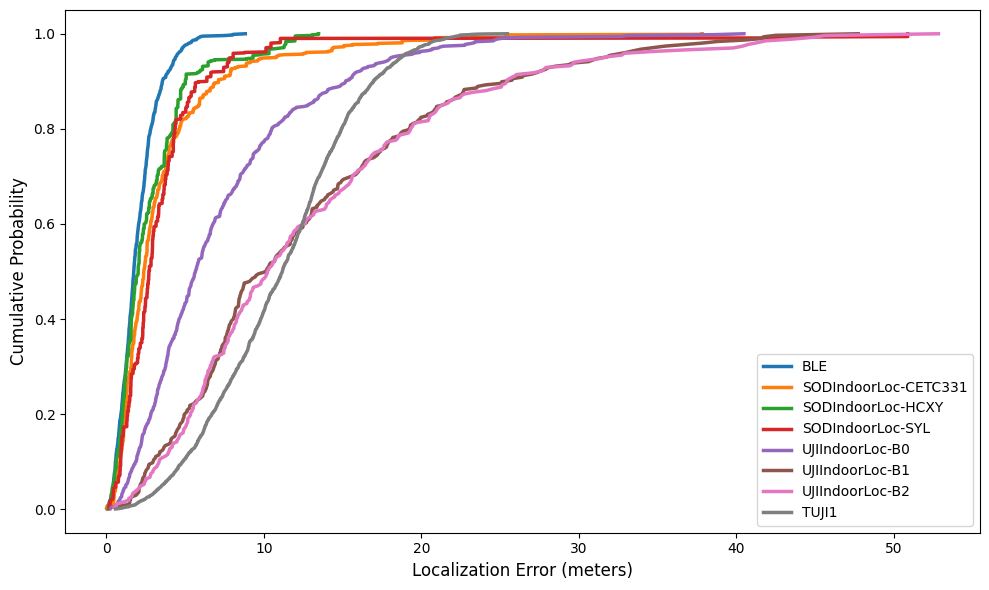

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Assumes distances_ble, distances_c, ..., distances_T are already defined
errors = {
    "BLE": distances_ble,
    "SODIndoorLoc-CETC331": distances_c,
    "SODIndoorLoc-HCXY": distances_h,
    "SODIndoorLoc-SYL": distances_s,
    "UJIIndoorLoc-B0": distances_1,
    "UJIIndoorLoc-B1": distances_2,
    "UJIIndoorLoc-B2": distances_3,
    "TUJI1": distances_T
}

plt.figure(figsize=(10, 6))

for label, dist in errors.items():
    sorted_distances = np.sort(dist)
    cdf = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances)
    plt.plot(sorted_distances, cdf, label=label, linewidth=2.5)

# plt.title("CDF of Localization Errors for All Datasets", fontsize=14)
plt.xlabel("Localization Error (meters)", fontsize=12)
plt.ylabel("Cumulative Probability", fontsize=12)
# plt.grid(True)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('cdf.png', dpi=300, bbox_inches='tight')

plt.show()


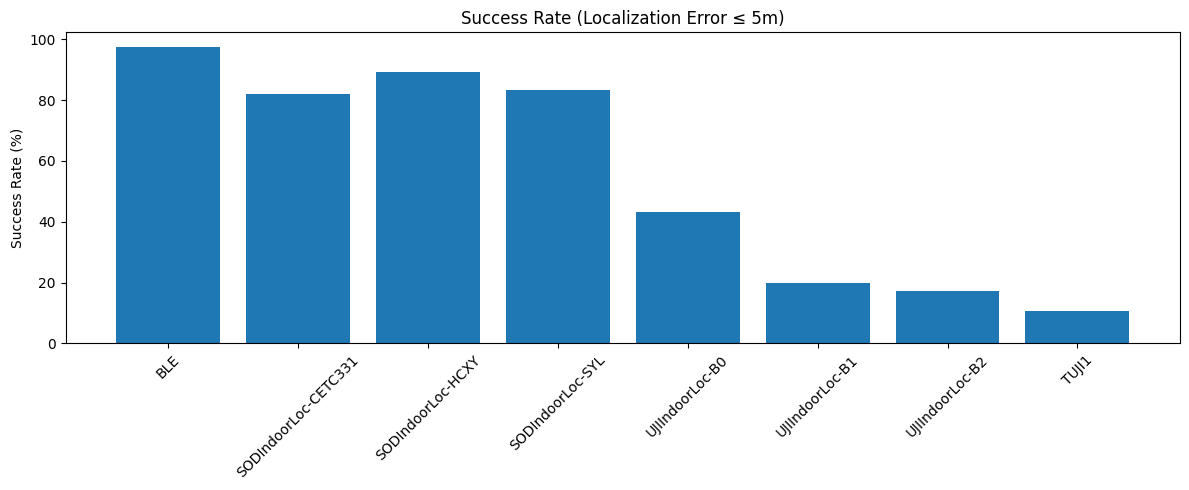

In [29]:
datasets = list(errors.keys())
avg_errors = [np.mean(d) for d in errors.values()]
rmse_errors = [np.sqrt(np.mean(d**2)) for d in errors.values()]
success_rates = [np.mean(d <= 5) * 100 for d in errors.values()]

plt.figure(figsize=(12, 5))
plt.bar(datasets, success_rates)
plt.title("Success Rate (Localization Error ≤ 5m)")
plt.ylabel("Success Rate (%)")
plt.xticks(rotation=45)
# plt.grid(True)
plt.tight_layout()
plt.show()


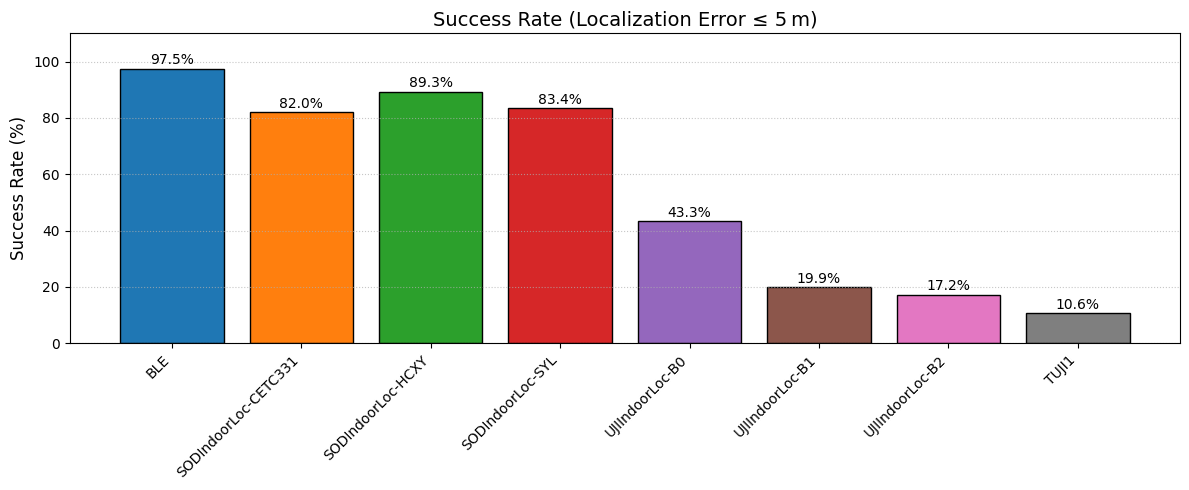

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# your existing errors dict
datasets = list(errors.keys())
success_rates = [np.mean(d <= 5) * 100 for d in errors.values()]

# grab the same palette you used for the CDF
palette = sns.color_palette("tab10", len(datasets))

plt.figure(figsize=(12, 5))
bars = plt.bar(datasets, success_rates, color=palette, edgecolor='k')

plt.title("Success Rate (Localization Error ≤ 5 m)", fontsize=14)
plt.ylabel("Success Rate (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 110)
plt.grid(axis='y', linestyle=':', alpha=0.7)

# annotate each bar with its value
for bar, pct in zip(bars, success_rates):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5,
             f"{pct:.1f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('SR.png', dpi=300, bbox_inches='tight')

plt.show()


## ================ Feature Importance For Cassification ===================

In [14]:
from xgboost import XGBClassifier

model_cetc331 = XGBClassifier()
model_cetc331.load_model("/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_floor_classifier.json")
booster = model_cetc331.get_booster()

model_b0 = XGBClassifier()
model_b0.load_model("/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_floor_classifier_B0.json")
booster = model_b0.get_booster()

model_b1 = XGBClassifier()
model_b1.load_model("/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_floor_classifier_B1.json")
booster = model_b1.get_booster()

model_b2 = XGBClassifier()
model_b2.load_model("/content/drive/MyDrive/THESIS_CODE/journal papers/models/xgb_floor_classifier_B2.json")
booster = model_b2.get_booster()

data_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/CETC331/Training_CETC331.csv"
data_cect = pd.read_csv(data_directory)
rssi_columns_cetc331 = [col for col in data_cect.columns if "MAC" in col]

data_directoryb0 = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building0/UjiindoorLoc_building_0/train_building_0.csv"
data_b0 = pd.read_csv(data_directoryb0)
rssi_columns_b0 = [col for col in data_b0.columns if "WAP" in col]

data_directoryb1 = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building1/UjiindoorLoc_building_1/train_building_1.csv"
data_b1 = pd.read_csv(data_directoryb1)
rssi_columns_b1 = [col for col in data_b1.columns if "WAP" in col]

data_directoryb2 = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building2/UjiindoorLoc_building_2/train_building_2.csv"
data_b2 = pd.read_csv(data_directoryb2)
rssi_columns_b2 = [col for col in data_b2.columns if "WAP" in col]

Top-10 importances extracted and saved to CSV. Ready for plotting!


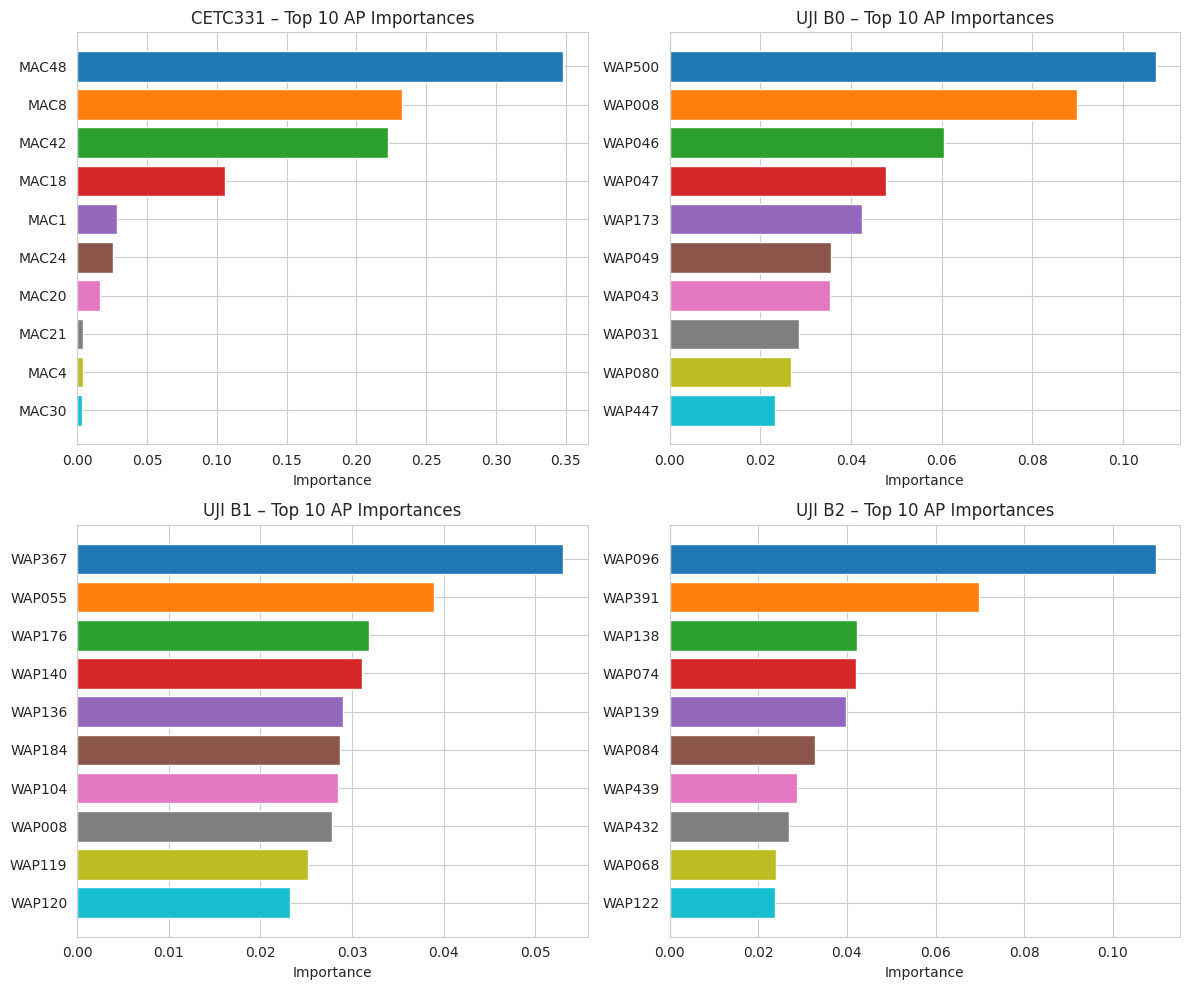

In [21]:
import numpy as np
import pandas as pd

def extract_top_importances(models_info, top_n=10):
    """
    Extracts top N feature importances for multiple models.

    Args:
        models_info (list of tuples): Each tuple contains
            (name, model, feature_names_list)
        top_n (int): Number of top features to extract.

    Returns:
        dict: A mapping from model name to a DataFrame of top features and importances.
    """
    results = {}
    for name, model, feature_names in models_info:
        if model is None or feature_names is None:
            continue
        importances = model.feature_importances_
        idx_sorted = np.argsort(importances)[::-1][:top_n]
        top_features = [feature_names[i] for i in idx_sorted]
        top_importances = importances[idx_sorted]
        df_top = pd.DataFrame({
            'Feature': top_features,
            'Importance': top_importances
        }).reset_index(drop=True)
        results[name] = df_top
    return results

# === Example usage for 4 buildings ===
# Prepare your list of (name, model_object, feature_list)
models_info = [
    ("CETC331", model_cetc331, rssi_columns_cetc331),
    ("UJI B0", model_b0,       rssi_columns_b0),
    ("UJI B1", model_b1,       rssi_columns_b1),
    ("UJI B2", model_b2,       rssi_columns_b2),
]

# Extract top-10 importances
top_importances = extract_top_importances(models_info, top_n=10)

# Convert to a single DataFrame for plotting
df_all = pd.concat(
    [df.assign(Dataset=name) for name, df in top_importances.items()],
    ignore_index=True
)[['Dataset', 'Feature', 'Importance']]

# Save to CSV if needed
df_all.to_csv("top10_feature_importances_all_buildings.csv", index=False)

print("Top-10 importances extracted and saved to CSV. Ready for plotting!")


import matplotlib.pyplot as plt
import seaborn as sns

names = list(top_importances.keys())
dfs   = [top_importances[name] for name in names]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# pick a 10‐color palette
palette = sns.color_palette("tab10", 10)

for ax, name, df in zip(axes.flatten(), names, dfs):
    # apply the same 10‐color palette to each plot
    ax.barh(df['Feature'], df['Importance'], color=palette)
    ax.set_title(f"{name} – Top 10 AP Importances")
    ax.set_xlabel("Importance")
    ax.invert_yaxis()  # highest importance at top

plt.tight_layout()
plt.savefig('feature_importances_class.png', dpi=300, bbox_inches='tight')
plt.show()


## ======= Fingerprint Quality Characterization ================

In [44]:
import numpy as np
import pandas as pd
from scipy.stats import entropy, pearsonr
import os

# ------------------------ RSSI Preprocessing Helper ------------------------
def preprocess_rssi(RSSI_df, dataset_name):
    RSSI = RSSI_df.copy()
    if dataset_name in ["uji", "b0", "b1", "b2", "tjui"]:
        RSSI.replace(100, np.nan, inplace=True)
    else:
        RSSI[RSSI <= -100] = np.nan
    return RSSI

# ------------------------ Metric Functions ------------------------
def compute_effective_ap_count(RSSI, min_presence_ratio=0.05, min_entropy_threshold=1.0):
    num_samples = RSSI.shape[0]
    present_counts = RSSI.notna().sum(axis=0)
    entropy_scores = RSSI.apply(
        lambda col: entropy(np.histogram(col.dropna(), bins=10, range=(-100, -30), density=True)[0]),
        axis=0
    )
    valid_aps = (present_counts > min_presence_ratio * num_samples) & (entropy_scores > min_entropy_threshold)
    return valid_aps.sum()

def compute_signal_sparsity_index(RSSI):
    total_elements = RSSI.size
    missing_elements = RSSI.isna().sum().sum()
    return missing_elements / total_elements

def compute_signal_entropy_score(RSSI):
    entropies = RSSI.apply(
        lambda col: entropy(np.histogram(col.dropna(), bins=10, range=(-100, -30), density=True)[0]),
        axis=0
    )
    return np.mean(entropies)

def compute_ap_redundancy_score(RSSI):
    correlations = []
    ap_names = RSSI.columns
    for i in range(len(ap_names)):
        for j in range(i + 1, len(ap_names)):
            x = RSSI[ap_names[i]].dropna()
            y = RSSI[ap_names[j]].dropna()
            aligned = pd.concat([x, y], axis=1).dropna()
            if aligned.shape[0] >= 2 and aligned.iloc[:, 0].std() > 0 and aligned.iloc[:, 1].std() > 0:
                corr, _ = pearsonr(aligned.iloc[:, 0], aligned.iloc[:, 1])
                correlations.append(abs(corr))
    return np.mean(correlations) if correlations else np.nan


def compute_device_bias_index(data, rssi_columns, device_col='PhoneID'):
    if device_col not in data.columns:
        print(f"Column '{device_col}' not found.")
        return np.nan
    data[device_col] = data[device_col].astype(str)
    device_ids = data[device_col].dropna().unique()
    if len(device_ids) < 2:
        print("Not enough distinct devices to compute DBI.")
        return np.nan
    bias_scores = []
    for ap in rssi_columns:
        means = []
        for dev in device_ids:
            values = data.loc[data[device_col] == dev, ap]
            if values.notna().sum() > 0:
                means.append(values.mean())
        if len(means) > 1:
            bias_scores.append(np.std(means))
    return np.mean(bias_scores) if bias_scores else np.nan

# ------------------------ Dataset Loading ------------------------
# Manually define your dataset paths here
data_directory = "/content/drive/MyDrive/DATASETS/1. RSSI using BLE/Indoor Environment Dataset Based on RSSI Collected with Bluetooth Devices"

# Initialize an empty list to store DataFrames
dataframes = []
for file in os.listdir(data_directory):
    if file.endswith(".csv"):  # Only process CSV files
        file_path = os.path.join(data_directory, file)
        df = pd.read_csv(file_path)
        dataframes.append(df)

# Combine all DataFrames into one
data_ble = pd.concat(dataframes, ignore_index=True)


# === Preprocess RSSI Columns ===
rssi_columns_ble = [col for col in data_ble.columns if "WAP" in col]
# Feature Selection: Extract RSSI columns and target coordinates
RSSI_ble = data_ble[rssi_columns_ble].copy()  # Combine RSSI columns with additional features + ['ROOM_ID']
#####################################################################################################################################3
data_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/CETC331/Training_CETC331.csv"
tets_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/CETC331/Testing_CETC331.csv"
data_cect = pd.read_csv(data_directory)
t_data = pd.read_csv(tets_directory)

# === Preprocess RSSI Columns ===
rssi_columns = [col for col in data_cect.columns if "MAC" in col]
RSSI_cect = data_cect[rssi_columns].copy()  # Combine RSSI columns with additional features + ['ROOM_ID']
#####################################################################################################################################3
data_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/HCXY/pre installed AP only/Training_HCXY_AP_30.csv"
tets_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/HCXY/pre installed AP only/Testing_HCXY_AP.csv"
data_hcxy = pd.read_csv(data_directory)
t_data = pd.read_csv(tets_directory)

# === Preprocess RSSI Columns ===
rssi_columns = [col for col in data_hcxy.columns if "MAC" in col]
RSSI_hcxy = data_hcxy[rssi_columns].copy()  # Combine RSSI columns with additional features + ['ROOM_ID']
#####################################################################################################################################3
data_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/SYL/Only pre installed AP/Training_SYL_AP_30.csv"
tets_directory = "/content/drive/MyDrive/DATASETS/2. SODloc /SODIndoorLoc-main/SYL/Only pre installed AP/Testing_SYL_AP.csv"
data_syl = pd.read_csv(data_directory)
t_data = pd.read_csv(tets_directory)

# === Preprocess RSSI Columns ===
rssi_columns = [col for col in data_syl.columns if "MAC" in col]
RSSI_syl = data_syl[rssi_columns].copy()  # Combine RSSI columns with additional features + ['ROOM_ID']
#####################################################################################################################################3
path_train = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building0/UjiindoorLoc_building_0/train_building_0.csv"
path_test = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building0/UjiindoorLoc_building_0/val_building_0.csv"
data_b0 = pd.read_csv(path_train)
t_data = pd.read_csv(path_test)

# === Preprocess RSSI Columns ===
rssi_columns = [col for col in data_b0.columns if "WAP" in col]
RSSI_b0 = data_b0[rssi_columns].copy()  # Combine RSSI columns with additional features + ['ROOM_ID']
#####################################################################################################################################3
path_train = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building1/UjiindoorLoc_building_1/train_building_1.csv"
path_test = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building1/UjiindoorLoc_building_1/val_building_1.csv"

data_b1 = pd.read_csv(path_train)
t_data = pd.read_csv(path_test)

# === Preprocess RSSI Columns ===
rssi_columns = [col for col in data_b1.columns if "WAP" in col]
RSSI_b1 = data_b1[rssi_columns].copy()  # Combine RSSI columns with additional features + ['ROOM_ID']
#####################################################################################################################################3
path_train = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building2/UjiindoorLoc_building_2/train_building_2.csv"
path_test = "/content/drive/MyDrive/ILS Models/0 Single building ujiindoorloc/building2/UjiindoorLoc_building_2/val_building_2.csv"
data_b2 = pd.read_csv(path_train)
t_data = pd.read_csv(path_test)

# === Preprocess RSSI Columns ===
rssi_columns = [col for col in data_b2.columns if "WAP" in col]
RSSI_b2 = data_b2[rssi_columns].copy()  # Combine RSSI columns with additional features + ['ROOM_ID']
#####################################################################################################################################3
data_directory = "/content/drive/MyDrive/DATASETS/4. TUJI1 Dataset/Train.csv"
tets_directory = "/content/drive/MyDrive/DATASETS/4. TUJI1 Dataset/Test.csv"
data_tjui = pd.read_csv(data_directory)
t_data = pd.read_csv(tets_directory)

# === Preprocess RSSI Columns ===
rssi_columns = [col for col in data_tjui.columns if "AP" in col]
RSSI_tjui = data_tjui[rssi_columns].copy()  # Combine RSSI columns with additional features + ['ROOM_ID']
#####################################################################################################################################3

# Column extraction
RSSI_ble  = preprocess_rssi(data_ble[[col for col in data_ble.columns if "WAP" in col]], "ble")
RSSI_cect = preprocess_rssi(data_cect[[col for col in data_cect.columns if "MAC" in col]], "cect")
RSSI_hcxy = preprocess_rssi(data_hcxy[[col for col in data_hcxy.columns if "MAC" in col]], "hcxy")
RSSI_syl  = preprocess_rssi(data_syl[[col for col in data_syl.columns if "MAC" in col]], "syl")
RSSI_b0   = preprocess_rssi(data_b0[[col for col in data_b0.columns if "WAP" in col]], "b0")
RSSI_b1   = preprocess_rssi(data_b1[[col for col in data_b1.columns if "WAP" in col]], "b1")
RSSI_b2   = preprocess_rssi(data_b2[[col for col in data_b2.columns if "WAP" in col]], "b2")
RSSI_tjui = preprocess_rssi(data_tjui[[col for col in data_tjui.columns if "AP" in col]], "tjui")

# ------------------------ Dataset Map ------------------------
device_col_map = {
    "ble": "DEVICE",
    "cect": "PhoneID",
    "hcxy": "PhoneID",
    "syl": "PhoneID",
    "b0": "PHONEID",
    "b1": "PHONEID",
    "b2": "PHONEID",
    "tjui": "device_id"
}

datasets = {
    "ble": (data_ble, RSSI_ble),
    "cect": (data_cect, RSSI_cect),
    "hcxy": (data_hcxy, RSSI_hcxy),
    "syl": (data_syl, RSSI_syl),
    "b0": (data_b0, RSSI_b0),
    "b1": (data_b1, RSSI_b1),
    "b2": (data_b2, RSSI_b2),
    "tjui": (data_tjui, RSSI_tjui)
}

# ------------------------ Evaluation Loop ------------------------
for name, (df, rssi) in datasets.items():
    print(f"\nDataset: {name.upper()}")
    device_col = device_col_map.get(name, None)

    eac = compute_effective_ap_count(rssi)
    ssi = compute_signal_sparsity_index(rssi)
    ses = compute_signal_entropy_score(rssi)
    ars = compute_ap_redundancy_score(rssi)
    dbi = compute_device_bias_index(df, rssi.columns, device_col=device_col) if device_col else np.nan

    print("\nFingerprint Quality Metrics:")
    print(f"Effective AP Count (EAC): {eac}")
    print(f"Signal Sparsity Index (SL): {ssi:.4f}")
    print(f"Signal Entropy Score (SES): {ses:.4f}")
    print(f"AP Redundancy Score (ARS): {ars:.4f}")
    print(f"Device Bias Index (DBI): {dbi:.4f}")




Dataset: BLE

Fingerprint Quality Metrics:
Effective AP Count (EAC): 14
Signal Sparsity Index (SL): 0.7161
Signal Entropy Score (SES): 1.3395
AP Redundancy Score (ARS): 0.2737
Device Bias Index (DBI): 0.3885

Dataset: CECT
Not enough distinct devices to compute DBI.

Fingerprint Quality Metrics:
Effective AP Count (EAC): 50
Signal Sparsity Index (SL): 0.0008
Signal Entropy Score (SES): 1.8784
AP Redundancy Score (ARS): 0.3118
Device Bias Index (DBI): nan

Dataset: HCXY

Fingerprint Quality Metrics:
Effective AP Count (EAC): 55
Signal Sparsity Index (SL): 0.0000
Signal Entropy Score (SES): 1.8263
AP Redundancy Score (ARS): 0.3105
Device Bias Index (DBI): 51.0677

Dataset: SYL

Fingerprint Quality Metrics:
Effective AP Count (EAC): 45
Signal Sparsity Index (SL): 0.0000
Signal Entropy Score (SES): 1.7401
AP Redundancy Score (ARS): 0.2893
Device Bias Index (DBI): 27.1031

Dataset: B0

Fingerprint Quality Metrics:
Effective AP Count (EAC): 77
Signal Sparsity Index (SL): 0.9696
Signal Entro